In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2573364/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 77xb9byl


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-77xb9byl:best, 58.49MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2604 [00:00<31:05,  1.40it/s]

  0%|                                                                                                        | 2/2604 [00:00<18:25,  2.35it/s]

  0%|                                                                                                        | 3/2604 [00:01<14:21,  3.02it/s]

  0%|▏                                                                                                       | 4/2604 [00:01<12:26,  3.48it/s]

  0%|▏                                                                                                       | 5/2604 [00:01<11:22,  3.81it/s]

  0%|▏                                                                                                       | 6/2604 [00:01<10:44,  4.03it/s]

  0%|▎                                                                                                       | 7/2604 [00:02<10:19,  4.19it/s]

  0%|▎                                                                                                       | 8/2604 [00:02<10:04,  4.30it/s]

  0%|▎                                                                                                       | 9/2604 [00:02<09:52,  4.38it/s]

  0%|▍                                                                                                      | 10/2604 [00:02<09:45,  4.43it/s]

  0%|▍                                                                                                      | 11/2604 [00:02<09:40,  4.47it/s]

  0%|▍                                                                                                      | 12/2604 [00:03<09:36,  4.49it/s]

  0%|▌                                                                                                      | 13/2604 [00:03<09:34,  4.51it/s]

  1%|▌                                                                                                      | 14/2604 [00:03<09:32,  4.53it/s]

  1%|▌                                                                                                      | 15/2604 [00:03<09:31,  4.53it/s]

  1%|▋                                                                                                      | 16/2604 [00:04<09:30,  4.54it/s]

  1%|▋                                                                                                      | 17/2604 [00:04<09:29,  4.54it/s]

  1%|▋                                                                                                      | 18/2604 [00:04<09:28,  4.55it/s]

  1%|▊                                                                                                      | 19/2604 [00:04<09:28,  4.55it/s]

  1%|▊                                                                                                      | 20/2604 [00:04<09:27,  4.55it/s]

  1%|▊                                                                                                      | 21/2604 [00:05<09:27,  4.55it/s]

  1%|▊                                                                                                      | 22/2604 [00:05<09:27,  4.55it/s]

  1%|▉                                                                                                      | 23/2604 [00:05<09:26,  4.55it/s]

  1%|▉                                                                                                      | 24/2604 [00:05<09:26,  4.55it/s]

  1%|▉                                                                                                      | 25/2604 [00:05<09:26,  4.55it/s]

  1%|█                                                                                                      | 26/2604 [00:06<09:26,  4.55it/s]

  1%|█                                                                                                      | 27/2604 [00:06<09:25,  4.55it/s]

  1%|█                                                                                                      | 28/2604 [00:06<09:25,  4.55it/s]

  1%|█▏                                                                                                     | 29/2604 [00:06<09:25,  4.55it/s]

  1%|█▏                                                                                                     | 30/2604 [00:07<09:25,  4.55it/s]

  1%|█▏                                                                                                     | 31/2604 [00:07<09:24,  4.56it/s]

  1%|█▎                                                                                                     | 32/2604 [00:07<09:24,  4.55it/s]

  1%|█▎                                                                                                     | 33/2604 [00:07<09:24,  4.55it/s]

  1%|█▎                                                                                                     | 34/2604 [00:07<09:24,  4.55it/s]

  1%|█▍                                                                                                     | 35/2604 [00:08<09:23,  4.56it/s]

  1%|█▍                                                                                                     | 36/2604 [00:08<09:24,  4.55it/s]

  1%|█▍                                                                                                     | 37/2604 [00:08<09:23,  4.55it/s]

  1%|█▌                                                                                                     | 38/2604 [00:08<09:23,  4.55it/s]

  1%|█▌                                                                                                     | 39/2604 [00:09<09:23,  4.55it/s]

  2%|█▌                                                                                                     | 40/2604 [00:09<09:22,  4.56it/s]

  2%|█▌                                                                                                     | 41/2604 [00:09<09:22,  4.56it/s]

  2%|█▋                                                                                                     | 42/2604 [00:09<09:21,  4.56it/s]

  2%|█▋                                                                                                     | 43/2604 [00:09<09:21,  4.56it/s]

  2%|█▋                                                                                                     | 44/2604 [00:10<09:21,  4.56it/s]

  2%|█▊                                                                                                     | 45/2604 [00:10<09:21,  4.56it/s]

  2%|█▊                                                                                                     | 46/2604 [00:10<09:21,  4.56it/s]

  2%|█▊                                                                                                     | 47/2604 [00:10<09:21,  4.56it/s]

  2%|█▉                                                                                                     | 48/2604 [00:11<09:20,  4.56it/s]

  2%|█▉                                                                                                     | 49/2604 [00:11<09:20,  4.56it/s]

  2%|█▉                                                                                                     | 50/2604 [00:11<09:20,  4.56it/s]

  2%|██                                                                                                     | 51/2604 [00:11<09:20,  4.56it/s]

  2%|██                                                                                                     | 52/2604 [00:11<09:19,  4.56it/s]

  2%|██                                                                                                     | 53/2604 [00:12<09:20,  4.56it/s]

  2%|██▏                                                                                                    | 54/2604 [00:12<09:19,  4.56it/s]

  2%|██▏                                                                                                    | 55/2604 [00:12<09:19,  4.56it/s]

  2%|██▏                                                                                                    | 56/2604 [00:12<09:19,  4.56it/s]

  2%|██▎                                                                                                    | 57/2604 [00:13<09:19,  4.55it/s]

  2%|██▎                                                                                                    | 58/2604 [00:13<09:18,  4.56it/s]

  2%|██▎                                                                                                    | 59/2604 [00:13<09:18,  4.56it/s]

  2%|██▎                                                                                                    | 60/2604 [00:13<09:18,  4.55it/s]

  2%|██▍                                                                                                    | 61/2604 [00:13<09:18,  4.55it/s]

  2%|██▍                                                                                                    | 62/2604 [00:14<09:17,  4.56it/s]

  2%|██▍                                                                                                    | 63/2604 [00:14<09:17,  4.56it/s]

  2%|██▌                                                                                                    | 64/2604 [00:14<09:17,  4.55it/s]

  2%|██▌                                                                                                    | 65/2604 [00:14<09:17,  4.55it/s]

  3%|██▌                                                                                                    | 66/2604 [00:14<09:17,  4.56it/s]

  3%|██▋                                                                                                    | 67/2604 [00:15<09:17,  4.55it/s]

  3%|██▋                                                                                                    | 68/2604 [00:15<09:16,  4.55it/s]

  3%|██▋                                                                                                    | 69/2604 [00:15<09:16,  4.55it/s]

  3%|██▊                                                                                                    | 70/2604 [00:15<09:16,  4.56it/s]

  3%|██▊                                                                                                    | 71/2604 [00:16<09:16,  4.55it/s]

  3%|██▊                                                                                                    | 72/2604 [00:16<09:15,  4.55it/s]

  3%|██▉                                                                                                    | 73/2604 [00:16<09:15,  4.56it/s]

  3%|██▉                                                                                                    | 74/2604 [00:16<09:15,  4.55it/s]

  3%|██▉                                                                                                    | 75/2604 [00:16<09:15,  4.55it/s]

  3%|███                                                                                                    | 76/2604 [00:17<09:14,  4.56it/s]

  3%|███                                                                                                    | 77/2604 [00:17<09:14,  4.56it/s]

  3%|███                                                                                                    | 78/2604 [00:17<09:14,  4.56it/s]

  3%|███                                                                                                    | 79/2604 [00:17<09:14,  4.56it/s]

  3%|███▏                                                                                                   | 80/2604 [00:18<09:13,  4.56it/s]

  3%|███▏                                                                                                   | 81/2604 [00:18<09:14,  4.55it/s]

  3%|███▏                                                                                                   | 82/2604 [00:18<09:13,  4.55it/s]

  3%|███▎                                                                                                   | 83/2604 [00:18<09:13,  4.56it/s]

  3%|███▎                                                                                                   | 84/2604 [00:18<09:13,  4.56it/s]

  3%|███▎                                                                                                   | 85/2604 [00:19<09:13,  4.55it/s]

  3%|███▍                                                                                                   | 86/2604 [00:19<09:12,  4.55it/s]

  3%|███▍                                                                                                   | 87/2604 [00:19<09:12,  4.56it/s]

  3%|███▍                                                                                                   | 88/2604 [00:19<09:12,  4.55it/s]

  3%|███▌                                                                                                   | 89/2604 [00:20<09:12,  4.55it/s]

  3%|███▌                                                                                                   | 90/2604 [00:20<09:11,  4.55it/s]

  3%|███▌                                                                                                   | 91/2604 [00:20<09:11,  4.56it/s]

  4%|███▋                                                                                                   | 92/2604 [00:20<09:11,  4.55it/s]

  4%|███▋                                                                                                   | 93/2604 [00:20<09:11,  4.55it/s]

  4%|███▋                                                                                                   | 94/2604 [00:21<09:11,  4.55it/s]

  4%|███▊                                                                                                   | 95/2604 [00:21<09:11,  4.55it/s]

  4%|███▊                                                                                                   | 96/2604 [00:21<09:10,  4.55it/s]

  4%|███▊                                                                                                   | 97/2604 [00:21<09:10,  4.55it/s]

  4%|███▉                                                                                                   | 98/2604 [00:22<09:10,  4.56it/s]

  4%|███▉                                                                                                   | 99/2604 [00:22<09:10,  4.55it/s]

  4%|███▉                                                                                                  | 100/2604 [00:22<09:09,  4.55it/s]

  4%|███▉                                                                                                  | 101/2604 [00:22<09:09,  4.55it/s]

  4%|███▉                                                                                                  | 102/2604 [00:22<09:09,  4.55it/s]

  4%|████                                                                                                  | 103/2604 [00:23<09:09,  4.55it/s]

  4%|████                                                                                                  | 104/2604 [00:23<09:08,  4.55it/s]

  4%|████                                                                                                  | 105/2604 [00:23<09:08,  4.55it/s]

  4%|████▏                                                                                                 | 106/2604 [00:23<09:08,  4.55it/s]

  4%|████▏                                                                                                 | 107/2604 [00:23<09:08,  4.55it/s]

  4%|████▏                                                                                                 | 108/2604 [00:24<09:08,  4.55it/s]

  4%|████▎                                                                                                 | 109/2604 [00:24<09:08,  4.55it/s]

  4%|████▎                                                                                                 | 110/2604 [00:24<09:07,  4.55it/s]

  4%|████▎                                                                                                 | 111/2604 [00:24<09:07,  4.55it/s]

  4%|████▍                                                                                                 | 112/2604 [00:25<09:07,  4.55it/s]

  4%|████▍                                                                                                 | 113/2604 [00:25<09:07,  4.55it/s]

  4%|████▍                                                                                                 | 114/2604 [00:25<09:06,  4.55it/s]

  4%|████▌                                                                                                 | 115/2604 [00:25<09:06,  4.55it/s]

  4%|████▌                                                                                                 | 116/2604 [00:25<09:06,  4.55it/s]

  4%|████▌                                                                                                 | 117/2604 [00:26<09:06,  4.55it/s]

  5%|████▌                                                                                                 | 118/2604 [00:26<09:05,  4.55it/s]

  5%|████▋                                                                                                 | 119/2604 [00:26<09:05,  4.56it/s]

  5%|████▋                                                                                                 | 120/2604 [00:26<09:05,  4.55it/s]

  5%|████▋                                                                                                 | 121/2604 [00:27<09:05,  4.55it/s]

  5%|████▊                                                                                                 | 122/2604 [00:27<09:04,  4.55it/s]

  5%|████▊                                                                                                 | 123/2604 [00:27<09:04,  4.55it/s]

  5%|████▊                                                                                                 | 124/2604 [00:27<09:04,  4.55it/s]

  5%|████▉                                                                                                 | 125/2604 [00:27<09:03,  4.56it/s]

  5%|████▉                                                                                                 | 126/2604 [00:28<09:03,  4.56it/s]

  5%|████▉                                                                                                 | 127/2604 [00:28<09:03,  4.56it/s]

  5%|█████                                                                                                 | 128/2604 [00:28<09:03,  4.56it/s]

  5%|█████                                                                                                 | 129/2604 [00:28<09:02,  4.56it/s]

  5%|█████                                                                                                 | 130/2604 [00:29<09:03,  4.56it/s]

  5%|█████▏                                                                                                | 131/2604 [00:29<09:02,  4.56it/s]

  5%|█████▏                                                                                                | 132/2604 [00:29<09:02,  4.56it/s]

  5%|█████▏                                                                                                | 133/2604 [00:29<09:02,  4.56it/s]

  5%|█████▏                                                                                                | 134/2604 [00:29<09:02,  4.56it/s]

  5%|█████▎                                                                                                | 135/2604 [00:30<09:01,  4.56it/s]

  5%|█████▎                                                                                                | 136/2604 [00:30<09:01,  4.56it/s]

  5%|█████▎                                                                                                | 137/2604 [00:30<09:01,  4.56it/s]

  5%|█████▍                                                                                                | 138/2604 [00:30<09:01,  4.56it/s]

  5%|█████▍                                                                                                | 139/2604 [00:31<09:00,  4.56it/s]

  5%|█████▍                                                                                                | 140/2604 [00:31<09:00,  4.56it/s]

  5%|█████▌                                                                                                | 141/2604 [00:31<09:00,  4.56it/s]

  5%|█████▌                                                                                                | 142/2604 [00:31<09:00,  4.56it/s]

  5%|█████▌                                                                                                | 143/2604 [00:31<08:59,  4.56it/s]

  6%|█████▋                                                                                                | 144/2604 [00:32<09:00,  4.56it/s]

  6%|█████▋                                                                                                | 145/2604 [00:32<08:59,  4.56it/s]

  6%|█████▋                                                                                                | 146/2604 [00:32<08:59,  4.56it/s]

  6%|█████▊                                                                                                | 147/2604 [00:32<08:59,  4.56it/s]

  6%|█████▊                                                                                                | 148/2604 [00:32<08:59,  4.55it/s]

  6%|█████▊                                                                                                | 149/2604 [00:33<08:59,  4.55it/s]

  6%|█████▉                                                                                                | 150/2604 [00:33<08:58,  4.55it/s]

  6%|█████▉                                                                                                | 151/2604 [00:33<08:58,  4.55it/s]

  6%|█████▉                                                                                                | 152/2604 [00:33<08:58,  4.55it/s]

  6%|█████▉                                                                                                | 153/2604 [00:34<08:58,  4.55it/s]

  6%|██████                                                                                                | 154/2604 [00:34<08:58,  4.55it/s]

  6%|██████                                                                                                | 155/2604 [00:34<08:58,  4.55it/s]

  6%|██████                                                                                                | 156/2604 [00:34<08:57,  4.55it/s]

  6%|██████▏                                                                                               | 157/2604 [00:34<08:57,  4.56it/s]

  6%|██████▏                                                                                               | 158/2604 [00:35<08:57,  4.55it/s]

  6%|██████▏                                                                                               | 159/2604 [00:35<08:56,  4.56it/s]

  6%|██████▎                                                                                               | 160/2604 [00:35<08:56,  4.56it/s]

  6%|██████▎                                                                                               | 161/2604 [00:35<08:56,  4.56it/s]

  6%|██████▎                                                                                               | 162/2604 [00:36<08:56,  4.55it/s]

  6%|██████▍                                                                                               | 163/2604 [00:36<08:55,  4.56it/s]

  6%|██████▍                                                                                               | 164/2604 [00:36<08:55,  4.56it/s]

  6%|██████▍                                                                                               | 165/2604 [00:36<08:55,  4.55it/s]

  6%|██████▌                                                                                               | 166/2604 [00:36<08:55,  4.55it/s]

  6%|██████▌                                                                                               | 167/2604 [00:37<08:54,  4.56it/s]

  6%|██████▌                                                                                               | 168/2604 [00:37<08:54,  4.56it/s]

  6%|██████▌                                                                                               | 169/2604 [00:37<08:54,  4.55it/s]

  7%|██████▋                                                                                               | 170/2604 [00:37<08:54,  4.55it/s]

  7%|██████▋                                                                                               | 171/2604 [00:38<08:53,  4.56it/s]

  7%|██████▋                                                                                               | 172/2604 [00:38<08:54,  4.55it/s]

  7%|██████▊                                                                                               | 173/2604 [00:38<08:53,  4.56it/s]

  7%|██████▊                                                                                               | 174/2604 [00:38<08:53,  4.56it/s]

  7%|██████▊                                                                                               | 175/2604 [00:38<08:53,  4.56it/s]

  7%|██████▉                                                                                               | 176/2604 [00:39<08:53,  4.55it/s]

  7%|██████▉                                                                                               | 177/2604 [00:39<08:52,  4.56it/s]

  7%|██████▉                                                                                               | 178/2604 [00:39<08:52,  4.56it/s]

  7%|███████                                                                                               | 179/2604 [00:39<08:52,  4.56it/s]

  7%|███████                                                                                               | 180/2604 [00:40<08:52,  4.56it/s]

  7%|███████                                                                                               | 181/2604 [00:40<08:51,  4.56it/s]

  7%|███████▏                                                                                              | 182/2604 [00:40<08:51,  4.56it/s]

  7%|███████▏                                                                                              | 183/2604 [00:40<08:51,  4.55it/s]

  7%|███████▏                                                                                              | 184/2604 [00:40<08:51,  4.56it/s]

  7%|███████▏                                                                                              | 185/2604 [00:41<08:50,  4.56it/s]

  7%|███████▎                                                                                              | 186/2604 [00:41<08:50,  4.55it/s]

  7%|███████▎                                                                                              | 187/2604 [00:41<08:50,  4.56it/s]

  7%|███████▎                                                                                              | 188/2604 [00:41<08:50,  4.56it/s]

  7%|███████▍                                                                                              | 189/2604 [00:41<08:49,  4.56it/s]

  7%|███████▍                                                                                              | 190/2604 [00:42<08:49,  4.56it/s]

  7%|███████▍                                                                                              | 191/2604 [00:42<08:49,  4.56it/s]

  7%|███████▌                                                                                              | 192/2604 [00:42<08:49,  4.56it/s]

  7%|███████▌                                                                                              | 193/2604 [00:42<08:49,  4.55it/s]

  7%|███████▌                                                                                              | 194/2604 [00:43<08:49,  4.56it/s]

  7%|███████▋                                                                                              | 195/2604 [00:43<08:48,  4.56it/s]

  8%|███████▋                                                                                              | 196/2604 [00:43<08:48,  4.56it/s]

  8%|███████▋                                                                                              | 197/2604 [00:43<08:49,  4.55it/s]

  8%|███████▊                                                                                              | 198/2604 [00:43<08:49,  4.55it/s]

  8%|███████▊                                                                                              | 199/2604 [00:44<08:48,  4.55it/s]

  8%|███████▊                                                                                              | 200/2604 [00:44<08:48,  4.55it/s]

  8%|███████▊                                                                                              | 201/2604 [00:44<08:48,  4.55it/s]

  8%|███████▉                                                                                              | 202/2604 [00:44<08:47,  4.55it/s]

  8%|███████▉                                                                                              | 203/2604 [00:45<08:47,  4.55it/s]

  8%|███████▉                                                                                              | 204/2604 [00:45<08:47,  4.55it/s]

  8%|████████                                                                                              | 205/2604 [00:45<08:46,  4.55it/s]

  8%|████████                                                                                              | 206/2604 [00:45<08:46,  4.55it/s]

  8%|████████                                                                                              | 207/2604 [00:45<08:46,  4.55it/s]

  8%|████████▏                                                                                             | 208/2604 [00:46<08:46,  4.55it/s]

  8%|████████▏                                                                                             | 209/2604 [00:46<08:45,  4.55it/s]

  8%|████████▏                                                                                             | 210/2604 [00:46<08:45,  4.55it/s]

  8%|████████▎                                                                                             | 211/2604 [00:46<08:45,  4.55it/s]

  8%|████████▎                                                                                             | 212/2604 [00:47<08:45,  4.55it/s]

  8%|████████▎                                                                                             | 213/2604 [00:47<08:44,  4.55it/s]

  8%|████████▍                                                                                             | 214/2604 [00:47<08:45,  4.55it/s]

  8%|████████▍                                                                                             | 215/2604 [00:47<08:44,  4.55it/s]

  8%|████████▍                                                                                             | 216/2604 [00:47<08:44,  4.55it/s]

  8%|████████▌                                                                                             | 217/2604 [00:48<08:44,  4.55it/s]

  8%|████████▌                                                                                             | 218/2604 [00:48<08:44,  4.55it/s]

  8%|████████▌                                                                                             | 219/2604 [00:48<08:43,  4.55it/s]

  8%|████████▌                                                                                             | 220/2604 [00:48<08:43,  4.55it/s]

  8%|████████▋                                                                                             | 221/2604 [00:49<08:43,  4.55it/s]

  9%|████████▋                                                                                             | 222/2604 [00:49<08:43,  4.55it/s]

  9%|████████▋                                                                                             | 223/2604 [00:49<08:42,  4.55it/s]

  9%|████████▊                                                                                             | 224/2604 [00:49<08:42,  4.55it/s]

  9%|████████▊                                                                                             | 225/2604 [00:49<08:42,  4.55it/s]

  9%|████████▊                                                                                             | 226/2604 [00:50<08:42,  4.55it/s]

  9%|████████▉                                                                                             | 227/2604 [00:50<08:41,  4.55it/s]

  9%|████████▉                                                                                             | 228/2604 [00:50<08:42,  4.55it/s]

  9%|████████▉                                                                                             | 229/2604 [00:50<08:41,  4.55it/s]

  9%|█████████                                                                                             | 230/2604 [00:50<08:41,  4.55it/s]

  9%|█████████                                                                                             | 231/2604 [00:51<08:40,  4.55it/s]

  9%|█████████                                                                                             | 232/2604 [00:51<08:41,  4.55it/s]

  9%|█████████▏                                                                                            | 233/2604 [00:51<08:40,  4.55it/s]

  9%|█████████▏                                                                                            | 234/2604 [00:51<08:40,  4.55it/s]

  9%|█████████▏                                                                                            | 235/2604 [00:52<08:40,  4.55it/s]

  9%|█████████▏                                                                                            | 236/2604 [00:52<08:40,  4.55it/s]

  9%|█████████▎                                                                                            | 237/2604 [00:52<08:39,  4.55it/s]

  9%|█████████▎                                                                                            | 238/2604 [00:52<08:39,  4.55it/s]

  9%|█████████▎                                                                                            | 239/2604 [00:52<08:39,  4.55it/s]

  9%|█████████▍                                                                                            | 240/2604 [00:53<08:39,  4.55it/s]

  9%|█████████▍                                                                                            | 241/2604 [00:53<08:38,  4.55it/s]

  9%|█████████▍                                                                                            | 242/2604 [00:53<08:38,  4.55it/s]

  9%|█████████▌                                                                                            | 243/2604 [00:53<08:38,  4.55it/s]

  9%|█████████▌                                                                                            | 244/2604 [00:54<08:38,  4.55it/s]

  9%|█████████▌                                                                                            | 245/2604 [00:54<08:38,  4.55it/s]

  9%|█████████▋                                                                                            | 246/2604 [00:54<08:38,  4.55it/s]

  9%|█████████▋                                                                                            | 247/2604 [00:54<08:37,  4.55it/s]

 10%|█████████▋                                                                                            | 248/2604 [00:54<08:37,  4.55it/s]

 10%|█████████▊                                                                                            | 249/2604 [00:55<08:37,  4.55it/s]

 10%|█████████▊                                                                                            | 250/2604 [00:55<08:37,  4.55it/s]

 10%|█████████▊                                                                                            | 251/2604 [00:55<08:37,  4.55it/s]

 10%|█████████▊                                                                                            | 252/2604 [00:55<08:36,  4.55it/s]

 10%|█████████▉                                                                                            | 253/2604 [00:56<08:36,  4.55it/s]

 10%|█████████▉                                                                                            | 254/2604 [00:56<08:36,  4.55it/s]

 10%|█████████▉                                                                                            | 255/2604 [00:56<08:35,  4.55it/s]

 10%|██████████                                                                                            | 256/2604 [00:56<08:35,  4.55it/s]

 10%|██████████                                                                                            | 257/2604 [00:56<08:35,  4.55it/s]

 10%|██████████                                                                                            | 258/2604 [00:57<08:35,  4.55it/s]

 10%|██████████▏                                                                                           | 259/2604 [00:57<08:35,  4.55it/s]

 10%|██████████▏                                                                                           | 260/2604 [00:57<08:34,  4.55it/s]

 10%|██████████▏                                                                                           | 261/2604 [00:57<08:34,  4.56it/s]

 10%|██████████▎                                                                                           | 262/2604 [00:58<08:34,  4.56it/s]

 10%|██████████▎                                                                                           | 263/2604 [00:58<08:34,  4.55it/s]

 10%|██████████▎                                                                                           | 264/2604 [00:58<08:33,  4.55it/s]

 10%|██████████▍                                                                                           | 265/2604 [00:58<08:33,  4.55it/s]

 10%|██████████▍                                                                                           | 266/2604 [00:58<08:33,  4.55it/s]

 10%|██████████▍                                                                                           | 267/2604 [00:59<08:33,  4.55it/s]

 10%|██████████▍                                                                                           | 268/2604 [00:59<08:32,  4.55it/s]

 10%|██████████▌                                                                                           | 269/2604 [00:59<08:32,  4.56it/s]

 10%|██████████▌                                                                                           | 270/2604 [00:59<08:32,  4.55it/s]

 10%|██████████▌                                                                                           | 271/2604 [01:00<08:32,  4.55it/s]

 10%|██████████▋                                                                                           | 272/2604 [01:00<08:32,  4.55it/s]

 10%|██████████▋                                                                                           | 273/2604 [01:00<08:31,  4.55it/s]

 11%|██████████▋                                                                                           | 274/2604 [01:00<08:31,  4.55it/s]

 11%|██████████▊                                                                                           | 275/2604 [01:00<08:31,  4.55it/s]

 11%|██████████▊                                                                                           | 276/2604 [01:01<08:31,  4.56it/s]

 11%|██████████▊                                                                                           | 277/2604 [01:01<08:30,  4.55it/s]

 11%|██████████▉                                                                                           | 278/2604 [01:01<08:30,  4.56it/s]

 11%|██████████▉                                                                                           | 279/2604 [01:01<08:29,  4.56it/s]

 11%|██████████▉                                                                                           | 280/2604 [01:01<08:29,  4.56it/s]

 11%|███████████                                                                                           | 281/2604 [01:02<08:29,  4.56it/s]

 11%|███████████                                                                                           | 282/2604 [01:02<08:29,  4.56it/s]

 11%|███████████                                                                                           | 283/2604 [01:02<08:29,  4.56it/s]

 11%|███████████                                                                                           | 284/2604 [01:02<08:29,  4.56it/s]

 11%|███████████▏                                                                                          | 285/2604 [01:03<08:28,  4.56it/s]

 11%|███████████▏                                                                                          | 286/2604 [01:03<08:28,  4.56it/s]

 11%|███████████▏                                                                                          | 287/2604 [01:03<08:28,  4.56it/s]

 11%|███████████▎                                                                                          | 288/2604 [01:03<08:28,  4.56it/s]

 11%|███████████▎                                                                                          | 289/2604 [01:03<08:27,  4.56it/s]

 11%|███████████▎                                                                                          | 290/2604 [01:04<08:28,  4.55it/s]

 11%|███████████▍                                                                                          | 291/2604 [01:04<08:27,  4.56it/s]

 11%|███████████▍                                                                                          | 292/2604 [01:04<08:27,  4.56it/s]

 11%|███████████▍                                                                                          | 293/2604 [01:04<08:27,  4.56it/s]

 11%|███████████▌                                                                                          | 294/2604 [01:05<08:26,  4.56it/s]

 11%|███████████▌                                                                                          | 295/2604 [01:05<08:26,  4.56it/s]

 11%|███████████▌                                                                                          | 296/2604 [01:05<08:26,  4.56it/s]

 11%|███████████▋                                                                                          | 297/2604 [01:05<08:26,  4.56it/s]

 11%|███████████▋                                                                                          | 298/2604 [01:05<08:25,  4.56it/s]

 11%|███████████▋                                                                                          | 299/2604 [01:06<08:25,  4.56it/s]

 12%|███████████▊                                                                                          | 300/2604 [01:06<08:25,  4.56it/s]

 12%|███████████▊                                                                                          | 301/2604 [01:06<08:25,  4.56it/s]

 12%|███████████▊                                                                                          | 302/2604 [01:06<08:25,  4.56it/s]

 12%|███████████▊                                                                                          | 303/2604 [01:07<08:24,  4.56it/s]

 12%|███████████▉                                                                                          | 304/2604 [01:07<08:24,  4.56it/s]

 12%|███████████▉                                                                                          | 305/2604 [01:07<08:24,  4.56it/s]

 12%|███████████▉                                                                                          | 306/2604 [01:07<08:24,  4.56it/s]

 12%|████████████                                                                                          | 307/2604 [01:07<08:23,  4.56it/s]

 12%|████████████                                                                                          | 308/2604 [01:08<08:23,  4.56it/s]

 12%|████████████                                                                                          | 309/2604 [01:08<08:23,  4.56it/s]

 12%|████████████▏                                                                                         | 310/2604 [01:08<08:23,  4.56it/s]

 12%|████████████▏                                                                                         | 311/2604 [01:08<08:23,  4.55it/s]

 12%|████████████▏                                                                                         | 312/2604 [01:08<08:22,  4.56it/s]

 12%|████████████▎                                                                                         | 313/2604 [01:09<08:22,  4.56it/s]

 12%|████████████▎                                                                                         | 314/2604 [01:09<08:22,  4.56it/s]

 12%|████████████▎                                                                                         | 315/2604 [01:09<08:22,  4.56it/s]

 12%|████████████▍                                                                                         | 316/2604 [01:09<08:22,  4.56it/s]

 12%|████████████▍                                                                                         | 317/2604 [01:10<08:21,  4.56it/s]

 12%|████████████▍                                                                                         | 318/2604 [01:10<08:21,  4.56it/s]

 12%|████████████▍                                                                                         | 319/2604 [01:10<08:21,  4.56it/s]

 12%|████████████▌                                                                                         | 320/2604 [01:10<08:21,  4.55it/s]

 12%|████████████▌                                                                                         | 321/2604 [01:10<08:21,  4.55it/s]

 12%|████████████▌                                                                                         | 322/2604 [01:11<08:21,  4.55it/s]

 12%|████████████▋                                                                                         | 323/2604 [01:11<08:20,  4.56it/s]

 12%|████████████▋                                                                                         | 324/2604 [01:11<08:20,  4.56it/s]

 12%|████████████▋                                                                                         | 325/2604 [01:11<08:20,  4.55it/s]

 13%|████████████▊                                                                                         | 326/2604 [01:12<08:20,  4.55it/s]

 13%|████████████▊                                                                                         | 327/2604 [01:12<08:19,  4.56it/s]

 13%|████████████▊                                                                                         | 328/2604 [01:12<08:19,  4.55it/s]

 13%|████████████▉                                                                                         | 329/2604 [01:12<08:19,  4.55it/s]

 13%|████████████▉                                                                                         | 330/2604 [01:12<08:19,  4.56it/s]

 13%|████████████▉                                                                                         | 331/2604 [01:13<08:18,  4.56it/s]

 13%|█████████████                                                                                         | 332/2604 [01:13<08:18,  4.55it/s]

 13%|█████████████                                                                                         | 333/2604 [01:13<08:18,  4.55it/s]

 13%|█████████████                                                                                         | 334/2604 [01:13<08:18,  4.56it/s]

 13%|█████████████                                                                                         | 335/2604 [01:14<08:18,  4.55it/s]

 13%|█████████████▏                                                                                        | 336/2604 [01:14<08:17,  4.55it/s]

 13%|█████████████▏                                                                                        | 337/2604 [01:14<08:17,  4.56it/s]

 13%|█████████████▏                                                                                        | 338/2604 [01:14<08:17,  4.56it/s]

 13%|█████████████▎                                                                                        | 339/2604 [01:14<08:17,  4.55it/s]

 13%|█████████████▎                                                                                        | 340/2604 [01:15<08:17,  4.56it/s]

 13%|█████████████▎                                                                                        | 341/2604 [01:15<08:16,  4.56it/s]

 13%|█████████████▍                                                                                        | 342/2604 [01:15<08:16,  4.56it/s]

 13%|█████████████▍                                                                                        | 343/2604 [01:15<08:16,  4.56it/s]

 13%|█████████████▍                                                                                        | 344/2604 [01:16<08:15,  4.56it/s]

 13%|█████████████▌                                                                                        | 345/2604 [01:16<08:15,  4.56it/s]

 13%|█████████████▌                                                                                        | 346/2604 [01:16<08:15,  4.56it/s]

 13%|█████████████▌                                                                                        | 347/2604 [01:16<08:15,  4.56it/s]

 13%|█████████████▋                                                                                        | 348/2604 [01:16<08:14,  4.56it/s]

 13%|█████████████▋                                                                                        | 349/2604 [01:17<08:14,  4.56it/s]

 13%|█████████████▋                                                                                        | 350/2604 [01:17<08:14,  4.56it/s]

 13%|█████████████▋                                                                                        | 351/2604 [01:17<08:14,  4.56it/s]

 14%|█████████████▊                                                                                        | 352/2604 [01:17<08:13,  4.56it/s]

 14%|█████████████▊                                                                                        | 353/2604 [01:17<08:13,  4.56it/s]

 14%|█████████████▊                                                                                        | 354/2604 [01:18<08:13,  4.56it/s]

 14%|█████████████▉                                                                                        | 355/2604 [01:18<08:13,  4.56it/s]

 14%|█████████████▉                                                                                        | 356/2604 [01:18<08:13,  4.56it/s]

 14%|█████████████▉                                                                                        | 357/2604 [01:18<08:13,  4.56it/s]

 14%|██████████████                                                                                        | 358/2604 [01:19<08:13,  4.56it/s]

 14%|██████████████                                                                                        | 359/2604 [01:19<08:12,  4.56it/s]

 14%|██████████████                                                                                        | 360/2604 [01:19<08:12,  4.56it/s]

 14%|██████████████▏                                                                                       | 361/2604 [01:19<08:11,  4.56it/s]

 14%|██████████████▏                                                                                       | 362/2604 [01:19<08:11,  4.56it/s]

 14%|██████████████▏                                                                                       | 363/2604 [01:20<08:11,  4.56it/s]

 14%|██████████████▎                                                                                       | 364/2604 [01:20<08:11,  4.56it/s]

 14%|██████████████▎                                                                                       | 365/2604 [01:20<08:10,  4.56it/s]

 14%|██████████████▎                                                                                       | 366/2604 [01:20<08:10,  4.56it/s]

 14%|██████████████▍                                                                                       | 367/2604 [01:21<08:10,  4.56it/s]

 14%|██████████████▍                                                                                       | 368/2604 [01:21<08:10,  4.56it/s]

 14%|██████████████▍                                                                                       | 369/2604 [01:21<08:10,  4.56it/s]

 14%|██████████████▍                                                                                       | 370/2604 [01:21<08:10,  4.56it/s]

 14%|██████████████▌                                                                                       | 371/2604 [01:21<08:09,  4.56it/s]

 14%|██████████████▌                                                                                       | 372/2604 [01:22<08:09,  4.56it/s]

 14%|██████████████▌                                                                                       | 373/2604 [01:22<08:09,  4.56it/s]

 14%|██████████████▋                                                                                       | 374/2604 [01:22<08:09,  4.56it/s]

 14%|██████████████▋                                                                                       | 375/2604 [01:22<08:08,  4.56it/s]

 14%|██████████████▋                                                                                       | 376/2604 [01:23<08:08,  4.56it/s]

 14%|██████████████▊                                                                                       | 377/2604 [01:23<08:08,  4.56it/s]

 15%|██████████████▊                                                                                       | 378/2604 [01:23<08:08,  4.56it/s]

 15%|██████████████▊                                                                                       | 379/2604 [01:23<08:07,  4.56it/s]

 15%|██████████████▉                                                                                       | 380/2604 [01:23<08:08,  4.56it/s]

 15%|██████████████▉                                                                                       | 381/2604 [01:24<08:07,  4.56it/s]

 15%|██████████████▉                                                                                       | 382/2604 [01:24<08:07,  4.56it/s]

 15%|███████████████                                                                                       | 383/2604 [01:24<08:07,  4.56it/s]

 15%|███████████████                                                                                       | 384/2604 [01:24<08:06,  4.56it/s]

 15%|███████████████                                                                                       | 385/2604 [01:25<08:06,  4.56it/s]

 15%|███████████████                                                                                       | 386/2604 [01:25<08:06,  4.56it/s]

 15%|███████████████▏                                                                                      | 387/2604 [01:25<08:06,  4.56it/s]

 15%|███████████████▏                                                                                      | 388/2604 [01:25<08:05,  4.56it/s]

 15%|███████████████▏                                                                                      | 389/2604 [01:25<08:05,  4.56it/s]

 15%|███████████████▎                                                                                      | 390/2604 [01:26<08:05,  4.56it/s]

 15%|███████████████▎                                                                                      | 391/2604 [01:26<08:05,  4.56it/s]

 15%|███████████████▎                                                                                      | 392/2604 [01:26<08:05,  4.56it/s]

 15%|███████████████▍                                                                                      | 393/2604 [01:26<08:04,  4.56it/s]

 15%|███████████████▍                                                                                      | 394/2604 [01:26<08:04,  4.56it/s]

 15%|███████████████▍                                                                                      | 395/2604 [01:27<08:04,  4.56it/s]

 15%|███████████████▌                                                                                      | 396/2604 [01:27<08:04,  4.56it/s]

 15%|███████████████▌                                                                                      | 397/2604 [01:27<08:04,  4.56it/s]

 15%|███████████████▌                                                                                      | 398/2604 [01:27<08:03,  4.56it/s]

 15%|███████████████▋                                                                                      | 399/2604 [01:28<08:03,  4.56it/s]

 15%|███████████████▋                                                                                      | 400/2604 [01:28<08:03,  4.56it/s]

 15%|███████████████▋                                                                                      | 401/2604 [01:28<08:03,  4.56it/s]

 15%|███████████████▋                                                                                      | 402/2604 [01:28<08:03,  4.55it/s]

 15%|███████████████▊                                                                                      | 403/2604 [01:28<08:03,  4.55it/s]

 16%|███████████████▊                                                                                      | 404/2604 [01:29<08:02,  4.56it/s]

 16%|███████████████▊                                                                                      | 405/2604 [01:29<08:02,  4.56it/s]

 16%|███████████████▉                                                                                      | 406/2604 [01:29<08:02,  4.56it/s]

 16%|███████████████▉                                                                                      | 407/2604 [01:29<08:02,  4.56it/s]

 16%|███████████████▉                                                                                      | 408/2604 [01:30<08:01,  4.56it/s]

 16%|████████████████                                                                                      | 409/2604 [01:30<08:01,  4.56it/s]

 16%|████████████████                                                                                      | 410/2604 [01:30<08:01,  4.55it/s]

 16%|████████████████                                                                                      | 411/2604 [01:30<08:01,  4.56it/s]

 16%|████████████████▏                                                                                     | 412/2604 [01:30<08:00,  4.56it/s]

 16%|████████████████▏                                                                                     | 413/2604 [01:31<08:00,  4.56it/s]

 16%|████████████████▏                                                                                     | 414/2604 [01:31<08:00,  4.56it/s]

 16%|████████████████▎                                                                                     | 415/2604 [01:31<08:00,  4.56it/s]

 16%|████████████████▎                                                                                     | 416/2604 [01:31<07:59,  4.56it/s]

 16%|████████████████▎                                                                                     | 417/2604 [01:32<07:59,  4.56it/s]

 16%|████████████████▎                                                                                     | 418/2604 [01:32<07:59,  4.56it/s]

 16%|████████████████▍                                                                                     | 419/2604 [01:32<07:59,  4.56it/s]

 16%|████████████████▍                                                                                     | 420/2604 [01:32<07:59,  4.56it/s]

 16%|████████████████▍                                                                                     | 421/2604 [01:32<07:58,  4.56it/s]

 16%|████████████████▌                                                                                     | 422/2604 [01:33<07:58,  4.56it/s]

 16%|████████████████▌                                                                                     | 423/2604 [01:33<07:58,  4.56it/s]

 16%|████████████████▌                                                                                     | 424/2604 [01:33<07:58,  4.56it/s]

 16%|████████████████▋                                                                                     | 425/2604 [01:33<07:57,  4.56it/s]

 16%|████████████████▋                                                                                     | 426/2604 [01:34<07:57,  4.56it/s]

 16%|████████████████▋                                                                                     | 427/2604 [01:34<07:57,  4.56it/s]

 16%|████████████████▊                                                                                     | 428/2604 [01:34<07:57,  4.56it/s]

 16%|████████████████▊                                                                                     | 429/2604 [01:34<07:57,  4.56it/s]

 17%|████████████████▊                                                                                     | 430/2604 [01:34<07:56,  4.56it/s]

 17%|████████████████▉                                                                                     | 431/2604 [01:35<07:56,  4.56it/s]

 17%|████████████████▉                                                                                     | 432/2604 [01:35<07:56,  4.56it/s]

 17%|████████████████▉                                                                                     | 433/2604 [01:35<07:56,  4.56it/s]

 17%|█████████████████                                                                                     | 434/2604 [01:35<07:56,  4.55it/s]

 17%|█████████████████                                                                                     | 435/2604 [01:35<07:55,  4.56it/s]

 17%|█████████████████                                                                                     | 436/2604 [01:36<07:55,  4.56it/s]

 17%|█████████████████                                                                                     | 437/2604 [01:36<07:55,  4.56it/s]

 17%|█████████████████▏                                                                                    | 438/2604 [01:36<07:55,  4.56it/s]

 17%|█████████████████▏                                                                                    | 439/2604 [01:36<07:54,  4.56it/s]

 17%|█████████████████▏                                                                                    | 440/2604 [01:37<07:54,  4.56it/s]

 17%|█████████████████▎                                                                                    | 441/2604 [01:37<07:54,  4.56it/s]

 17%|█████████████████▎                                                                                    | 442/2604 [01:37<07:54,  4.56it/s]

 17%|█████████████████▎                                                                                    | 443/2604 [01:37<07:54,  4.56it/s]

 17%|█████████████████▍                                                                                    | 444/2604 [01:37<07:53,  4.56it/s]

 17%|█████████████████▍                                                                                    | 445/2604 [01:38<07:53,  4.56it/s]

 17%|█████████████████▍                                                                                    | 446/2604 [01:38<07:53,  4.56it/s]

 17%|█████████████████▌                                                                                    | 447/2604 [01:38<07:52,  4.56it/s]

 17%|█████████████████▌                                                                                    | 448/2604 [01:38<07:53,  4.56it/s]

 17%|█████████████████▌                                                                                    | 449/2604 [01:39<07:52,  4.56it/s]

 17%|█████████████████▋                                                                                    | 450/2604 [01:39<07:52,  4.56it/s]

 17%|█████████████████▋                                                                                    | 451/2604 [01:39<07:52,  4.56it/s]

 17%|█████████████████▋                                                                                    | 452/2604 [01:39<07:52,  4.56it/s]

 17%|█████████████████▋                                                                                    | 453/2604 [01:39<07:52,  4.56it/s]

 17%|█████████████████▊                                                                                    | 454/2604 [01:40<07:51,  4.56it/s]

 17%|█████████████████▊                                                                                    | 455/2604 [01:40<07:51,  4.56it/s]

 18%|█████████████████▊                                                                                    | 456/2604 [01:40<07:51,  4.56it/s]

 18%|█████████████████▉                                                                                    | 457/2604 [01:40<07:50,  4.56it/s]

 18%|█████████████████▉                                                                                    | 458/2604 [01:41<07:50,  4.56it/s]

 18%|█████████████████▉                                                                                    | 459/2604 [01:41<07:50,  4.56it/s]

 18%|██████████████████                                                                                    | 460/2604 [01:41<07:50,  4.56it/s]

 18%|██████████████████                                                                                    | 461/2604 [01:41<07:49,  4.56it/s]

 18%|██████████████████                                                                                    | 462/2604 [01:41<07:49,  4.56it/s]

 18%|██████████████████▏                                                                                   | 463/2604 [01:42<07:49,  4.56it/s]

 18%|██████████████████▏                                                                                   | 464/2604 [01:42<07:49,  4.56it/s]

 18%|██████████████████▏                                                                                   | 465/2604 [01:42<07:49,  4.56it/s]

 18%|██████████████████▎                                                                                   | 466/2604 [01:42<07:49,  4.56it/s]

 18%|██████████████████▎                                                                                   | 467/2604 [01:43<07:48,  4.56it/s]

 18%|██████████████████▎                                                                                   | 468/2604 [01:43<07:48,  4.56it/s]

 18%|██████████████████▎                                                                                   | 469/2604 [01:43<07:48,  4.56it/s]

 18%|██████████████████▍                                                                                   | 470/2604 [01:43<07:48,  4.56it/s]

 18%|██████████████████▍                                                                                   | 471/2604 [01:43<07:48,  4.56it/s]

 18%|██████████████████▍                                                                                   | 472/2604 [01:44<07:48,  4.56it/s]

 18%|██████████████████▌                                                                                   | 473/2604 [01:44<07:47,  4.56it/s]

 18%|██████████████████▌                                                                                   | 474/2604 [01:44<07:47,  4.56it/s]

 18%|██████████████████▌                                                                                   | 475/2604 [01:44<07:46,  4.56it/s]

 18%|██████████████████▋                                                                                   | 476/2604 [01:44<07:46,  4.56it/s]

 18%|██████████████████▋                                                                                   | 477/2604 [01:45<07:46,  4.56it/s]

 18%|██████████████████▋                                                                                   | 478/2604 [01:45<07:46,  4.56it/s]

 18%|██████████████████▊                                                                                   | 479/2604 [01:45<07:46,  4.56it/s]

 18%|██████████████████▊                                                                                   | 480/2604 [01:45<07:45,  4.56it/s]

 18%|██████████████████▊                                                                                   | 481/2604 [01:46<07:45,  4.56it/s]

 19%|██████████████████▉                                                                                   | 482/2604 [01:46<07:45,  4.56it/s]

 19%|██████████████████▉                                                                                   | 483/2604 [01:46<07:45,  4.56it/s]

 19%|██████████████████▉                                                                                   | 484/2604 [01:46<07:45,  4.56it/s]

 19%|██████████████████▉                                                                                   | 485/2604 [01:46<07:44,  4.56it/s]

 19%|███████████████████                                                                                   | 486/2604 [01:47<07:44,  4.56it/s]

 19%|███████████████████                                                                                   | 487/2604 [01:47<07:44,  4.56it/s]

 19%|███████████████████                                                                                   | 488/2604 [01:47<07:44,  4.56it/s]

 19%|███████████████████▏                                                                                  | 489/2604 [01:47<07:43,  4.56it/s]

 19%|███████████████████▏                                                                                  | 490/2604 [01:48<07:44,  4.56it/s]

 19%|███████████████████▏                                                                                  | 491/2604 [01:48<07:43,  4.56it/s]

 19%|███████████████████▎                                                                                  | 492/2604 [01:48<07:43,  4.56it/s]

 19%|███████████████████▎                                                                                  | 493/2604 [01:48<07:43,  4.55it/s]

 19%|███████████████████▎                                                                                  | 494/2604 [01:48<07:43,  4.55it/s]

 19%|███████████████████▍                                                                                  | 495/2604 [01:49<07:42,  4.56it/s]

 19%|███████████████████▍                                                                                  | 496/2604 [01:49<07:42,  4.56it/s]

 19%|███████████████████▍                                                                                  | 497/2604 [01:49<07:42,  4.55it/s]

 19%|███████████████████▌                                                                                  | 498/2604 [01:49<07:42,  4.56it/s]

 19%|███████████████████▌                                                                                  | 499/2604 [01:50<07:42,  4.56it/s]

 19%|███████████████████▌                                                                                  | 500/2604 [01:50<07:42,  4.55it/s]

 19%|███████████████████▌                                                                                  | 501/2604 [01:50<07:42,  4.55it/s]

 19%|███████████████████▋                                                                                  | 502/2604 [01:50<07:41,  4.55it/s]

 19%|███████████████████▋                                                                                  | 503/2604 [01:50<07:41,  4.55it/s]

 19%|███████████████████▋                                                                                  | 504/2604 [01:51<07:41,  4.55it/s]

 19%|███████████████████▊                                                                                  | 505/2604 [01:51<07:40,  4.55it/s]

 19%|███████████████████▊                                                                                  | 506/2604 [01:51<07:40,  4.56it/s]

 19%|███████████████████▊                                                                                  | 507/2604 [01:51<07:40,  4.55it/s]

 20%|███████████████████▉                                                                                  | 508/2604 [01:52<07:40,  4.55it/s]

 20%|███████████████████▉                                                                                  | 509/2604 [01:52<07:39,  4.55it/s]

 20%|███████████████████▉                                                                                  | 510/2604 [01:52<07:40,  4.55it/s]

 20%|████████████████████                                                                                  | 511/2604 [01:52<07:40,  4.55it/s]

 20%|████████████████████                                                                                  | 512/2604 [01:52<07:40,  4.55it/s]

 20%|████████████████████                                                                                  | 513/2604 [01:53<07:39,  4.55it/s]

 20%|████████████████████▏                                                                                 | 514/2604 [01:53<07:39,  4.55it/s]

 20%|████████████████████▏                                                                                 | 515/2604 [01:53<07:39,  4.55it/s]

 20%|████████████████████▏                                                                                 | 516/2604 [01:53<07:39,  4.55it/s]

 20%|████████████████████▎                                                                                 | 517/2604 [01:53<07:38,  4.55it/s]

 20%|████████████████████▎                                                                                 | 518/2604 [01:54<07:38,  4.55it/s]

 20%|████████████████████▎                                                                                 | 519/2604 [01:54<07:38,  4.55it/s]

 20%|████████████████████▎                                                                                 | 520/2604 [01:54<07:38,  4.55it/s]

 20%|████████████████████▍                                                                                 | 521/2604 [01:54<07:38,  4.55it/s]

 20%|████████████████████▍                                                                                 | 522/2604 [01:55<07:37,  4.55it/s]

 20%|████████████████████▍                                                                                 | 523/2604 [01:55<07:37,  4.55it/s]

 20%|████████████████████▌                                                                                 | 524/2604 [01:55<07:37,  4.55it/s]

 20%|████████████████████▌                                                                                 | 525/2604 [01:55<07:37,  4.55it/s]

 20%|████████████████████▌                                                                                 | 526/2604 [01:55<07:36,  4.55it/s]

 20%|████████████████████▋                                                                                 | 527/2604 [01:56<07:49,  4.42it/s]

 20%|████████████████████▋                                                                                 | 528/2604 [01:56<07:45,  4.46it/s]

 20%|████████████████████▋                                                                                 | 529/2604 [01:56<07:42,  4.49it/s]

 20%|████████████████████▊                                                                                 | 530/2604 [01:56<07:40,  4.50it/s]

 20%|████████████████████▊                                                                                 | 531/2604 [01:57<07:38,  4.52it/s]

 20%|████████████████████▊                                                                                 | 532/2604 [01:57<07:37,  4.53it/s]

 20%|████████████████████▉                                                                                 | 533/2604 [01:57<07:36,  4.53it/s]

 21%|████████████████████▉                                                                                 | 534/2604 [01:57<07:36,  4.54it/s]

 21%|████████████████████▉                                                                                 | 535/2604 [01:57<07:35,  4.54it/s]

 21%|████████████████████▉                                                                                 | 536/2604 [01:58<07:35,  4.54it/s]

 21%|█████████████████████                                                                                 | 537/2604 [01:58<07:34,  4.54it/s]

 21%|█████████████████████                                                                                 | 538/2604 [01:58<07:34,  4.55it/s]

 21%|█████████████████████                                                                                 | 539/2604 [01:58<07:34,  4.55it/s]

 21%|█████████████████████▏                                                                                | 540/2604 [01:59<07:33,  4.55it/s]

 21%|█████████████████████▏                                                                                | 541/2604 [01:59<07:33,  4.55it/s]

 21%|█████████████████████▏                                                                                | 542/2604 [01:59<07:33,  4.55it/s]

 21%|█████████████████████▎                                                                                | 543/2604 [01:59<07:33,  4.55it/s]

 21%|█████████████████████▎                                                                                | 544/2604 [01:59<07:32,  4.55it/s]

 21%|█████████████████████▎                                                                                | 545/2604 [02:00<07:32,  4.55it/s]

 21%|█████████████████████▍                                                                                | 546/2604 [02:00<07:32,  4.55it/s]

 21%|█████████████████████▍                                                                                | 547/2604 [02:00<07:32,  4.55it/s]

 21%|█████████████████████▍                                                                                | 548/2604 [02:00<07:32,  4.55it/s]

 21%|█████████████████████▌                                                                                | 549/2604 [02:01<07:31,  4.55it/s]

 21%|█████████████████████▌                                                                                | 550/2604 [02:01<07:31,  4.55it/s]

 21%|█████████████████████▌                                                                                | 551/2604 [02:01<07:31,  4.55it/s]

 21%|█████████████████████▌                                                                                | 552/2604 [02:01<07:30,  4.55it/s]

 21%|█████████████████████▋                                                                                | 553/2604 [02:01<07:30,  4.55it/s]

 21%|█████████████████████▋                                                                                | 554/2604 [02:02<07:30,  4.55it/s]

 21%|█████████████████████▋                                                                                | 555/2604 [02:02<07:30,  4.55it/s]

 21%|█████████████████████▊                                                                                | 556/2604 [02:02<07:29,  4.55it/s]

 21%|█████████████████████▊                                                                                | 557/2604 [02:02<07:29,  4.55it/s]

 21%|█████████████████████▊                                                                                | 558/2604 [02:03<07:29,  4.55it/s]

 21%|█████████████████████▉                                                                                | 559/2604 [02:03<07:29,  4.55it/s]

 22%|█████████████████████▉                                                                                | 560/2604 [02:03<07:28,  4.55it/s]

 22%|█████████████████████▉                                                                                | 561/2604 [02:03<07:28,  4.55it/s]

 22%|██████████████████████                                                                                | 562/2604 [02:03<07:28,  4.55it/s]

 22%|██████████████████████                                                                                | 563/2604 [02:04<07:28,  4.55it/s]

 22%|██████████████████████                                                                                | 564/2604 [02:04<07:28,  4.55it/s]

 22%|██████████████████████▏                                                                               | 565/2604 [02:04<07:27,  4.55it/s]

 22%|██████████████████████▏                                                                               | 566/2604 [02:04<07:27,  4.55it/s]

 22%|██████████████████████▏                                                                               | 567/2604 [02:04<07:27,  4.55it/s]

 22%|██████████████████████▏                                                                               | 568/2604 [02:05<07:27,  4.55it/s]

 22%|██████████████████████▎                                                                               | 569/2604 [02:05<07:27,  4.55it/s]

 22%|██████████████████████▎                                                                               | 570/2604 [02:05<07:27,  4.55it/s]

 22%|██████████████████████▎                                                                               | 571/2604 [02:05<07:26,  4.55it/s]

 22%|██████████████████████▍                                                                               | 572/2604 [02:06<07:26,  4.55it/s]

 22%|██████████████████████▍                                                                               | 573/2604 [02:06<07:26,  4.55it/s]

 22%|██████████████████████▍                                                                               | 574/2604 [02:06<07:27,  4.54it/s]

 22%|██████████████████████▌                                                                               | 575/2604 [02:06<07:26,  4.54it/s]

 22%|██████████████████████▌                                                                               | 576/2604 [02:06<07:26,  4.54it/s]

 22%|██████████████████████▌                                                                               | 577/2604 [02:07<07:25,  4.55it/s]

 22%|██████████████████████▋                                                                               | 578/2604 [02:07<07:25,  4.55it/s]

 22%|██████████████████████▋                                                                               | 579/2604 [02:07<07:25,  4.55it/s]

 22%|██████████████████████▋                                                                               | 580/2604 [02:07<07:24,  4.55it/s]

 22%|██████████████████████▊                                                                               | 581/2604 [02:08<07:24,  4.55it/s]

 22%|██████████████████████▊                                                                               | 582/2604 [02:08<07:24,  4.55it/s]

 22%|██████████████████████▊                                                                               | 583/2604 [02:08<07:24,  4.55it/s]

 22%|██████████████████████▉                                                                               | 584/2604 [02:08<07:24,  4.55it/s]

 22%|██████████████████████▉                                                                               | 585/2604 [02:08<07:23,  4.55it/s]

 23%|██████████████████████▉                                                                               | 586/2604 [02:09<07:23,  4.55it/s]

 23%|██████████████████████▉                                                                               | 587/2604 [02:09<07:23,  4.55it/s]

 23%|███████████████████████                                                                               | 588/2604 [02:09<07:23,  4.55it/s]

 23%|███████████████████████                                                                               | 589/2604 [02:09<07:22,  4.55it/s]

 23%|███████████████████████                                                                               | 590/2604 [02:10<07:22,  4.55it/s]

 23%|███████████████████████▏                                                                              | 591/2604 [02:10<07:22,  4.55it/s]

 23%|███████████████████████▏                                                                              | 592/2604 [02:10<07:22,  4.55it/s]

 23%|███████████████████████▏                                                                              | 593/2604 [02:10<07:21,  4.55it/s]

 23%|███████████████████████▎                                                                              | 594/2604 [02:10<07:21,  4.55it/s]

 23%|███████████████████████▎                                                                              | 595/2604 [02:11<07:21,  4.55it/s]

 23%|███████████████████████▎                                                                              | 596/2604 [02:11<07:21,  4.55it/s]

 23%|███████████████████████▍                                                                              | 597/2604 [02:11<07:21,  4.55it/s]

 23%|███████████████████████▍                                                                              | 598/2604 [02:11<07:20,  4.55it/s]

 23%|███████████████████████▍                                                                              | 599/2604 [02:12<07:20,  4.55it/s]

 23%|███████████████████████▌                                                                              | 600/2604 [02:12<07:20,  4.55it/s]

 23%|███████████████████████▌                                                                              | 601/2604 [02:12<07:20,  4.55it/s]

 23%|███████████████████████▌                                                                              | 602/2604 [02:12<07:19,  4.55it/s]

 23%|███████████████████████▌                                                                              | 603/2604 [02:12<07:19,  4.55it/s]

 23%|███████████████████████▋                                                                              | 604/2604 [02:13<07:19,  4.55it/s]

 23%|███████████████████████▋                                                                              | 605/2604 [02:13<07:19,  4.55it/s]

 23%|███████████████████████▋                                                                              | 606/2604 [02:13<07:19,  4.55it/s]

 23%|███████████████████████▊                                                                              | 607/2604 [02:13<07:18,  4.55it/s]

 23%|███████████████████████▊                                                                              | 608/2604 [02:14<07:18,  4.55it/s]

 23%|███████████████████████▊                                                                              | 609/2604 [02:14<07:18,  4.55it/s]

 23%|███████████████████████▉                                                                              | 610/2604 [02:14<07:18,  4.55it/s]

 23%|███████████████████████▉                                                                              | 611/2604 [02:14<07:18,  4.55it/s]

 24%|███████████████████████▉                                                                              | 612/2604 [02:14<07:17,  4.55it/s]

 24%|████████████████████████                                                                              | 613/2604 [02:15<07:17,  4.55it/s]

 24%|████████████████████████                                                                              | 614/2604 [02:15<07:17,  4.55it/s]

 24%|████████████████████████                                                                              | 615/2604 [02:15<07:17,  4.55it/s]

 24%|████████████████████████▏                                                                             | 616/2604 [02:15<07:16,  4.55it/s]

 24%|████████████████████████▏                                                                             | 617/2604 [02:15<07:16,  4.55it/s]

 24%|████████████████████████▏                                                                             | 618/2604 [02:16<07:16,  4.55it/s]

 24%|████████████████████████▏                                                                             | 619/2604 [02:16<07:16,  4.55it/s]

 24%|████████████████████████▎                                                                             | 620/2604 [02:16<07:15,  4.55it/s]

 24%|████████████████████████▎                                                                             | 621/2604 [02:16<07:15,  4.55it/s]

 24%|████████████████████████▎                                                                             | 622/2604 [02:17<07:15,  4.55it/s]

 24%|████████████████████████▍                                                                             | 623/2604 [02:17<07:15,  4.55it/s]

 24%|████████████████████████▍                                                                             | 624/2604 [02:17<07:15,  4.55it/s]

 24%|████████████████████████▍                                                                             | 625/2604 [02:17<07:15,  4.55it/s]

 24%|████████████████████████▌                                                                             | 626/2604 [02:17<07:14,  4.55it/s]

 24%|████████████████████████▌                                                                             | 627/2604 [02:18<07:14,  4.55it/s]

 24%|████████████████████████▌                                                                             | 628/2604 [02:18<07:14,  4.55it/s]

 24%|████████████████████████▋                                                                             | 629/2604 [02:18<07:14,  4.55it/s]

 24%|████████████████████████▋                                                                             | 630/2604 [02:18<07:14,  4.55it/s]

 24%|████████████████████████▋                                                                             | 631/2604 [02:19<07:13,  4.55it/s]

 24%|████████████████████████▊                                                                             | 632/2604 [02:19<07:13,  4.55it/s]

 24%|████████████████████████▊                                                                             | 633/2604 [02:19<07:13,  4.55it/s]

 24%|████████████████████████▊                                                                             | 634/2604 [02:19<07:13,  4.55it/s]

 24%|████████████████████████▊                                                                             | 635/2604 [02:19<07:12,  4.55it/s]

 24%|████████████████████████▉                                                                             | 636/2604 [02:20<07:12,  4.55it/s]

 24%|████████████████████████▉                                                                             | 637/2604 [02:20<07:12,  4.55it/s]

 25%|████████████████████████▉                                                                             | 638/2604 [02:20<07:12,  4.55it/s]

 25%|█████████████████████████                                                                             | 639/2604 [02:20<07:12,  4.55it/s]

 25%|█████████████████████████                                                                             | 640/2604 [02:21<07:11,  4.55it/s]

 25%|█████████████████████████                                                                             | 641/2604 [02:21<07:11,  4.55it/s]

 25%|█████████████████████████▏                                                                            | 642/2604 [02:21<07:11,  4.55it/s]

 25%|█████████████████████████▏                                                                            | 643/2604 [02:21<07:11,  4.55it/s]

 25%|█████████████████████████▏                                                                            | 644/2604 [02:21<07:10,  4.55it/s]

 25%|█████████████████████████▎                                                                            | 645/2604 [02:22<07:10,  4.55it/s]

 25%|█████████████████████████▎                                                                            | 646/2604 [02:22<07:11,  4.54it/s]

 25%|█████████████████████████▎                                                                            | 647/2604 [02:22<07:10,  4.54it/s]

 25%|█████████████████████████▍                                                                            | 648/2604 [02:22<07:10,  4.55it/s]

 25%|█████████████████████████▍                                                                            | 649/2604 [02:23<07:09,  4.55it/s]

 25%|█████████████████████████▍                                                                            | 650/2604 [02:23<07:09,  4.55it/s]

 25%|█████████████████████████▌                                                                            | 651/2604 [02:23<07:09,  4.55it/s]

 25%|█████████████████████████▌                                                                            | 652/2604 [02:23<07:09,  4.55it/s]

 25%|█████████████████████████▌                                                                            | 653/2604 [02:23<07:08,  4.55it/s]

 25%|█████████████████████████▌                                                                            | 654/2604 [02:24<07:08,  4.55it/s]

 25%|█████████████████████████▋                                                                            | 655/2604 [02:24<07:08,  4.55it/s]

 25%|█████████████████████████▋                                                                            | 656/2604 [02:24<07:08,  4.55it/s]

 25%|█████████████████████████▋                                                                            | 657/2604 [02:24<07:07,  4.55it/s]

 25%|█████████████████████████▊                                                                            | 658/2604 [02:25<07:07,  4.55it/s]

 25%|█████████████████████████▊                                                                            | 659/2604 [02:25<07:07,  4.55it/s]

 25%|█████████████████████████▊                                                                            | 660/2604 [02:25<07:07,  4.55it/s]

 25%|█████████████████████████▉                                                                            | 661/2604 [02:25<07:07,  4.55it/s]

 25%|█████████████████████████▉                                                                            | 662/2604 [02:25<07:06,  4.55it/s]

 25%|█████████████████████████▉                                                                            | 663/2604 [02:26<07:06,  4.55it/s]

 25%|██████████████████████████                                                                            | 664/2604 [02:26<07:06,  4.55it/s]

 26%|██████████████████████████                                                                            | 665/2604 [02:26<07:06,  4.55it/s]

 26%|██████████████████████████                                                                            | 666/2604 [02:26<07:05,  4.55it/s]

 26%|██████████████████████████▏                                                                           | 667/2604 [02:26<07:05,  4.55it/s]

 26%|██████████████████████████▏                                                                           | 668/2604 [02:27<07:05,  4.55it/s]

 26%|██████████████████████████▏                                                                           | 669/2604 [02:27<07:05,  4.55it/s]

 26%|██████████████████████████▏                                                                           | 670/2604 [02:27<07:05,  4.55it/s]

 26%|██████████████████████████▎                                                                           | 671/2604 [02:27<07:04,  4.55it/s]

 26%|██████████████████████████▎                                                                           | 672/2604 [02:28<07:04,  4.55it/s]

 26%|██████████████████████████▎                                                                           | 673/2604 [02:28<07:04,  4.55it/s]

 26%|██████████████████████████▍                                                                           | 674/2604 [02:28<07:04,  4.55it/s]

 26%|██████████████████████████▍                                                                           | 675/2604 [02:28<07:03,  4.55it/s]

 26%|██████████████████████████▍                                                                           | 676/2604 [02:28<07:03,  4.55it/s]

 26%|██████████████████████████▌                                                                           | 677/2604 [02:29<07:03,  4.55it/s]

 26%|██████████████████████████▌                                                                           | 678/2604 [02:29<07:03,  4.55it/s]

 26%|██████████████████████████▌                                                                           | 679/2604 [02:29<07:02,  4.55it/s]

 26%|██████████████████████████▋                                                                           | 680/2604 [02:29<07:02,  4.55it/s]

 26%|██████████████████████████▋                                                                           | 681/2604 [02:30<07:02,  4.55it/s]

 26%|██████████████████████████▋                                                                           | 682/2604 [02:30<07:02,  4.55it/s]

 26%|██████████████████████████▊                                                                           | 683/2604 [02:30<07:02,  4.55it/s]

 26%|██████████████████████████▊                                                                           | 684/2604 [02:30<07:01,  4.55it/s]

 26%|██████████████████████████▊                                                                           | 685/2604 [02:30<07:01,  4.55it/s]

 26%|██████████████████████████▊                                                                           | 686/2604 [02:31<07:01,  4.55it/s]

 26%|██████████████████████████▉                                                                           | 687/2604 [02:31<07:01,  4.55it/s]

 26%|██████████████████████████▉                                                                           | 688/2604 [02:31<07:01,  4.55it/s]

 26%|██████████████████████████▉                                                                           | 689/2604 [02:31<07:00,  4.55it/s]

 26%|███████████████████████████                                                                           | 690/2604 [02:32<07:00,  4.55it/s]

 27%|███████████████████████████                                                                           | 691/2604 [02:32<07:00,  4.55it/s]

 27%|███████████████████████████                                                                           | 692/2604 [02:32<07:00,  4.55it/s]

 27%|███████████████████████████▏                                                                          | 693/2604 [02:32<07:00,  4.55it/s]

 27%|███████████████████████████▏                                                                          | 694/2604 [02:32<06:59,  4.55it/s]

 27%|███████████████████████████▏                                                                          | 695/2604 [02:33<06:59,  4.55it/s]

 27%|███████████████████████████▎                                                                          | 696/2604 [02:33<06:59,  4.55it/s]

 27%|███████████████████████████▎                                                                          | 697/2604 [02:33<06:59,  4.55it/s]

 27%|███████████████████████████▎                                                                          | 698/2604 [02:33<06:58,  4.55it/s]

 27%|███████████████████████████▍                                                                          | 699/2604 [02:34<06:58,  4.55it/s]

 27%|███████████████████████████▍                                                                          | 700/2604 [02:34<06:58,  4.55it/s]

 27%|███████████████████████████▍                                                                          | 701/2604 [02:34<06:58,  4.55it/s]

 27%|███████████████████████████▍                                                                          | 702/2604 [02:34<06:58,  4.55it/s]

 27%|███████████████████████████▌                                                                          | 703/2604 [02:34<06:57,  4.55it/s]

 27%|███████████████████████████▌                                                                          | 704/2604 [02:35<06:57,  4.55it/s]

 27%|███████████████████████████▌                                                                          | 705/2604 [02:35<06:57,  4.55it/s]

 27%|███████████████████████████▋                                                                          | 706/2604 [02:35<06:57,  4.55it/s]

 27%|███████████████████████████▋                                                                          | 707/2604 [02:35<06:57,  4.55it/s]

 27%|███████████████████████████▋                                                                          | 708/2604 [02:35<06:56,  4.55it/s]

 27%|███████████████████████████▊                                                                          | 709/2604 [02:36<06:56,  4.55it/s]

 27%|███████████████████████████▊                                                                          | 710/2604 [02:36<06:56,  4.55it/s]

 27%|███████████████████████████▊                                                                          | 711/2604 [02:36<06:56,  4.55it/s]

 27%|███████████████████████████▉                                                                          | 712/2604 [02:36<06:56,  4.55it/s]

 27%|███████████████████████████▉                                                                          | 713/2604 [02:37<06:56,  4.54it/s]

 27%|███████████████████████████▉                                                                          | 714/2604 [02:37<06:55,  4.54it/s]

 27%|████████████████████████████                                                                          | 715/2604 [02:37<06:55,  4.55it/s]

 27%|████████████████████████████                                                                          | 716/2604 [02:37<06:55,  4.55it/s]

 28%|████████████████████████████                                                                          | 717/2604 [02:37<06:55,  4.55it/s]

 28%|████████████████████████████                                                                          | 718/2604 [02:38<06:54,  4.55it/s]

 28%|████████████████████████████▏                                                                         | 719/2604 [02:38<06:54,  4.55it/s]

 28%|████████████████████████████▏                                                                         | 720/2604 [02:38<06:54,  4.55it/s]

 28%|████████████████████████████▏                                                                         | 721/2604 [02:38<06:54,  4.55it/s]

 28%|████████████████████████████▎                                                                         | 722/2604 [02:39<06:53,  4.55it/s]

 28%|████████████████████████████▎                                                                         | 723/2604 [02:39<06:53,  4.55it/s]

 28%|████████████████████████████▎                                                                         | 724/2604 [02:39<06:53,  4.55it/s]

 28%|████████████████████████████▍                                                                         | 725/2604 [02:39<06:53,  4.55it/s]

 28%|████████████████████████████▍                                                                         | 726/2604 [02:39<06:53,  4.55it/s]

 28%|████████████████████████████▍                                                                         | 727/2604 [02:40<06:53,  4.54it/s]

 28%|████████████████████████████▌                                                                         | 728/2604 [02:40<06:53,  4.54it/s]

 28%|████████████████████████████▌                                                                         | 729/2604 [02:40<06:52,  4.54it/s]

 28%|████████████████████████████▌                                                                         | 730/2604 [02:40<06:52,  4.54it/s]

 28%|████████████████████████████▋                                                                         | 731/2604 [02:41<06:52,  4.55it/s]

 28%|████████████████████████████▋                                                                         | 732/2604 [02:41<06:51,  4.55it/s]

 28%|████████████████████████████▋                                                                         | 733/2604 [02:41<06:51,  4.55it/s]

 28%|████████████████████████████▊                                                                         | 734/2604 [02:41<06:51,  4.55it/s]

 28%|████████████████████████████▊                                                                         | 735/2604 [02:41<06:50,  4.55it/s]

 28%|████████████████████████████▊                                                                         | 736/2604 [02:42<06:50,  4.55it/s]

 28%|████████████████████████████▊                                                                         | 737/2604 [02:42<06:50,  4.55it/s]

 28%|████████████████████████████▉                                                                         | 738/2604 [02:42<06:50,  4.55it/s]

 28%|████████████████████████████▉                                                                         | 739/2604 [02:42<06:50,  4.55it/s]

 28%|████████████████████████████▉                                                                         | 740/2604 [02:43<06:50,  4.55it/s]

 28%|█████████████████████████████                                                                         | 741/2604 [02:43<06:49,  4.55it/s]

 28%|█████████████████████████████                                                                         | 742/2604 [02:43<06:49,  4.55it/s]

 29%|█████████████████████████████                                                                         | 743/2604 [02:43<06:49,  4.55it/s]

 29%|█████████████████████████████▏                                                                        | 744/2604 [02:43<06:49,  4.55it/s]

 29%|█████████████████████████████▏                                                                        | 745/2604 [02:44<06:49,  4.55it/s]

 29%|█████████████████████████████▏                                                                        | 746/2604 [02:44<06:48,  4.55it/s]

 29%|█████████████████████████████▎                                                                        | 747/2604 [02:44<06:48,  4.54it/s]

 29%|█████████████████████████████▎                                                                        | 748/2604 [02:44<06:48,  4.55it/s]

 29%|█████████████████████████████▎                                                                        | 749/2604 [02:45<06:48,  4.55it/s]

 29%|█████████████████████████████▍                                                                        | 750/2604 [02:45<06:47,  4.55it/s]

 29%|█████████████████████████████▍                                                                        | 751/2604 [02:45<06:47,  4.55it/s]

 29%|█████████████████████████████▍                                                                        | 752/2604 [02:45<06:47,  4.54it/s]

 29%|█████████████████████████████▍                                                                        | 753/2604 [02:45<06:47,  4.54it/s]

 29%|█████████████████████████████▌                                                                        | 754/2604 [02:46<06:47,  4.54it/s]

 29%|█████████████████████████████▌                                                                        | 755/2604 [02:46<06:46,  4.54it/s]

 29%|█████████████████████████████▌                                                                        | 756/2604 [02:46<06:46,  4.54it/s]

 29%|█████████████████████████████▋                                                                        | 757/2604 [02:46<06:46,  4.54it/s]

 29%|█████████████████████████████▋                                                                        | 758/2604 [02:46<06:46,  4.55it/s]

 29%|█████████████████████████████▋                                                                        | 759/2604 [02:47<06:45,  4.54it/s]

 29%|█████████████████████████████▊                                                                        | 760/2604 [02:47<06:45,  4.55it/s]

 29%|█████████████████████████████▊                                                                        | 761/2604 [02:47<06:45,  4.55it/s]

 29%|█████████████████████████████▊                                                                        | 762/2604 [02:47<06:45,  4.55it/s]

 29%|█████████████████████████████▉                                                                        | 763/2604 [02:48<06:45,  4.55it/s]

 29%|█████████████████████████████▉                                                                        | 764/2604 [02:48<06:44,  4.54it/s]

 29%|█████████████████████████████▉                                                                        | 765/2604 [02:48<06:44,  4.54it/s]

 29%|██████████████████████████████                                                                        | 766/2604 [02:48<06:44,  4.54it/s]

 29%|██████████████████████████████                                                                        | 767/2604 [02:48<06:44,  4.54it/s]

 29%|██████████████████████████████                                                                        | 768/2604 [02:49<06:44,  4.54it/s]

 30%|██████████████████████████████                                                                        | 769/2604 [02:49<06:43,  4.54it/s]

 30%|██████████████████████████████▏                                                                       | 770/2604 [02:49<06:43,  4.54it/s]

 30%|██████████████████████████████▏                                                                       | 771/2604 [02:49<06:43,  4.54it/s]

 30%|██████████████████████████████▏                                                                       | 772/2604 [02:50<06:43,  4.54it/s]

 30%|██████████████████████████████▎                                                                       | 773/2604 [02:50<06:42,  4.54it/s]

 30%|██████████████████████████████▎                                                                       | 774/2604 [02:50<06:42,  4.54it/s]

 30%|██████████████████████████████▎                                                                       | 775/2604 [02:50<06:42,  4.54it/s]

 30%|██████████████████████████████▍                                                                       | 776/2604 [02:50<06:42,  4.54it/s]

 30%|██████████████████████████████▍                                                                       | 777/2604 [02:51<06:42,  4.54it/s]

 30%|██████████████████████████████▍                                                                       | 778/2604 [02:51<06:41,  4.54it/s]

 30%|██████████████████████████████▌                                                                       | 779/2604 [02:51<06:41,  4.54it/s]

 30%|██████████████████████████████▌                                                                       | 780/2604 [02:51<06:41,  4.54it/s]

 30%|██████████████████████████████▌                                                                       | 781/2604 [02:52<06:41,  4.54it/s]

 30%|██████████████████████████████▋                                                                       | 782/2604 [02:52<06:40,  4.54it/s]

 30%|██████████████████████████████▋                                                                       | 783/2604 [02:52<06:40,  4.54it/s]

 30%|██████████████████████████████▋                                                                       | 784/2604 [02:52<06:40,  4.54it/s]

 30%|██████████████████████████████▋                                                                       | 785/2604 [02:52<06:40,  4.54it/s]

 30%|██████████████████████████████▊                                                                       | 786/2604 [02:53<06:40,  4.54it/s]

 30%|██████████████████████████████▊                                                                       | 787/2604 [02:53<06:39,  4.54it/s]

 30%|██████████████████████████████▊                                                                       | 788/2604 [02:53<06:39,  4.54it/s]

 30%|██████████████████████████████▉                                                                       | 789/2604 [02:53<06:39,  4.54it/s]

 30%|██████████████████████████████▉                                                                       | 790/2604 [02:54<06:39,  4.54it/s]

 30%|██████████████████████████████▉                                                                       | 791/2604 [02:54<06:38,  4.54it/s]

 30%|███████████████████████████████                                                                       | 792/2604 [02:54<06:38,  4.54it/s]

 30%|███████████████████████████████                                                                       | 793/2604 [02:54<06:38,  4.55it/s]

 30%|███████████████████████████████                                                                       | 794/2604 [02:54<06:38,  4.54it/s]

 31%|███████████████████████████████▏                                                                      | 795/2604 [02:55<06:38,  4.54it/s]

 31%|███████████████████████████████▏                                                                      | 796/2604 [02:55<06:37,  4.54it/s]

 31%|███████████████████████████████▏                                                                      | 797/2604 [02:55<06:37,  4.54it/s]

 31%|███████████████████████████████▎                                                                      | 798/2604 [02:55<06:37,  4.54it/s]

 31%|███████████████████████████████▎                                                                      | 799/2604 [02:56<06:37,  4.54it/s]

 31%|███████████████████████████████▎                                                                      | 800/2604 [02:56<06:36,  4.55it/s]

 31%|███████████████████████████████▍                                                                      | 801/2604 [02:56<06:36,  4.55it/s]

 31%|███████████████████████████████▍                                                                      | 802/2604 [02:56<06:36,  4.54it/s]

 31%|███████████████████████████████▍                                                                      | 803/2604 [02:56<06:36,  4.54it/s]

 31%|███████████████████████████████▍                                                                      | 804/2604 [02:57<06:36,  4.54it/s]

 31%|███████████████████████████████▌                                                                      | 805/2604 [02:57<06:35,  4.54it/s]

 31%|███████████████████████████████▌                                                                      | 806/2604 [02:57<06:35,  4.54it/s]

 31%|███████████████████████████████▌                                                                      | 807/2604 [02:57<06:35,  4.54it/s]

 31%|███████████████████████████████▋                                                                      | 808/2604 [02:57<06:35,  4.55it/s]

 31%|███████████████████████████████▋                                                                      | 809/2604 [02:58<06:35,  4.54it/s]

 31%|███████████████████████████████▋                                                                      | 810/2604 [02:58<06:34,  4.54it/s]

 31%|███████████████████████████████▊                                                                      | 811/2604 [02:58<06:34,  4.54it/s]

 31%|███████████████████████████████▊                                                                      | 812/2604 [02:58<06:34,  4.54it/s]

 31%|███████████████████████████████▊                                                                      | 813/2604 [02:59<06:34,  4.54it/s]

 31%|███████████████████████████████▉                                                                      | 814/2604 [02:59<06:33,  4.54it/s]

 31%|███████████████████████████████▉                                                                      | 815/2604 [02:59<06:33,  4.55it/s]

 31%|███████████████████████████████▉                                                                      | 816/2604 [02:59<06:33,  4.54it/s]

 31%|████████████████████████████████                                                                      | 817/2604 [02:59<06:33,  4.55it/s]

 31%|████████████████████████████████                                                                      | 818/2604 [03:00<06:34,  4.53it/s]

 31%|████████████████████████████████                                                                      | 819/2604 [03:00<06:33,  4.53it/s]

 31%|████████████████████████████████                                                                      | 820/2604 [03:00<06:33,  4.54it/s]

 32%|████████████████████████████████▏                                                                     | 821/2604 [03:00<06:32,  4.54it/s]

 32%|████████████████████████████████▏                                                                     | 822/2604 [03:01<06:32,  4.54it/s]

 32%|████████████████████████████████▏                                                                     | 823/2604 [03:01<06:32,  4.54it/s]

 32%|████████████████████████████████▎                                                                     | 824/2604 [03:01<06:31,  4.54it/s]

 32%|████████████████████████████████▎                                                                     | 825/2604 [03:01<06:31,  4.54it/s]

 32%|████████████████████████████████▎                                                                     | 826/2604 [03:01<06:31,  4.54it/s]

 32%|████████████████████████████████▍                                                                     | 827/2604 [03:02<06:31,  4.54it/s]

 32%|████████████████████████████████▍                                                                     | 828/2604 [03:02<06:30,  4.54it/s]

 32%|████████████████████████████████▍                                                                     | 829/2604 [03:02<06:30,  4.54it/s]

 32%|████████████████████████████████▌                                                                     | 830/2604 [03:02<06:30,  4.54it/s]

 32%|████████████████████████████████▌                                                                     | 831/2604 [03:03<06:30,  4.54it/s]

 32%|████████████████████████████████▌                                                                     | 832/2604 [03:03<06:29,  4.55it/s]

 32%|████████████████████████████████▋                                                                     | 833/2604 [03:03<06:29,  4.54it/s]

 32%|████████████████████████████████▋                                                                     | 834/2604 [03:03<06:29,  4.55it/s]

 32%|████████████████████████████████▋                                                                     | 835/2604 [03:03<06:29,  4.54it/s]

 32%|████████████████████████████████▋                                                                     | 836/2604 [03:04<06:29,  4.54it/s]

 32%|████████████████████████████████▊                                                                     | 837/2604 [03:04<06:28,  4.54it/s]

 32%|████████████████████████████████▊                                                                     | 838/2604 [03:04<06:28,  4.54it/s]

 32%|████████████████████████████████▊                                                                     | 839/2604 [03:04<06:28,  4.54it/s]

 32%|████████████████████████████████▉                                                                     | 840/2604 [03:05<06:28,  4.55it/s]

 32%|████████████████████████████████▉                                                                     | 841/2604 [03:05<06:27,  4.55it/s]

 32%|████████████████████████████████▉                                                                     | 842/2604 [03:05<06:27,  4.55it/s]

 32%|█████████████████████████████████                                                                     | 843/2604 [03:05<06:27,  4.54it/s]

 32%|█████████████████████████████████                                                                     | 844/2604 [03:05<06:27,  4.54it/s]

 32%|█████████████████████████████████                                                                     | 845/2604 [03:06<06:27,  4.54it/s]

 32%|█████████████████████████████████▏                                                                    | 846/2604 [03:06<06:26,  4.54it/s]

 33%|█████████████████████████████████▏                                                                    | 847/2604 [03:06<06:26,  4.54it/s]

 33%|█████████████████████████████████▏                                                                    | 848/2604 [03:06<06:26,  4.54it/s]

 33%|█████████████████████████████████▎                                                                    | 849/2604 [03:07<06:26,  4.54it/s]

 33%|█████████████████████████████████▎                                                                    | 850/2604 [03:07<06:26,  4.54it/s]

 33%|█████████████████████████████████▎                                                                    | 851/2604 [03:07<06:25,  4.54it/s]

 33%|█████████████████████████████████▎                                                                    | 852/2604 [03:07<06:25,  4.54it/s]

 33%|█████████████████████████████████▍                                                                    | 853/2604 [03:07<06:25,  4.54it/s]

 33%|█████████████████████████████████▍                                                                    | 854/2604 [03:08<06:25,  4.54it/s]

 33%|█████████████████████████████████▍                                                                    | 855/2604 [03:08<06:24,  4.54it/s]

 33%|█████████████████████████████████▌                                                                    | 856/2604 [03:08<06:24,  4.54it/s]

 33%|█████████████████████████████████▌                                                                    | 857/2604 [03:08<06:24,  4.54it/s]

 33%|█████████████████████████████████▌                                                                    | 858/2604 [03:08<06:24,  4.54it/s]

 33%|█████████████████████████████████▋                                                                    | 859/2604 [03:09<06:24,  4.54it/s]

 33%|█████████████████████████████████▋                                                                    | 860/2604 [03:09<06:23,  4.54it/s]

 33%|█████████████████████████████████▋                                                                    | 861/2604 [03:09<06:23,  4.54it/s]

 33%|█████████████████████████████████▊                                                                    | 862/2604 [03:09<06:23,  4.54it/s]

 33%|█████████████████████████████████▊                                                                    | 863/2604 [03:10<06:23,  4.54it/s]

 33%|█████████████████████████████████▊                                                                    | 864/2604 [03:10<06:23,  4.54it/s]

 33%|█████████████████████████████████▉                                                                    | 865/2604 [03:10<06:22,  4.54it/s]

 33%|█████████████████████████████████▉                                                                    | 866/2604 [03:10<06:22,  4.54it/s]

 33%|█████████████████████████████████▉                                                                    | 867/2604 [03:10<06:22,  4.54it/s]

 33%|██████████████████████████████████                                                                    | 868/2604 [03:11<06:22,  4.54it/s]

 33%|██████████████████████████████████                                                                    | 869/2604 [03:11<06:21,  4.54it/s]

 33%|██████████████████████████████████                                                                    | 870/2604 [03:11<06:21,  4.54it/s]

 33%|██████████████████████████████████                                                                    | 871/2604 [03:11<06:21,  4.54it/s]

 33%|██████████████████████████████████▏                                                                   | 872/2604 [03:12<06:21,  4.54it/s]

 34%|██████████████████████████████████▏                                                                   | 873/2604 [03:12<06:20,  4.54it/s]

 34%|██████████████████████████████████▏                                                                   | 874/2604 [03:12<06:20,  4.54it/s]

 34%|██████████████████████████████████▎                                                                   | 875/2604 [03:12<06:20,  4.55it/s]

 34%|██████████████████████████████████▎                                                                   | 876/2604 [03:12<06:20,  4.55it/s]

 34%|██████████████████████████████████▎                                                                   | 877/2604 [03:13<06:19,  4.55it/s]

 34%|██████████████████████████████████▍                                                                   | 878/2604 [03:13<06:19,  4.55it/s]

 34%|██████████████████████████████████▍                                                                   | 879/2604 [03:13<06:19,  4.55it/s]

 34%|██████████████████████████████████▍                                                                   | 880/2604 [03:13<06:19,  4.55it/s]

 34%|██████████████████████████████████▌                                                                   | 881/2604 [03:14<06:19,  4.55it/s]

 34%|██████████████████████████████████▌                                                                   | 882/2604 [03:14<06:18,  4.55it/s]

 34%|██████████████████████████████████▌                                                                   | 883/2604 [03:14<06:18,  4.55it/s]

 34%|██████████████████████████████████▋                                                                   | 884/2604 [03:14<06:18,  4.55it/s]

 34%|██████████████████████████████████▋                                                                   | 885/2604 [03:14<06:18,  4.55it/s]

 34%|██████████████████████████████████▋                                                                   | 886/2604 [03:15<06:17,  4.55it/s]

 34%|██████████████████████████████████▋                                                                   | 887/2604 [03:15<06:17,  4.55it/s]

 34%|██████████████████████████████████▊                                                                   | 888/2604 [03:15<06:17,  4.55it/s]

 34%|██████████████████████████████████▊                                                                   | 889/2604 [03:15<06:17,  4.55it/s]

 34%|██████████████████████████████████▊                                                                   | 890/2604 [03:16<06:17,  4.55it/s]

 34%|██████████████████████████████████▉                                                                   | 891/2604 [03:16<06:16,  4.55it/s]

 34%|██████████████████████████████████▉                                                                   | 892/2604 [03:16<06:16,  4.55it/s]

 34%|██████████████████████████████████▉                                                                   | 893/2604 [03:16<06:16,  4.55it/s]

 34%|███████████████████████████████████                                                                   | 894/2604 [03:16<06:16,  4.55it/s]

 34%|███████████████████████████████████                                                                   | 895/2604 [03:17<06:15,  4.55it/s]

 34%|███████████████████████████████████                                                                   | 896/2604 [03:17<06:15,  4.55it/s]

 34%|███████████████████████████████████▏                                                                  | 897/2604 [03:17<06:15,  4.55it/s]

 34%|███████████████████████████████████▏                                                                  | 898/2604 [03:17<06:15,  4.55it/s]

 35%|███████████████████████████████████▏                                                                  | 899/2604 [03:18<06:14,  4.55it/s]

 35%|███████████████████████████████████▎                                                                  | 900/2604 [03:18<06:14,  4.55it/s]

 35%|███████████████████████████████████▎                                                                  | 901/2604 [03:18<06:14,  4.55it/s]

 35%|███████████████████████████████████▎                                                                  | 902/2604 [03:18<06:14,  4.55it/s]

 35%|███████████████████████████████████▎                                                                  | 903/2604 [03:18<06:13,  4.55it/s]

 35%|███████████████████████████████████▍                                                                  | 904/2604 [03:19<06:13,  4.55it/s]

 35%|███████████████████████████████████▍                                                                  | 905/2604 [03:19<06:13,  4.55it/s]

 35%|███████████████████████████████████▍                                                                  | 906/2604 [03:19<06:13,  4.55it/s]

 35%|███████████████████████████████████▌                                                                  | 907/2604 [03:19<06:13,  4.55it/s]

 35%|███████████████████████████████████▌                                                                  | 908/2604 [03:19<06:12,  4.55it/s]

 35%|███████████████████████████████████▌                                                                  | 909/2604 [03:20<06:12,  4.55it/s]

 35%|███████████████████████████████████▋                                                                  | 910/2604 [03:20<06:12,  4.55it/s]

 35%|███████████████████████████████████▋                                                                  | 911/2604 [03:20<06:12,  4.55it/s]

 35%|███████████████████████████████████▋                                                                  | 912/2604 [03:20<06:12,  4.55it/s]

 35%|███████████████████████████████████▊                                                                  | 913/2604 [03:21<06:11,  4.55it/s]

 35%|███████████████████████████████████▊                                                                  | 914/2604 [03:21<06:11,  4.55it/s]

 35%|███████████████████████████████████▊                                                                  | 915/2604 [03:21<06:11,  4.55it/s]

 35%|███████████████████████████████████▉                                                                  | 916/2604 [03:21<06:11,  4.55it/s]

 35%|███████████████████████████████████▉                                                                  | 917/2604 [03:21<06:10,  4.55it/s]

 35%|███████████████████████████████████▉                                                                  | 918/2604 [03:22<06:10,  4.55it/s]

 35%|███████████████████████████████████▉                                                                  | 919/2604 [03:22<06:10,  4.55it/s]

 35%|████████████████████████████████████                                                                  | 920/2604 [03:22<06:10,  4.55it/s]

 35%|████████████████████████████████████                                                                  | 921/2604 [03:22<06:11,  4.53it/s]

 35%|████████████████████████████████████                                                                  | 922/2604 [03:23<06:10,  4.54it/s]

 35%|████████████████████████████████████▏                                                                 | 923/2604 [03:23<06:10,  4.54it/s]

 35%|████████████████████████████████████▏                                                                 | 924/2604 [03:23<06:09,  4.54it/s]

 36%|████████████████████████████████████▏                                                                 | 925/2604 [03:23<06:09,  4.55it/s]

 36%|████████████████████████████████████▎                                                                 | 926/2604 [03:23<06:09,  4.55it/s]

 36%|████████████████████████████████████▎                                                                 | 927/2604 [03:24<06:08,  4.55it/s]

 36%|████████████████████████████████████▎                                                                 | 928/2604 [03:24<06:08,  4.55it/s]

 36%|████████████████████████████████████▍                                                                 | 929/2604 [03:24<06:08,  4.55it/s]

 36%|████████████████████████████████████▍                                                                 | 930/2604 [03:24<06:08,  4.55it/s]

 36%|████████████████████████████████████▍                                                                 | 931/2604 [03:25<06:08,  4.55it/s]

 36%|████████████████████████████████████▌                                                                 | 932/2604 [03:25<06:07,  4.55it/s]

 36%|████████████████████████████████████▌                                                                 | 933/2604 [03:25<06:07,  4.55it/s]

 36%|████████████████████████████████████▌                                                                 | 934/2604 [03:25<06:07,  4.55it/s]

 36%|████████████████████████████████████▌                                                                 | 935/2604 [03:25<06:07,  4.55it/s]

 36%|████████████████████████████████████▋                                                                 | 936/2604 [03:26<06:06,  4.55it/s]

 36%|████████████████████████████████████▋                                                                 | 937/2604 [03:26<06:06,  4.55it/s]

 36%|████████████████████████████████████▋                                                                 | 938/2604 [03:26<06:06,  4.55it/s]

 36%|████████████████████████████████████▊                                                                 | 939/2604 [03:26<06:06,  4.55it/s]

 36%|████████████████████████████████████▊                                                                 | 940/2604 [03:27<06:06,  4.55it/s]

 36%|████████████████████████████████████▊                                                                 | 941/2604 [03:27<06:05,  4.55it/s]

 36%|████████████████████████████████████▉                                                                 | 942/2604 [03:27<06:05,  4.55it/s]

 36%|████████████████████████████████████▉                                                                 | 943/2604 [03:27<06:05,  4.54it/s]

 36%|████████████████████████████████████▉                                                                 | 944/2604 [03:27<06:05,  4.54it/s]

 36%|█████████████████████████████████████                                                                 | 945/2604 [03:28<06:05,  4.54it/s]

 36%|█████████████████████████████████████                                                                 | 946/2604 [03:28<06:05,  4.54it/s]

 36%|█████████████████████████████████████                                                                 | 947/2604 [03:28<06:04,  4.54it/s]

 36%|█████████████████████████████████████▏                                                                | 948/2604 [03:28<06:04,  4.54it/s]

 36%|█████████████████████████████████████▏                                                                | 949/2604 [03:29<06:04,  4.54it/s]

 36%|█████████████████████████████████████▏                                                                | 950/2604 [03:29<06:04,  4.54it/s]

 37%|█████████████████████████████████████▎                                                                | 951/2604 [03:29<06:03,  4.54it/s]

 37%|█████████████████████████████████████▎                                                                | 952/2604 [03:29<06:03,  4.54it/s]

 37%|█████████████████████████████████████▎                                                                | 953/2604 [03:29<06:03,  4.55it/s]

 37%|█████████████████████████████████████▎                                                                | 954/2604 [03:30<06:03,  4.55it/s]

 37%|█████████████████████████████████████▍                                                                | 955/2604 [03:30<06:02,  4.55it/s]

 37%|█████████████████████████████████████▍                                                                | 956/2604 [03:30<06:02,  4.55it/s]

 37%|█████████████████████████████████████▍                                                                | 957/2604 [03:30<06:02,  4.55it/s]

 37%|█████████████████████████████████████▌                                                                | 958/2604 [03:30<06:02,  4.55it/s]

 37%|█████████████████████████████████████▌                                                                | 959/2604 [03:31<06:01,  4.55it/s]

 37%|█████████████████████████████████████▌                                                                | 960/2604 [03:31<06:01,  4.55it/s]

 37%|█████████████████████████████████████▋                                                                | 961/2604 [03:31<06:01,  4.55it/s]

 37%|█████████████████████████████████████▋                                                                | 962/2604 [03:31<06:01,  4.55it/s]

 37%|█████████████████████████████████████▋                                                                | 963/2604 [03:32<06:00,  4.55it/s]

 37%|█████████████████████████████████████▊                                                                | 964/2604 [03:32<06:00,  4.55it/s]

 37%|█████████████████████████████████████▊                                                                | 965/2604 [03:32<06:00,  4.55it/s]

 37%|█████████████████████████████████████▊                                                                | 966/2604 [03:32<06:00,  4.55it/s]

 37%|█████████████████████████████████████▉                                                                | 967/2604 [03:32<06:00,  4.55it/s]

 37%|█████████████████████████████████████▉                                                                | 968/2604 [03:33<05:59,  4.55it/s]

 37%|█████████████████████████████████████▉                                                                | 969/2604 [03:33<05:59,  4.55it/s]

 37%|█████████████████████████████████████▉                                                                | 970/2604 [03:33<05:59,  4.55it/s]

 37%|██████████████████████████████████████                                                                | 971/2604 [03:33<05:59,  4.55it/s]

 37%|██████████████████████████████████████                                                                | 972/2604 [03:34<05:58,  4.55it/s]

 37%|██████████████████████████████████████                                                                | 973/2604 [03:34<05:58,  4.55it/s]

 37%|██████████████████████████████████████▏                                                               | 974/2604 [03:34<05:58,  4.55it/s]

 37%|██████████████████████████████████████▏                                                               | 975/2604 [03:34<05:58,  4.55it/s]

 37%|██████████████████████████████████████▏                                                               | 976/2604 [03:34<05:57,  4.55it/s]

 38%|██████████████████████████████████████▎                                                               | 977/2604 [03:35<05:57,  4.55it/s]

 38%|██████████████████████████████████████▎                                                               | 978/2604 [03:35<05:57,  4.55it/s]

 38%|██████████████████████████████████████▎                                                               | 979/2604 [03:35<05:57,  4.55it/s]

 38%|██████████████████████████████████████▍                                                               | 980/2604 [03:35<05:57,  4.55it/s]

 38%|██████████████████████████████████████▍                                                               | 981/2604 [03:36<05:56,  4.55it/s]

 38%|██████████████████████████████████████▍                                                               | 982/2604 [03:36<05:56,  4.55it/s]

 38%|██████████████████████████████████████▌                                                               | 983/2604 [03:36<05:56,  4.55it/s]

 38%|██████████████████████████████████████▌                                                               | 984/2604 [03:36<05:56,  4.55it/s]

 38%|██████████████████████████████████████▌                                                               | 985/2604 [03:36<05:55,  4.55it/s]

 38%|██████████████████████████████████████▌                                                               | 986/2604 [03:37<05:55,  4.55it/s]

 38%|██████████████████████████████████████▋                                                               | 987/2604 [03:37<05:55,  4.55it/s]

 38%|██████████████████████████████████████▋                                                               | 988/2604 [03:37<05:55,  4.55it/s]

 38%|██████████████████████████████████████▋                                                               | 989/2604 [03:37<05:55,  4.55it/s]

 38%|██████████████████████████████████████▊                                                               | 990/2604 [03:38<05:54,  4.55it/s]

 38%|██████████████████████████████████████▊                                                               | 991/2604 [03:38<05:54,  4.55it/s]

 38%|██████████████████████████████████████▊                                                               | 992/2604 [03:38<05:54,  4.55it/s]

 38%|██████████████████████████████████████▉                                                               | 993/2604 [03:38<05:54,  4.55it/s]

 38%|██████████████████████████████████████▉                                                               | 994/2604 [03:38<05:53,  4.55it/s]

 38%|██████████████████████████████████████▉                                                               | 995/2604 [03:39<05:53,  4.55it/s]

 38%|███████████████████████████████████████                                                               | 996/2604 [03:39<05:53,  4.55it/s]

 38%|███████████████████████████████████████                                                               | 997/2604 [03:39<05:53,  4.55it/s]

 38%|███████████████████████████████████████                                                               | 998/2604 [03:39<05:53,  4.55it/s]

 38%|███████████████████████████████████████▏                                                              | 999/2604 [03:40<05:52,  4.55it/s]

 38%|██████████████████████████████████████▊                                                              | 1000/2604 [03:40<05:52,  4.55it/s]

 38%|██████████████████████████████████████▊                                                              | 1001/2604 [03:40<05:52,  4.55it/s]

 38%|██████████████████████████████████████▊                                                              | 1002/2604 [03:40<05:52,  4.55it/s]

 39%|██████████████████████████████████████▉                                                              | 1003/2604 [03:40<05:52,  4.55it/s]

 39%|██████████████████████████████████████▉                                                              | 1004/2604 [03:41<05:51,  4.55it/s]

 39%|██████████████████████████████████████▉                                                              | 1005/2604 [03:41<05:51,  4.55it/s]

 39%|███████████████████████████████████████                                                              | 1006/2604 [03:41<05:51,  4.55it/s]

 39%|███████████████████████████████████████                                                              | 1007/2604 [03:41<05:51,  4.55it/s]

 39%|███████████████████████████████████████                                                              | 1008/2604 [03:41<05:50,  4.55it/s]

 39%|███████████████████████████████████████▏                                                             | 1009/2604 [03:42<05:50,  4.55it/s]

 39%|███████████████████████████████████████▏                                                             | 1010/2604 [03:42<05:50,  4.55it/s]

 39%|███████████████████████████████████████▏                                                             | 1011/2604 [03:42<05:50,  4.55it/s]

 39%|███████████████████████████████████████▎                                                             | 1012/2604 [03:42<05:49,  4.55it/s]

 39%|███████████████████████████████████████▎                                                             | 1013/2604 [03:43<05:49,  4.55it/s]

 39%|███████████████████████████████████████▎                                                             | 1014/2604 [03:43<05:49,  4.55it/s]

 39%|███████████████████████████████████████▎                                                             | 1015/2604 [03:43<05:49,  4.55it/s]

 39%|███████████████████████████████████████▍                                                             | 1016/2604 [03:43<05:48,  4.55it/s]

 39%|███████████████████████████████████████▍                                                             | 1017/2604 [03:43<05:48,  4.55it/s]

 39%|███████████████████████████████████████▍                                                             | 1018/2604 [03:44<05:48,  4.55it/s]

 39%|███████████████████████████████████████▌                                                             | 1019/2604 [03:44<05:48,  4.55it/s]

 39%|███████████████████████████████████████▌                                                             | 1020/2604 [03:44<05:48,  4.55it/s]

 39%|███████████████████████████████████████▌                                                             | 1021/2604 [03:44<05:47,  4.55it/s]

 39%|███████████████████████████████████████▋                                                             | 1022/2604 [03:45<05:47,  4.55it/s]

 39%|███████████████████████████████████████▋                                                             | 1023/2604 [03:45<05:47,  4.55it/s]

 39%|███████████████████████████████████████▋                                                             | 1024/2604 [03:45<05:47,  4.55it/s]

 39%|███████████████████████████████████████▊                                                             | 1025/2604 [03:45<05:47,  4.55it/s]

 39%|███████████████████████████████████████▊                                                             | 1026/2604 [03:45<05:46,  4.55it/s]

 39%|███████████████████████████████████████▊                                                             | 1027/2604 [03:46<05:46,  4.55it/s]

 39%|███████████████████████████████████████▊                                                             | 1028/2604 [03:46<05:46,  4.55it/s]

 40%|███████████████████████████████████████▉                                                             | 1029/2604 [03:46<05:46,  4.55it/s]

 40%|███████████████████████████████████████▉                                                             | 1030/2604 [03:46<05:45,  4.55it/s]

 40%|███████████████████████████████████████▉                                                             | 1031/2604 [03:47<05:45,  4.55it/s]

 40%|████████████████████████████████████████                                                             | 1032/2604 [03:47<05:45,  4.55it/s]

 40%|████████████████████████████████████████                                                             | 1033/2604 [03:47<05:45,  4.55it/s]

 40%|████████████████████████████████████████                                                             | 1034/2604 [03:47<05:45,  4.55it/s]

 40%|████████████████████████████████████████▏                                                            | 1035/2604 [03:47<05:44,  4.55it/s]

 40%|████████████████████████████████████████▏                                                            | 1036/2604 [03:48<05:44,  4.55it/s]

 40%|████████████████████████████████████████▏                                                            | 1037/2604 [03:48<05:45,  4.53it/s]

 40%|████████████████████████████████████████▎                                                            | 1038/2604 [03:48<05:45,  4.54it/s]

 40%|████████████████████████████████████████▎                                                            | 1039/2604 [03:48<05:44,  4.54it/s]

 40%|████████████████████████████████████████▎                                                            | 1040/2604 [03:49<05:44,  4.55it/s]

 40%|████████████████████████████████████████▍                                                            | 1041/2604 [03:49<05:43,  4.55it/s]

 40%|████████████████████████████████████████▍                                                            | 1042/2604 [03:49<05:43,  4.55it/s]

 40%|████████████████████████████████████████▍                                                            | 1043/2604 [03:49<05:43,  4.55it/s]

 40%|████████████████████████████████████████▍                                                            | 1044/2604 [03:49<05:42,  4.55it/s]

 40%|████████████████████████████████████████▌                                                            | 1045/2604 [03:50<05:42,  4.55it/s]

 40%|████████████████████████████████████████▌                                                            | 1046/2604 [03:50<05:42,  4.55it/s]

 40%|████████████████████████████████████████▌                                                            | 1047/2604 [03:50<05:42,  4.55it/s]

 40%|████████████████████████████████████████▋                                                            | 1048/2604 [03:50<05:41,  4.55it/s]

 40%|████████████████████████████████████████▋                                                            | 1049/2604 [03:51<05:41,  4.55it/s]

 40%|████████████████████████████████████████▋                                                            | 1050/2604 [03:51<05:41,  4.55it/s]

 40%|████████████████████████████████████████▊                                                            | 1051/2604 [03:51<05:41,  4.55it/s]

 40%|████████████████████████████████████████▊                                                            | 1052/2604 [03:51<05:40,  4.55it/s]

 40%|████████████████████████████████████████▊                                                            | 1053/2604 [03:51<05:40,  4.55it/s]

 40%|████████████████████████████████████████▉                                                            | 1054/2604 [03:52<05:40,  4.55it/s]

 41%|████████████████████████████████████████▉                                                            | 1055/2604 [03:52<05:40,  4.55it/s]

 41%|████████████████████████████████████████▉                                                            | 1056/2604 [03:52<05:39,  4.55it/s]

 41%|████████████████████████████████████████▉                                                            | 1057/2604 [03:52<05:39,  4.55it/s]

 41%|█████████████████████████████████████████                                                            | 1058/2604 [03:52<05:39,  4.55it/s]

 41%|█████████████████████████████████████████                                                            | 1059/2604 [03:53<05:39,  4.55it/s]

 41%|█████████████████████████████████████████                                                            | 1060/2604 [03:53<05:39,  4.55it/s]

 41%|█████████████████████████████████████████▏                                                           | 1061/2604 [03:53<05:38,  4.55it/s]

 41%|█████████████████████████████████████████▏                                                           | 1062/2604 [03:53<05:38,  4.55it/s]

 41%|█████████████████████████████████████████▏                                                           | 1063/2604 [03:54<05:38,  4.55it/s]

 41%|█████████████████████████████████████████▎                                                           | 1064/2604 [03:54<05:38,  4.55it/s]

 41%|█████████████████████████████████████████▎                                                           | 1065/2604 [03:54<05:38,  4.55it/s]

 41%|█████████████████████████████████████████▎                                                           | 1066/2604 [03:54<05:37,  4.55it/s]

 41%|█████████████████████████████████████████▍                                                           | 1067/2604 [03:54<05:37,  4.55it/s]

 41%|█████████████████████████████████████████▍                                                           | 1068/2604 [03:55<05:37,  4.55it/s]

 41%|█████████████████████████████████████████▍                                                           | 1069/2604 [03:55<05:37,  4.55it/s]

 41%|█████████████████████████████████████████▌                                                           | 1070/2604 [03:55<05:37,  4.55it/s]

 41%|█████████████████████████████████████████▌                                                           | 1071/2604 [03:55<05:36,  4.55it/s]

 41%|█████████████████████████████████████████▌                                                           | 1072/2604 [03:56<05:36,  4.55it/s]

 41%|█████████████████████████████████████████▌                                                           | 1073/2604 [03:56<05:36,  4.55it/s]

 41%|█████████████████████████████████████████▋                                                           | 1074/2604 [03:56<05:36,  4.55it/s]

 41%|█████████████████████████████████████████▋                                                           | 1075/2604 [03:56<05:35,  4.55it/s]

 41%|█████████████████████████████████████████▋                                                           | 1076/2604 [03:56<05:35,  4.55it/s]

 41%|█████████████████████████████████████████▊                                                           | 1077/2604 [03:57<05:35,  4.55it/s]

 41%|█████████████████████████████████████████▊                                                           | 1078/2604 [03:57<05:35,  4.55it/s]

 41%|█████████████████████████████████████████▊                                                           | 1079/2604 [03:57<05:35,  4.55it/s]

 41%|█████████████████████████████████████████▉                                                           | 1080/2604 [03:57<05:34,  4.55it/s]

 42%|█████████████████████████████████████████▉                                                           | 1081/2604 [03:58<05:34,  4.55it/s]

 42%|█████████████████████████████████████████▉                                                           | 1082/2604 [03:58<05:34,  4.55it/s]

 42%|██████████████████████████████████████████                                                           | 1083/2604 [03:58<05:34,  4.55it/s]

 42%|██████████████████████████████████████████                                                           | 1084/2604 [03:58<05:33,  4.55it/s]

 42%|██████████████████████████████████████████                                                           | 1085/2604 [03:58<05:33,  4.55it/s]

 42%|██████████████████████████████████████████                                                           | 1086/2604 [03:59<05:33,  4.55it/s]

 42%|██████████████████████████████████████████▏                                                          | 1087/2604 [03:59<05:33,  4.55it/s]

 42%|██████████████████████████████████████████▏                                                          | 1088/2604 [03:59<05:33,  4.55it/s]

 42%|██████████████████████████████████████████▏                                                          | 1089/2604 [03:59<05:32,  4.55it/s]

 42%|██████████████████████████████████████████▎                                                          | 1090/2604 [04:00<05:32,  4.55it/s]

 42%|██████████████████████████████████████████▎                                                          | 1091/2604 [04:00<05:32,  4.55it/s]

 42%|██████████████████████████████████████████▎                                                          | 1092/2604 [04:00<05:32,  4.55it/s]

 42%|██████████████████████████████████████████▍                                                          | 1093/2604 [04:00<05:32,  4.55it/s]

 42%|██████████████████████████████████████████▍                                                          | 1094/2604 [04:00<05:31,  4.55it/s]

 42%|██████████████████████████████████████████▍                                                          | 1095/2604 [04:01<05:31,  4.55it/s]

 42%|██████████████████████████████████████████▌                                                          | 1096/2604 [04:01<05:31,  4.55it/s]

 42%|██████████████████████████████████████████▌                                                          | 1097/2604 [04:01<05:31,  4.55it/s]

 42%|██████████████████████████████████████████▌                                                          | 1098/2604 [04:01<05:30,  4.55it/s]

 42%|██████████████████████████████████████████▋                                                          | 1099/2604 [04:01<05:30,  4.55it/s]

 42%|██████████████████████████████████████████▋                                                          | 1100/2604 [04:02<05:30,  4.55it/s]

 42%|██████████████████████████████████████████▋                                                          | 1101/2604 [04:02<05:30,  4.55it/s]

 42%|██████████████████████████████████████████▋                                                          | 1102/2604 [04:02<05:29,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                          | 1103/2604 [04:02<05:29,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                          | 1104/2604 [04:03<05:29,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                          | 1105/2604 [04:03<05:29,  4.55it/s]

 42%|██████████████████████████████████████████▉                                                          | 1106/2604 [04:03<05:29,  4.55it/s]

 43%|██████████████████████████████████████████▉                                                          | 1107/2604 [04:03<05:29,  4.55it/s]

 43%|██████████████████████████████████████████▉                                                          | 1108/2604 [04:03<05:28,  4.55it/s]

 43%|███████████████████████████████████████████                                                          | 1109/2604 [04:04<05:28,  4.55it/s]

 43%|███████████████████████████████████████████                                                          | 1110/2604 [04:04<05:28,  4.55it/s]

 43%|███████████████████████████████████████████                                                          | 1111/2604 [04:04<05:28,  4.55it/s]

 43%|███████████████████████████████████████████▏                                                         | 1112/2604 [04:04<05:27,  4.55it/s]

 43%|███████████████████████████████████████████▏                                                         | 1113/2604 [04:05<05:27,  4.55it/s]

 43%|███████████████████████████████████████████▏                                                         | 1114/2604 [04:05<05:27,  4.55it/s]

 43%|███████████████████████████████████████████▏                                                         | 1115/2604 [04:05<05:27,  4.55it/s]

 43%|███████████████████████████████████████████▎                                                         | 1116/2604 [04:05<05:27,  4.55it/s]

 43%|███████████████████████████████████████████▎                                                         | 1117/2604 [04:05<05:26,  4.55it/s]

 43%|███████████████████████████████████████████▎                                                         | 1118/2604 [04:06<05:26,  4.55it/s]

 43%|███████████████████████████████████████████▍                                                         | 1119/2604 [04:06<05:26,  4.54it/s]

 43%|███████████████████████████████████████████▍                                                         | 1120/2604 [04:06<05:26,  4.55it/s]

 43%|███████████████████████████████████████████▍                                                         | 1121/2604 [04:06<05:26,  4.55it/s]

 43%|███████████████████████████████████████████▌                                                         | 1122/2604 [04:07<05:25,  4.55it/s]

 43%|███████████████████████████████████████████▌                                                         | 1123/2604 [04:07<05:25,  4.55it/s]

 43%|███████████████████████████████████████████▌                                                         | 1124/2604 [04:07<05:25,  4.55it/s]

 43%|███████████████████████████████████████████▋                                                         | 1125/2604 [04:07<05:25,  4.55it/s]

 43%|███████████████████████████████████████████▋                                                         | 1126/2604 [04:07<05:24,  4.55it/s]

 43%|███████████████████████████████████████████▋                                                         | 1127/2604 [04:08<05:24,  4.55it/s]

 43%|███████████████████████████████████████████▊                                                         | 1128/2604 [04:08<05:24,  4.55it/s]

 43%|███████████████████████████████████████████▊                                                         | 1129/2604 [04:08<05:24,  4.55it/s]

 43%|███████████████████████████████████████████▊                                                         | 1130/2604 [04:08<05:23,  4.55it/s]

 43%|███████████████████████████████████████████▊                                                         | 1131/2604 [04:09<05:23,  4.55it/s]

 43%|███████████████████████████████████████████▉                                                         | 1132/2604 [04:09<05:23,  4.55it/s]

 44%|███████████████████████████████████████████▉                                                         | 1133/2604 [04:09<05:23,  4.55it/s]

 44%|███████████████████████████████████████████▉                                                         | 1134/2604 [04:09<05:22,  4.55it/s]

 44%|████████████████████████████████████████████                                                         | 1135/2604 [04:09<05:22,  4.55it/s]

 44%|████████████████████████████████████████████                                                         | 1136/2604 [04:10<05:22,  4.55it/s]

 44%|████████████████████████████████████████████                                                         | 1137/2604 [04:10<05:22,  4.55it/s]

 44%|████████████████████████████████████████████▏                                                        | 1138/2604 [04:10<05:22,  4.55it/s]

 44%|████████████████████████████████████████████▏                                                        | 1139/2604 [04:10<05:21,  4.55it/s]

 44%|████████████████████████████████████████████▏                                                        | 1140/2604 [04:11<05:21,  4.55it/s]

 44%|████████████████████████████████████████████▎                                                        | 1141/2604 [04:11<05:21,  4.55it/s]

 44%|████████████████████████████████████████████▎                                                        | 1142/2604 [04:11<05:21,  4.55it/s]

 44%|████████████████████████████████████████████▎                                                        | 1143/2604 [04:11<05:21,  4.55it/s]

 44%|████████████████████████████████████████████▎                                                        | 1144/2604 [04:11<05:20,  4.55it/s]

 44%|████████████████████████████████████████████▍                                                        | 1145/2604 [04:12<05:20,  4.55it/s]

 44%|████████████████████████████████████████████▍                                                        | 1146/2604 [04:12<05:20,  4.55it/s]

 44%|████████████████████████████████████████████▍                                                        | 1147/2604 [04:12<05:20,  4.55it/s]

 44%|████████████████████████████████████████████▌                                                        | 1148/2604 [04:12<05:19,  4.55it/s]

 44%|████████████████████████████████████████████▌                                                        | 1149/2604 [04:12<05:19,  4.55it/s]

 44%|████████████████████████████████████████████▌                                                        | 1150/2604 [04:13<05:19,  4.55it/s]

 44%|████████████████████████████████████████████▋                                                        | 1151/2604 [04:13<05:19,  4.55it/s]

 44%|████████████████████████████████████████████▋                                                        | 1152/2604 [04:13<05:19,  4.55it/s]

 44%|████████████████████████████████████████████▋                                                        | 1153/2604 [04:13<05:18,  4.55it/s]

 44%|████████████████████████████████████████████▊                                                        | 1154/2604 [04:14<05:18,  4.55it/s]

 44%|████████████████████████████████████████████▊                                                        | 1155/2604 [04:14<05:18,  4.55it/s]

 44%|████████████████████████████████████████████▊                                                        | 1156/2604 [04:14<05:18,  4.55it/s]

 44%|████████████████████████████████████████████▉                                                        | 1157/2604 [04:14<05:17,  4.55it/s]

 44%|████████████████████████████████████████████▉                                                        | 1158/2604 [04:14<05:17,  4.55it/s]

 45%|████████████████████████████████████████████▉                                                        | 1159/2604 [04:15<05:17,  4.55it/s]

 45%|████████████████████████████████████████████▉                                                        | 1160/2604 [04:15<05:17,  4.55it/s]

 45%|█████████████████████████████████████████████                                                        | 1161/2604 [04:15<05:17,  4.55it/s]

 45%|█████████████████████████████████████████████                                                        | 1162/2604 [04:15<05:16,  4.55it/s]

 45%|█████████████████████████████████████████████                                                        | 1163/2604 [04:16<05:16,  4.55it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1164/2604 [04:16<05:16,  4.55it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1165/2604 [04:16<05:16,  4.55it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1166/2604 [04:16<05:16,  4.55it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1167/2604 [04:16<05:17,  4.52it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1168/2604 [04:17<05:17,  4.53it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1169/2604 [04:17<05:16,  4.54it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1170/2604 [04:17<05:15,  4.54it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1171/2604 [04:17<05:15,  4.54it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1172/2604 [04:18<05:14,  4.55it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1173/2604 [04:18<05:14,  4.55it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1174/2604 [04:18<05:14,  4.55it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1175/2604 [04:18<05:14,  4.55it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1176/2604 [04:18<05:14,  4.55it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1177/2604 [04:19<05:13,  4.55it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1178/2604 [04:19<05:13,  4.55it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1179/2604 [04:19<05:13,  4.55it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1180/2604 [04:19<05:12,  4.55it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1181/2604 [04:20<05:12,  4.55it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1182/2604 [04:20<05:12,  4.55it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1183/2604 [04:20<05:12,  4.55it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1184/2604 [04:20<05:11,  4.55it/s]

 46%|█████████████████████████████████████████████▉                                                       | 1185/2604 [04:20<05:11,  4.55it/s]

 46%|██████████████████████████████████████████████                                                       | 1186/2604 [04:21<05:11,  4.55it/s]

 46%|██████████████████████████████████████████████                                                       | 1187/2604 [04:21<05:11,  4.55it/s]

 46%|██████████████████████████████████████████████                                                       | 1188/2604 [04:21<05:11,  4.55it/s]

 46%|██████████████████████████████████████████████                                                       | 1189/2604 [04:21<05:10,  4.55it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1190/2604 [04:21<05:10,  4.55it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1191/2604 [04:22<05:10,  4.55it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1192/2604 [04:22<05:10,  4.55it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1193/2604 [04:22<05:10,  4.55it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1194/2604 [04:22<05:09,  4.55it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1195/2604 [04:23<05:09,  4.55it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1196/2604 [04:23<05:09,  4.55it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1197/2604 [04:23<05:09,  4.55it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1198/2604 [04:23<05:09,  4.55it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1199/2604 [04:23<05:08,  4.55it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1200/2604 [04:24<05:08,  4.55it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1201/2604 [04:24<05:08,  4.55it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1202/2604 [04:24<05:08,  4.55it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1203/2604 [04:24<05:07,  4.55it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1204/2604 [04:25<05:07,  4.55it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1205/2604 [04:25<05:07,  4.55it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1206/2604 [04:25<05:07,  4.55it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1207/2604 [04:25<05:06,  4.55it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1208/2604 [04:25<05:06,  4.55it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1209/2604 [04:26<05:06,  4.55it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1210/2604 [04:26<05:06,  4.55it/s]

 47%|██████████████████████████████████████████████▉                                                      | 1211/2604 [04:26<05:06,  4.55it/s]

 47%|███████████████████████████████████████████████                                                      | 1212/2604 [04:26<05:05,  4.55it/s]

 47%|███████████████████████████████████████████████                                                      | 1213/2604 [04:27<05:05,  4.55it/s]

 47%|███████████████████████████████████████████████                                                      | 1214/2604 [04:27<05:05,  4.55it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1215/2604 [04:27<05:05,  4.55it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1216/2604 [04:27<05:04,  4.55it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1217/2604 [04:27<05:04,  4.55it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1218/2604 [04:28<05:04,  4.55it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1219/2604 [04:28<05:04,  4.55it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1220/2604 [04:28<05:04,  4.55it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1221/2604 [04:28<05:03,  4.55it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1222/2604 [04:29<05:03,  4.55it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1223/2604 [04:29<05:03,  4.55it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1224/2604 [04:29<05:03,  4.55it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1225/2604 [04:29<05:03,  4.55it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1226/2604 [04:29<05:02,  4.55it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1227/2604 [04:30<05:02,  4.55it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1228/2604 [04:30<05:02,  4.55it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1229/2604 [04:30<05:02,  4.55it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1230/2604 [04:30<05:02,  4.55it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1231/2604 [04:31<05:01,  4.55it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1232/2604 [04:31<05:01,  4.55it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1233/2604 [04:31<05:01,  4.55it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1234/2604 [04:31<05:01,  4.55it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1235/2604 [04:31<05:01,  4.54it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1236/2604 [04:32<05:00,  4.55it/s]

 48%|███████████████████████████████████████████████▉                                                     | 1237/2604 [04:32<05:00,  4.55it/s]

 48%|████████████████████████████████████████████████                                                     | 1238/2604 [04:32<05:00,  4.55it/s]

 48%|████████████████████████████████████████████████                                                     | 1239/2604 [04:32<05:00,  4.55it/s]

 48%|████████████████████████████████████████████████                                                     | 1240/2604 [04:32<04:59,  4.55it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1241/2604 [04:33<05:00,  4.54it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1242/2604 [04:33<04:59,  4.54it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1243/2604 [04:33<04:59,  4.54it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1244/2604 [04:33<04:59,  4.55it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1245/2604 [04:34<04:58,  4.55it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1246/2604 [04:34<04:58,  4.55it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1247/2604 [04:34<04:58,  4.55it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1248/2604 [04:34<04:58,  4.55it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1249/2604 [04:34<04:57,  4.55it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1250/2604 [04:35<04:57,  4.55it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1251/2604 [04:35<04:57,  4.55it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1252/2604 [04:35<04:57,  4.55it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1253/2604 [04:35<04:56,  4.55it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1254/2604 [04:36<04:57,  4.55it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1255/2604 [04:36<04:56,  4.55it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1256/2604 [04:36<04:56,  4.55it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1257/2604 [04:36<04:56,  4.55it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1258/2604 [04:36<04:55,  4.55it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1259/2604 [04:37<04:55,  4.55it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1260/2604 [04:37<04:55,  4.55it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1261/2604 [04:37<04:55,  4.55it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1262/2604 [04:37<04:54,  4.55it/s]

 49%|████████████████████████████████████████████████▉                                                    | 1263/2604 [04:38<04:54,  4.55it/s]

 49%|█████████████████████████████████████████████████                                                    | 1264/2604 [04:38<04:54,  4.55it/s]

 49%|█████████████████████████████████████████████████                                                    | 1265/2604 [04:38<04:54,  4.55it/s]

 49%|█████████████████████████████████████████████████                                                    | 1266/2604 [04:38<04:54,  4.55it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1267/2604 [04:38<04:53,  4.55it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1268/2604 [04:39<04:53,  4.55it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1269/2604 [04:39<04:53,  4.55it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1270/2604 [04:39<04:53,  4.55it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1271/2604 [04:39<04:52,  4.55it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1272/2604 [04:40<04:52,  4.55it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1273/2604 [04:40<04:52,  4.55it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1274/2604 [04:40<04:52,  4.55it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1275/2604 [04:40<04:52,  4.55it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1276/2604 [04:40<04:51,  4.55it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1277/2604 [04:41<04:51,  4.55it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1278/2604 [04:41<04:51,  4.55it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1279/2604 [04:41<04:51,  4.55it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1280/2604 [04:41<04:50,  4.55it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1281/2604 [04:41<04:50,  4.55it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1282/2604 [04:42<04:50,  4.55it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1283/2604 [04:42<04:50,  4.55it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1284/2604 [04:42<04:50,  4.55it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1285/2604 [04:42<04:49,  4.55it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1286/2604 [04:43<04:49,  4.55it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1287/2604 [04:43<04:49,  4.55it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1288/2604 [04:43<04:49,  4.55it/s]

 50%|█████████████████████████████████████████████████▉                                                   | 1289/2604 [04:43<04:49,  4.55it/s]

 50%|██████████████████████████████████████████████████                                                   | 1290/2604 [04:43<04:48,  4.55it/s]

 50%|██████████████████████████████████████████████████                                                   | 1291/2604 [04:44<04:48,  4.55it/s]

 50%|██████████████████████████████████████████████████                                                   | 1292/2604 [04:44<04:48,  4.55it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1293/2604 [04:44<04:48,  4.55it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1294/2604 [04:44<04:47,  4.55it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1295/2604 [04:45<04:47,  4.55it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1296/2604 [04:45<04:47,  4.55it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1297/2604 [04:45<04:47,  4.55it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1298/2604 [04:45<04:46,  4.55it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1299/2604 [04:45<04:46,  4.55it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1300/2604 [04:46<04:46,  4.55it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1301/2604 [04:46<04:46,  4.55it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1302/2604 [04:46<04:46,  4.55it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1303/2604 [04:46<04:45,  4.55it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1304/2604 [04:47<04:45,  4.55it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1305/2604 [04:47<04:45,  4.55it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1306/2604 [04:47<04:45,  4.55it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1307/2604 [04:47<04:44,  4.55it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1308/2604 [04:47<04:44,  4.55it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 1309/2604 [04:48<04:44,  4.55it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 1310/2604 [04:48<04:44,  4.55it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 1311/2604 [04:48<04:44,  4.55it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1312/2604 [04:48<04:43,  4.55it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1313/2604 [04:49<04:44,  4.53it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1314/2604 [04:49<04:44,  4.54it/s]

 50%|███████████████████████████████████████████████████                                                  | 1315/2604 [04:49<04:43,  4.54it/s]

 51%|███████████████████████████████████████████████████                                                  | 1316/2604 [04:49<04:43,  4.55it/s]

 51%|███████████████████████████████████████████████████                                                  | 1317/2604 [04:49<04:42,  4.55it/s]

 51%|███████████████████████████████████████████████████                                                  | 1318/2604 [04:50<04:42,  4.55it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1319/2604 [04:50<04:42,  4.55it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1320/2604 [04:50<04:42,  4.55it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1321/2604 [04:50<04:41,  4.55it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1322/2604 [04:51<04:41,  4.55it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1323/2604 [04:51<04:41,  4.55it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1324/2604 [04:51<04:41,  4.55it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1325/2604 [04:51<04:40,  4.55it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1326/2604 [04:51<04:40,  4.55it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1327/2604 [04:52<04:40,  4.55it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1328/2604 [04:52<04:40,  4.55it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1329/2604 [04:52<04:40,  4.55it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1330/2604 [04:52<04:39,  4.55it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1331/2604 [04:52<04:39,  4.55it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1332/2604 [04:53<04:39,  4.55it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1333/2604 [04:53<04:39,  4.55it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1334/2604 [04:53<04:38,  4.55it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1335/2604 [04:53<04:38,  4.55it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1336/2604 [04:54<04:38,  4.55it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1337/2604 [04:54<04:38,  4.55it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1338/2604 [04:54<04:38,  4.55it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1339/2604 [04:54<04:37,  4.55it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1340/2604 [04:54<04:37,  4.55it/s]

 51%|████████████████████████████████████████████████████                                                 | 1341/2604 [04:55<04:37,  4.55it/s]

 52%|████████████████████████████████████████████████████                                                 | 1342/2604 [04:55<04:37,  4.55it/s]

 52%|████████████████████████████████████████████████████                                                 | 1343/2604 [04:55<04:37,  4.55it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1344/2604 [04:55<04:36,  4.55it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1345/2604 [04:56<04:36,  4.55it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1346/2604 [04:56<04:36,  4.55it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1347/2604 [04:56<04:36,  4.55it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1348/2604 [04:56<04:35,  4.55it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1349/2604 [04:56<04:35,  4.55it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1350/2604 [04:57<04:35,  4.55it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1351/2604 [04:57<04:35,  4.55it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1352/2604 [04:57<04:35,  4.55it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1353/2604 [04:57<04:34,  4.55it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1354/2604 [04:58<04:34,  4.55it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1355/2604 [04:58<04:34,  4.55it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1356/2604 [04:58<04:34,  4.55it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1357/2604 [04:58<04:33,  4.55it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1358/2604 [04:58<04:33,  4.55it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1359/2604 [04:59<04:33,  4.55it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1360/2604 [04:59<04:33,  4.55it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1361/2604 [04:59<04:33,  4.55it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1362/2604 [04:59<04:32,  4.55it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1363/2604 [05:00<04:32,  4.55it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1364/2604 [05:00<04:32,  4.55it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1365/2604 [05:00<04:32,  4.55it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1366/2604 [05:00<04:32,  4.55it/s]

 52%|█████████████████████████████████████████████████████                                                | 1367/2604 [05:00<04:31,  4.55it/s]

 53%|█████████████████████████████████████████████████████                                                | 1368/2604 [05:01<04:31,  4.55it/s]

 53%|█████████████████████████████████████████████████████                                                | 1369/2604 [05:01<04:31,  4.55it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1370/2604 [05:01<04:31,  4.55it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1371/2604 [05:01<04:30,  4.55it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1372/2604 [05:01<04:30,  4.55it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1373/2604 [05:02<04:30,  4.55it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1374/2604 [05:02<04:30,  4.55it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1375/2604 [05:02<04:30,  4.55it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1376/2604 [05:02<04:29,  4.55it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1377/2604 [05:03<04:29,  4.55it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1378/2604 [05:03<04:29,  4.55it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1379/2604 [05:03<04:29,  4.55it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1380/2604 [05:03<04:28,  4.55it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1381/2604 [05:03<04:28,  4.55it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1382/2604 [05:04<04:28,  4.55it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1383/2604 [05:04<04:28,  4.55it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1384/2604 [05:04<04:28,  4.55it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1385/2604 [05:04<04:28,  4.55it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1386/2604 [05:05<04:27,  4.55it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1387/2604 [05:05<04:27,  4.55it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1388/2604 [05:05<04:27,  4.55it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1389/2604 [05:05<04:27,  4.55it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 1390/2604 [05:05<04:26,  4.55it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 1391/2604 [05:06<04:26,  4.55it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 1392/2604 [05:06<04:26,  4.55it/s]

 53%|██████████████████████████████████████████████████████                                               | 1393/2604 [05:06<04:26,  4.55it/s]

 54%|██████████████████████████████████████████████████████                                               | 1394/2604 [05:06<04:26,  4.55it/s]

 54%|██████████████████████████████████████████████████████                                               | 1395/2604 [05:07<04:25,  4.55it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 1396/2604 [05:07<04:25,  4.55it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 1397/2604 [05:07<04:25,  4.55it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 1398/2604 [05:07<04:25,  4.55it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1399/2604 [05:07<04:24,  4.55it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1400/2604 [05:08<04:24,  4.55it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1401/2604 [05:08<04:24,  4.55it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1402/2604 [05:08<04:24,  4.55it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1403/2604 [05:08<04:24,  4.55it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1404/2604 [05:09<04:23,  4.55it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1405/2604 [05:09<04:23,  4.55it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 1406/2604 [05:09<04:23,  4.55it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 1407/2604 [05:09<04:23,  4.55it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 1408/2604 [05:09<04:23,  4.55it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1409/2604 [05:10<04:22,  4.55it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1410/2604 [05:10<04:22,  4.55it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1411/2604 [05:10<04:22,  4.55it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1412/2604 [05:10<04:22,  4.55it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1413/2604 [05:11<04:21,  4.55it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1414/2604 [05:11<04:21,  4.55it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1415/2604 [05:11<04:21,  4.55it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1416/2604 [05:11<04:21,  4.55it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1417/2604 [05:11<04:21,  4.55it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1418/2604 [05:12<04:20,  4.55it/s]

 54%|███████████████████████████████████████████████████████                                              | 1419/2604 [05:12<04:20,  4.55it/s]

 55%|███████████████████████████████████████████████████████                                              | 1420/2604 [05:12<04:20,  4.55it/s]

 55%|███████████████████████████████████████████████████████                                              | 1421/2604 [05:12<04:20,  4.55it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1422/2604 [05:12<04:19,  4.55it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1423/2604 [05:13<04:19,  4.55it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1424/2604 [05:13<04:19,  4.55it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1425/2604 [05:13<04:19,  4.55it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1426/2604 [05:13<04:19,  4.55it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1427/2604 [05:14<04:18,  4.55it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1428/2604 [05:14<04:18,  4.55it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1429/2604 [05:14<04:18,  4.55it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1430/2604 [05:14<04:18,  4.55it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1431/2604 [05:14<04:17,  4.55it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1432/2604 [05:15<04:17,  4.55it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1433/2604 [05:15<04:17,  4.55it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1434/2604 [05:15<04:17,  4.55it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1435/2604 [05:15<04:17,  4.55it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1436/2604 [05:16<04:16,  4.55it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1437/2604 [05:16<04:16,  4.55it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1438/2604 [05:16<04:16,  4.55it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1439/2604 [05:16<04:16,  4.55it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1440/2604 [05:16<04:15,  4.55it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1441/2604 [05:17<04:15,  4.55it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1442/2604 [05:17<04:15,  4.55it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1443/2604 [05:17<04:15,  4.55it/s]

 55%|████████████████████████████████████████████████████████                                             | 1444/2604 [05:17<04:15,  4.55it/s]

 55%|████████████████████████████████████████████████████████                                             | 1445/2604 [05:18<04:14,  4.55it/s]

 56%|████████████████████████████████████████████████████████                                             | 1446/2604 [05:18<04:14,  4.55it/s]

 56%|████████████████████████████████████████████████████████                                             | 1447/2604 [05:18<04:14,  4.55it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1448/2604 [05:18<04:14,  4.54it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1449/2604 [05:18<04:14,  4.54it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1450/2604 [05:19<04:13,  4.55it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 1451/2604 [05:19<04:13,  4.54it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 1452/2604 [05:19<04:13,  4.54it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 1453/2604 [05:19<04:13,  4.55it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1454/2604 [05:20<04:12,  4.55it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1455/2604 [05:20<04:12,  4.55it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1456/2604 [05:20<04:12,  4.55it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1457/2604 [05:20<04:12,  4.55it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1458/2604 [05:20<04:12,  4.55it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1459/2604 [05:21<04:11,  4.55it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1460/2604 [05:21<04:11,  4.55it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1461/2604 [05:21<04:11,  4.55it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1462/2604 [05:21<04:11,  4.55it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1463/2604 [05:22<04:10,  4.55it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1464/2604 [05:22<04:10,  4.55it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1465/2604 [05:22<04:10,  4.55it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1466/2604 [05:22<04:10,  4.55it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 1467/2604 [05:22<04:10,  4.55it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 1468/2604 [05:23<04:09,  4.55it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 1469/2604 [05:23<04:09,  4.55it/s]

 56%|█████████████████████████████████████████████████████████                                            | 1470/2604 [05:23<04:09,  4.55it/s]

 56%|█████████████████████████████████████████████████████████                                            | 1471/2604 [05:23<04:09,  4.55it/s]

 57%|█████████████████████████████████████████████████████████                                            | 1472/2604 [05:23<04:08,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1473/2604 [05:24<04:08,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1474/2604 [05:24<04:08,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1475/2604 [05:24<04:08,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1476/2604 [05:24<04:08,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1477/2604 [05:25<04:07,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1478/2604 [05:25<04:08,  4.52it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1479/2604 [05:25<04:08,  4.53it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1480/2604 [05:25<04:07,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1481/2604 [05:25<04:07,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1482/2604 [05:26<04:07,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1483/2604 [05:26<04:06,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1484/2604 [05:26<04:06,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1485/2604 [05:26<04:06,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1486/2604 [05:27<04:05,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1487/2604 [05:27<04:05,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1488/2604 [05:27<04:05,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1489/2604 [05:27<04:05,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1490/2604 [05:27<04:04,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1491/2604 [05:28<04:04,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1492/2604 [05:28<04:04,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1493/2604 [05:28<04:04,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1494/2604 [05:28<04:04,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1495/2604 [05:29<04:03,  4.55it/s]

 57%|██████████████████████████████████████████████████████████                                           | 1496/2604 [05:29<04:03,  4.55it/s]

 57%|██████████████████████████████████████████████████████████                                           | 1497/2604 [05:29<04:03,  4.55it/s]

 58%|██████████████████████████████████████████████████████████                                           | 1498/2604 [05:29<04:03,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1499/2604 [05:29<04:02,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1500/2604 [05:30<04:02,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1501/2604 [05:30<04:02,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1502/2604 [05:30<04:02,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1503/2604 [05:30<04:02,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1504/2604 [05:31<04:01,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1505/2604 [05:31<04:01,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1506/2604 [05:31<04:01,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1507/2604 [05:31<04:01,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1508/2604 [05:31<04:01,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1509/2604 [05:32<04:00,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1510/2604 [05:32<04:00,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1511/2604 [05:32<04:00,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1512/2604 [05:32<04:00,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1513/2604 [05:33<04:00,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1514/2604 [05:33<03:59,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1515/2604 [05:33<03:59,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1516/2604 [05:33<03:59,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1517/2604 [05:33<03:59,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1518/2604 [05:34<03:58,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1519/2604 [05:34<03:58,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1520/2604 [05:34<03:58,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1521/2604 [05:34<03:58,  4.55it/s]

 58%|███████████████████████████████████████████████████████████                                          | 1522/2604 [05:34<03:57,  4.55it/s]

 58%|███████████████████████████████████████████████████████████                                          | 1523/2604 [05:35<03:57,  4.55it/s]

 59%|███████████████████████████████████████████████████████████                                          | 1524/2604 [05:35<03:57,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1525/2604 [05:35<03:57,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1526/2604 [05:35<03:57,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1527/2604 [05:36<03:56,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1528/2604 [05:36<03:56,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1529/2604 [05:36<03:56,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1530/2604 [05:36<03:56,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1531/2604 [05:36<03:55,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1532/2604 [05:37<03:55,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1533/2604 [05:37<03:55,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1534/2604 [05:37<03:55,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1535/2604 [05:37<03:55,  4.53it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1536/2604 [05:38<03:55,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1537/2604 [05:38<03:54,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1538/2604 [05:38<03:54,  4.54it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1539/2604 [05:38<03:54,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1540/2604 [05:38<03:53,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1541/2604 [05:39<03:53,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1542/2604 [05:39<03:53,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1543/2604 [05:39<03:53,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1544/2604 [05:39<03:52,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1545/2604 [05:40<03:52,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1546/2604 [05:40<03:52,  4.55it/s]

 59%|████████████████████████████████████████████████████████████                                         | 1547/2604 [05:40<03:52,  4.55it/s]

 59%|████████████████████████████████████████████████████████████                                         | 1548/2604 [05:40<03:52,  4.55it/s]

 59%|████████████████████████████████████████████████████████████                                         | 1549/2604 [05:40<03:51,  4.55it/s]

 60%|████████████████████████████████████████████████████████████                                         | 1550/2604 [05:41<03:51,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1551/2604 [05:41<03:51,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1552/2604 [05:41<03:51,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1553/2604 [05:41<03:50,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1554/2604 [05:42<03:50,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1555/2604 [05:42<03:50,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1556/2604 [05:42<03:50,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1557/2604 [05:42<03:50,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1558/2604 [05:42<03:49,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1559/2604 [05:43<03:49,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1560/2604 [05:43<03:49,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1561/2604 [05:43<03:49,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1562/2604 [05:43<03:48,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1563/2604 [05:43<03:48,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1564/2604 [05:44<03:48,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1565/2604 [05:44<03:48,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1566/2604 [05:44<03:48,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1567/2604 [05:44<03:47,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1568/2604 [05:45<03:47,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1569/2604 [05:45<03:47,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1570/2604 [05:45<03:47,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1571/2604 [05:45<03:46,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1572/2604 [05:45<03:46,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 1573/2604 [05:46<03:46,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 1574/2604 [05:46<03:46,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 1575/2604 [05:46<03:46,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1576/2604 [05:46<03:45,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1577/2604 [05:47<03:45,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1578/2604 [05:47<03:45,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1579/2604 [05:47<03:45,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1580/2604 [05:47<03:44,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1581/2604 [05:47<03:44,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1582/2604 [05:48<03:44,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1583/2604 [05:48<03:44,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1584/2604 [05:48<03:44,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1585/2604 [05:48<03:44,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1586/2604 [05:49<03:43,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1587/2604 [05:49<03:43,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1588/2604 [05:49<03:43,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1589/2604 [05:49<03:43,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1590/2604 [05:49<03:42,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1591/2604 [05:50<03:42,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1592/2604 [05:50<03:42,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1593/2604 [05:50<03:42,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1594/2604 [05:50<03:41,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1595/2604 [05:51<03:41,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1596/2604 [05:51<03:41,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1597/2604 [05:51<03:41,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1598/2604 [05:51<03:41,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1599/2604 [05:51<03:40,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1600/2604 [05:52<03:40,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1601/2604 [05:52<03:40,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1602/2604 [05:52<03:40,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1603/2604 [05:52<03:39,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1604/2604 [05:53<03:39,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1605/2604 [05:53<03:39,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1606/2604 [05:53<03:39,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1607/2604 [05:53<03:39,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1608/2604 [05:53<03:38,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1609/2604 [05:54<03:38,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1610/2604 [05:54<03:38,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1611/2604 [05:54<03:38,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1612/2604 [05:54<03:37,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1613/2604 [05:54<03:37,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1614/2604 [05:55<03:37,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1615/2604 [05:55<03:37,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1616/2604 [05:55<03:37,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1617/2604 [05:55<03:36,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1618/2604 [05:56<03:36,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1619/2604 [05:56<03:36,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1620/2604 [05:56<03:36,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1621/2604 [05:56<03:36,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1622/2604 [05:56<03:35,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1623/2604 [05:57<03:35,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1624/2604 [05:57<03:35,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1625/2604 [05:57<03:35,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1626/2604 [05:57<03:34,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1627/2604 [05:58<03:34,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1628/2604 [05:58<03:34,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1629/2604 [05:58<03:34,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1630/2604 [05:58<03:34,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1631/2604 [05:58<03:33,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1632/2604 [05:59<03:33,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1633/2604 [05:59<03:33,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1634/2604 [05:59<03:33,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1635/2604 [05:59<03:32,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1636/2604 [06:00<03:32,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1637/2604 [06:00<03:32,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1638/2604 [06:00<03:32,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1639/2604 [06:00<03:32,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1640/2604 [06:00<03:31,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1641/2604 [06:01<03:31,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1642/2604 [06:01<03:31,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1643/2604 [06:01<03:31,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1644/2604 [06:01<03:30,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1645/2604 [06:02<03:30,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1646/2604 [06:02<03:30,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1647/2604 [06:02<03:30,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1648/2604 [06:02<03:30,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1649/2604 [06:02<03:29,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1650/2604 [06:03<03:29,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1651/2604 [06:03<03:29,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1652/2604 [06:03<03:29,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1653/2604 [06:03<03:28,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 1654/2604 [06:03<03:28,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 1655/2604 [06:04<03:28,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 1656/2604 [06:04<03:28,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1657/2604 [06:04<03:28,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1658/2604 [06:04<03:27,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1659/2604 [06:05<03:27,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1660/2604 [06:05<03:27,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1661/2604 [06:05<03:27,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1662/2604 [06:05<03:26,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1663/2604 [06:05<03:28,  4.52it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1664/2604 [06:06<03:27,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1665/2604 [06:06<03:26,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1666/2604 [06:06<03:26,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1667/2604 [06:06<03:26,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1668/2604 [06:07<03:25,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1669/2604 [06:07<03:25,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1670/2604 [06:07<03:25,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1671/2604 [06:07<03:25,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1672/2604 [06:07<03:24,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1673/2604 [06:08<03:24,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1674/2604 [06:08<03:24,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1675/2604 [06:08<03:24,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1676/2604 [06:08<03:23,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1677/2604 [06:09<03:23,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1678/2604 [06:09<03:23,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1679/2604 [06:09<03:23,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 1680/2604 [06:09<03:22,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 1681/2604 [06:09<03:22,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 1682/2604 [06:10<03:22,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1683/2604 [06:10<03:22,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1684/2604 [06:10<03:22,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1685/2604 [06:10<03:21,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1686/2604 [06:11<03:21,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1687/2604 [06:11<03:21,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1688/2604 [06:11<03:21,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1689/2604 [06:11<03:20,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1690/2604 [06:11<03:20,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1691/2604 [06:12<03:20,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1692/2604 [06:12<03:20,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1693/2604 [06:12<03:20,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1694/2604 [06:12<03:19,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1695/2604 [06:13<03:19,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1696/2604 [06:13<03:19,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1697/2604 [06:13<03:19,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1698/2604 [06:13<03:19,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1699/2604 [06:13<03:18,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1700/2604 [06:14<03:18,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1701/2604 [06:14<03:18,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 1702/2604 [06:14<03:18,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 1703/2604 [06:14<03:18,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 1704/2604 [06:14<03:17,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 1705/2604 [06:15<03:17,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1706/2604 [06:15<03:17,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1707/2604 [06:15<03:17,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1708/2604 [06:15<03:16,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1709/2604 [06:16<03:16,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1710/2604 [06:16<03:16,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1711/2604 [06:16<03:16,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1712/2604 [06:16<03:15,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1713/2604 [06:16<03:15,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1714/2604 [06:17<03:15,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1715/2604 [06:17<03:15,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1716/2604 [06:17<03:15,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1717/2604 [06:17<03:14,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1718/2604 [06:18<03:14,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1719/2604 [06:18<03:14,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1720/2604 [06:18<03:14,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1721/2604 [06:18<03:14,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1722/2604 [06:18<03:13,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1723/2604 [06:19<03:13,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1724/2604 [06:19<03:13,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1725/2604 [06:19<03:13,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1726/2604 [06:19<03:12,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1727/2604 [06:20<03:12,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1728/2604 [06:20<03:12,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1729/2604 [06:20<03:12,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1730/2604 [06:20<03:12,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 1731/2604 [06:20<03:11,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 1732/2604 [06:21<03:11,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 1733/2604 [06:21<03:11,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1734/2604 [06:21<03:11,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1735/2604 [06:21<03:10,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1736/2604 [06:22<03:10,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1737/2604 [06:22<03:10,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 1738/2604 [06:22<03:10,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 1739/2604 [06:22<03:10,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 1740/2604 [06:22<03:09,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1741/2604 [06:23<03:09,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1742/2604 [06:23<03:09,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1743/2604 [06:23<03:09,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1744/2604 [06:23<03:08,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1745/2604 [06:23<03:08,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1746/2604 [06:24<03:08,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1747/2604 [06:24<03:08,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1748/2604 [06:24<03:08,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1749/2604 [06:24<03:07,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1750/2604 [06:25<03:07,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1751/2604 [06:25<03:07,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1752/2604 [06:25<03:07,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1753/2604 [06:25<03:06,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1754/2604 [06:25<03:06,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1755/2604 [06:26<03:06,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1756/2604 [06:26<03:06,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 1757/2604 [06:26<03:06,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 1758/2604 [06:26<03:05,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 1759/2604 [06:27<03:05,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1760/2604 [06:27<03:05,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1761/2604 [06:27<03:05,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1762/2604 [06:27<03:04,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1763/2604 [06:27<03:04,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1764/2604 [06:28<03:04,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1765/2604 [06:28<03:04,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1766/2604 [06:28<03:04,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1767/2604 [06:28<03:03,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1768/2604 [06:29<03:03,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1769/2604 [06:29<03:03,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1770/2604 [06:29<03:03,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1771/2604 [06:29<03:03,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1772/2604 [06:29<03:02,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 1773/2604 [06:30<03:02,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 1774/2604 [06:30<03:02,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 1775/2604 [06:30<03:02,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 1776/2604 [06:30<03:01,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 1777/2604 [06:31<03:01,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 1778/2604 [06:31<03:01,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 1779/2604 [06:31<03:01,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 1780/2604 [06:31<03:01,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 1781/2604 [06:31<03:00,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 1782/2604 [06:32<03:00,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 1783/2604 [06:32<03:00,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 1784/2604 [06:32<03:00,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 1785/2604 [06:32<02:59,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 1786/2604 [06:32<02:59,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 1787/2604 [06:33<02:59,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 1788/2604 [06:33<02:59,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 1789/2604 [06:33<02:59,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 1790/2604 [06:33<02:58,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 1791/2604 [06:34<02:58,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 1792/2604 [06:34<02:58,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 1793/2604 [06:34<02:58,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 1794/2604 [06:34<02:58,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 1795/2604 [06:34<02:57,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 1796/2604 [06:35<02:57,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 1797/2604 [06:35<02:57,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 1798/2604 [06:35<02:57,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 1799/2604 [06:35<02:56,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 1800/2604 [06:36<02:56,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 1801/2604 [06:36<02:56,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 1802/2604 [06:36<02:56,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 1803/2604 [06:36<02:56,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 1804/2604 [06:36<02:55,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 1805/2604 [06:37<02:55,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 1806/2604 [06:37<02:55,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 1807/2604 [06:37<02:55,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 1808/2604 [06:37<02:54,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 1809/2604 [06:38<02:54,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 1810/2604 [06:38<02:54,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 1811/2604 [06:38<02:54,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 1812/2604 [06:38<02:54,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 1813/2604 [06:38<02:53,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 1814/2604 [06:39<02:53,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 1815/2604 [06:39<02:53,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 1816/2604 [06:39<02:53,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 1817/2604 [06:39<02:52,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 1818/2604 [06:40<02:52,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 1819/2604 [06:40<02:52,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 1820/2604 [06:40<02:52,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 1821/2604 [06:40<02:52,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 1822/2604 [06:40<02:51,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 1823/2604 [06:41<02:51,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 1824/2604 [06:41<02:51,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 1825/2604 [06:41<02:51,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 1826/2604 [06:41<02:50,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 1827/2604 [06:42<02:50,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 1828/2604 [06:42<02:50,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 1829/2604 [06:42<02:50,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 1830/2604 [06:42<02:50,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 1831/2604 [06:42<02:49,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 1832/2604 [06:43<02:49,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 1833/2604 [06:43<02:49,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 1834/2604 [06:43<02:49,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 1835/2604 [06:43<02:48,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 1836/2604 [06:43<02:48,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 1837/2604 [06:44<02:48,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 1838/2604 [06:44<02:48,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 1839/2604 [06:44<02:48,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 1840/2604 [06:44<02:47,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 1841/2604 [06:45<02:47,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 1842/2604 [06:45<02:47,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 1843/2604 [06:45<02:47,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 1844/2604 [06:45<02:46,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 1845/2604 [06:45<02:46,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 1846/2604 [06:46<02:46,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 1847/2604 [06:46<02:46,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 1848/2604 [06:46<02:46,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 1849/2604 [06:46<02:45,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 1850/2604 [06:47<02:45,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 1851/2604 [06:47<02:45,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 1852/2604 [06:47<02:45,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 1853/2604 [06:47<02:45,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 1854/2604 [06:47<02:44,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 1855/2604 [06:48<02:44,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 1856/2604 [06:48<02:44,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 1857/2604 [06:48<02:44,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 1858/2604 [06:48<02:43,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 1859/2604 [06:49<02:43,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 1860/2604 [06:49<02:43,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 1861/2604 [06:49<02:43,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                            | 1862/2604 [06:49<02:43,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 1863/2604 [06:49<02:42,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 1864/2604 [06:50<02:42,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 1865/2604 [06:50<02:42,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 1866/2604 [06:50<02:42,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 1867/2604 [06:50<02:41,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 1868/2604 [06:51<02:41,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 1869/2604 [06:51<02:41,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 1870/2604 [06:51<02:41,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 1871/2604 [06:51<02:42,  4.50it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 1872/2604 [06:51<02:41,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 1873/2604 [06:52<02:40,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 1874/2604 [06:52<02:40,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 1875/2604 [06:52<02:39,  4.57it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 1876/2604 [06:52<02:38,  4.58it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 1877/2604 [06:52<02:38,  4.58it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 1878/2604 [06:53<02:38,  4.59it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 1879/2604 [06:53<02:37,  4.59it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 1880/2604 [06:53<02:37,  4.59it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 1881/2604 [06:53<02:37,  4.59it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 1882/2604 [06:54<02:37,  4.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 1883/2604 [06:54<02:36,  4.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 1884/2604 [06:54<02:36,  4.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 1885/2604 [06:54<02:36,  4.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 1886/2604 [06:54<02:36,  4.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 1887/2604 [06:55<02:35,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                           | 1888/2604 [06:55<02:35,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 1889/2604 [06:55<02:35,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 1890/2604 [06:55<02:35,  4.59it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 1891/2604 [06:56<02:35,  4.59it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 1892/2604 [06:56<02:34,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 1893/2604 [06:56<02:34,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 1894/2604 [06:56<02:34,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 1895/2604 [06:56<02:34,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 1896/2604 [06:57<02:34,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 1897/2604 [06:57<02:33,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 1898/2604 [06:57<02:33,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 1899/2604 [06:57<02:33,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 1900/2604 [06:57<02:33,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 1901/2604 [06:58<02:32,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 1902/2604 [06:58<02:32,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 1903/2604 [06:58<02:32,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 1904/2604 [06:58<02:32,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 1905/2604 [06:59<02:32,  4.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 1906/2604 [06:59<02:31,  4.59it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 1907/2604 [06:59<02:32,  4.58it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 1908/2604 [06:59<02:32,  4.57it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 1909/2604 [06:59<02:32,  4.57it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 1910/2604 [07:00<02:32,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 1911/2604 [07:00<02:32,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 1912/2604 [07:00<02:31,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 1913/2604 [07:00<02:31,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▏                          | 1914/2604 [07:01<02:31,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 1915/2604 [07:01<02:31,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 1916/2604 [07:01<02:31,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 1917/2604 [07:01<02:30,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 1918/2604 [07:01<02:30,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 1919/2604 [07:02<02:30,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 1920/2604 [07:02<02:30,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 1921/2604 [07:02<02:30,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 1922/2604 [07:02<02:29,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 1923/2604 [07:03<02:29,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 1924/2604 [07:03<02:29,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 1925/2604 [07:03<02:29,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 1926/2604 [07:03<02:28,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 1927/2604 [07:03<02:28,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 1928/2604 [07:04<02:28,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 1929/2604 [07:04<02:28,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 1930/2604 [07:04<02:28,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 1931/2604 [07:04<02:27,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 1932/2604 [07:05<02:27,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 1933/2604 [07:05<02:27,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 1934/2604 [07:05<02:27,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 1935/2604 [07:05<02:27,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 1936/2604 [07:05<02:26,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 1937/2604 [07:06<02:26,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 1938/2604 [07:06<02:26,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 1939/2604 [07:06<02:26,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                         | 1940/2604 [07:06<02:25,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 1941/2604 [07:06<02:25,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 1942/2604 [07:07<02:25,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 1943/2604 [07:07<02:25,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 1944/2604 [07:07<02:25,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 1945/2604 [07:07<02:24,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 1946/2604 [07:08<02:24,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 1947/2604 [07:08<02:24,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 1948/2604 [07:08<02:24,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 1949/2604 [07:08<02:23,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 1950/2604 [07:08<02:23,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 1951/2604 [07:09<02:23,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 1952/2604 [07:09<02:23,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 1953/2604 [07:09<02:23,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 1954/2604 [07:09<02:22,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 1955/2604 [07:10<02:22,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 1956/2604 [07:10<02:22,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 1957/2604 [07:10<02:22,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 1958/2604 [07:10<02:21,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 1959/2604 [07:10<02:21,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 1960/2604 [07:11<02:21,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 1961/2604 [07:11<02:21,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 1962/2604 [07:11<02:21,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 1963/2604 [07:11<02:20,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 1964/2604 [07:12<02:20,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 1965/2604 [07:12<02:20,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                        | 1966/2604 [07:12<02:20,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 1967/2604 [07:12<02:19,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 1968/2604 [07:12<02:19,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 1969/2604 [07:13<02:19,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 1970/2604 [07:13<02:19,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 1971/2604 [07:13<02:19,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 1972/2604 [07:13<02:18,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 1973/2604 [07:14<02:18,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 1974/2604 [07:14<02:18,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 1975/2604 [07:14<02:18,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 1976/2604 [07:14<02:18,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 1977/2604 [07:14<02:17,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 1978/2604 [07:15<02:17,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 1979/2604 [07:15<02:17,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 1980/2604 [07:15<02:17,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 1981/2604 [07:15<02:16,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 1982/2604 [07:16<02:16,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 1983/2604 [07:16<02:16,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 1984/2604 [07:16<02:16,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 1985/2604 [07:16<02:16,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 1986/2604 [07:16<02:15,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 1987/2604 [07:17<02:15,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 1988/2604 [07:17<02:15,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 1989/2604 [07:17<02:15,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 1990/2604 [07:17<02:14,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 1991/2604 [07:17<02:14,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                       | 1992/2604 [07:18<02:14,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 1993/2604 [07:18<02:14,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 1994/2604 [07:18<02:14,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 1995/2604 [07:18<02:13,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 1996/2604 [07:19<02:13,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 1997/2604 [07:19<02:13,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 1998/2604 [07:19<02:13,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 1999/2604 [07:19<02:12,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 2000/2604 [07:19<02:12,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 2001/2604 [07:20<02:12,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 2002/2604 [07:20<02:12,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 2003/2604 [07:20<02:12,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 2004/2604 [07:20<02:11,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 2005/2604 [07:21<02:11,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 2006/2604 [07:21<02:11,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 2007/2604 [07:21<02:11,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 2008/2604 [07:21<02:10,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 2009/2604 [07:21<02:10,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 2010/2604 [07:22<02:10,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 2011/2604 [07:22<02:10,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 2012/2604 [07:22<02:10,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 2013/2604 [07:22<02:09,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 2014/2604 [07:23<02:09,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 2015/2604 [07:23<02:09,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 2016/2604 [07:23<02:09,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 2017/2604 [07:23<02:09,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                      | 2018/2604 [07:23<02:08,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 2019/2604 [07:24<02:08,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 2020/2604 [07:24<02:08,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 2021/2604 [07:24<02:08,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 2022/2604 [07:24<02:07,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 2023/2604 [07:25<02:07,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 2024/2604 [07:25<02:07,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 2025/2604 [07:25<02:07,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 2026/2604 [07:25<02:07,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 2027/2604 [07:25<02:06,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 2028/2604 [07:26<02:06,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 2029/2604 [07:26<02:06,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 2030/2604 [07:26<02:06,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 2031/2604 [07:26<02:05,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 2032/2604 [07:26<02:05,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 2033/2604 [07:27<02:05,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 2034/2604 [07:27<02:05,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 2035/2604 [07:27<02:05,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 2036/2604 [07:27<02:04,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 2037/2604 [07:28<02:04,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 2038/2604 [07:28<02:04,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 2039/2604 [07:28<02:04,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 2040/2604 [07:28<02:03,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 2041/2604 [07:28<02:03,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 2042/2604 [07:29<02:03,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 2043/2604 [07:29<02:03,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 2044/2604 [07:29<02:03,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 2045/2604 [07:29<02:02,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 2046/2604 [07:30<02:02,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 2047/2604 [07:30<02:02,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 2048/2604 [07:30<02:02,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 2049/2604 [07:30<02:01,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 2050/2604 [07:30<02:01,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 2051/2604 [07:31<02:01,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 2052/2604 [07:31<02:01,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 2053/2604 [07:31<02:01,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 2054/2604 [07:31<02:00,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 2055/2604 [07:32<02:00,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 2056/2604 [07:32<02:00,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 2057/2604 [07:32<02:00,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 2058/2604 [07:32<02:00,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 2059/2604 [07:32<01:59,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 2060/2604 [07:33<01:59,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 2061/2604 [07:33<01:59,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 2062/2604 [07:33<01:59,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 2063/2604 [07:33<01:58,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 2064/2604 [07:34<01:58,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 2065/2604 [07:34<01:58,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 2066/2604 [07:34<01:58,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 2067/2604 [07:34<01:57,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 2068/2604 [07:34<01:57,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 2069/2604 [07:35<01:57,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                    | 2070/2604 [07:35<01:57,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 2071/2604 [07:35<01:57,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 2072/2604 [07:35<01:56,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 2073/2604 [07:35<01:56,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 2074/2604 [07:36<01:56,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 2075/2604 [07:36<01:56,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 2076/2604 [07:36<01:56,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 2077/2604 [07:36<01:55,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 2078/2604 [07:37<01:55,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 2079/2604 [07:37<01:55,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 2080/2604 [07:37<01:55,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 2081/2604 [07:37<01:54,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 2082/2604 [07:37<01:54,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 2083/2604 [07:38<01:54,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 2084/2604 [07:38<01:54,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 2085/2604 [07:38<01:54,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 2086/2604 [07:38<01:53,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 2087/2604 [07:39<01:53,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 2088/2604 [07:39<01:53,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 2089/2604 [07:39<01:53,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 2090/2604 [07:39<01:52,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 2091/2604 [07:39<01:52,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 2092/2604 [07:40<01:52,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 2093/2604 [07:40<01:52,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 2094/2604 [07:40<01:52,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 2095/2604 [07:40<01:51,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 2096/2604 [07:41<01:51,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 2097/2604 [07:41<01:51,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 2098/2604 [07:41<01:51,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 2099/2604 [07:41<01:50,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 2100/2604 [07:41<01:50,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 2101/2604 [07:42<01:50,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 2102/2604 [07:42<01:50,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 2103/2604 [07:42<01:50,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 2104/2604 [07:42<01:49,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 2105/2604 [07:43<01:50,  4.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 2106/2604 [07:43<01:49,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 2107/2604 [07:43<01:49,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 2108/2604 [07:43<01:49,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 2109/2604 [07:43<01:48,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 2110/2604 [07:44<01:48,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 2111/2604 [07:44<01:48,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 2112/2604 [07:44<01:47,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 2113/2604 [07:44<01:47,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 2114/2604 [07:45<01:47,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 2115/2604 [07:45<01:47,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 2116/2604 [07:45<01:47,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 2117/2604 [07:45<01:46,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 2118/2604 [07:45<01:46,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 2119/2604 [07:46<01:46,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 2120/2604 [07:46<01:46,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 2121/2604 [07:46<01:45,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 2122/2604 [07:46<01:45,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 2123/2604 [07:46<01:45,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 2124/2604 [07:47<01:45,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 2125/2604 [07:47<01:45,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 2126/2604 [07:47<01:44,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 2127/2604 [07:47<01:44,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 2128/2604 [07:48<01:44,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 2129/2604 [07:48<01:44,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 2130/2604 [07:48<01:43,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 2131/2604 [07:48<01:43,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 2132/2604 [07:48<01:43,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 2133/2604 [07:49<01:43,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 2134/2604 [07:49<01:43,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 2135/2604 [07:49<01:42,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 2136/2604 [07:49<01:42,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 2137/2604 [07:50<01:42,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 2138/2604 [07:50<01:42,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 2139/2604 [07:50<01:42,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 2140/2604 [07:50<01:41,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 2141/2604 [07:50<01:41,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 2142/2604 [07:51<01:41,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 2143/2604 [07:51<01:41,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 2144/2604 [07:51<01:40,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 2145/2604 [07:51<01:40,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 2146/2604 [07:52<01:40,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 2147/2604 [07:52<01:40,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 2148/2604 [07:52<01:40,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 2149/2604 [07:52<01:39,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 2150/2604 [07:52<01:39,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 2151/2604 [07:53<01:39,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 2152/2604 [07:53<01:39,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 2153/2604 [07:53<01:38,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 2154/2604 [07:53<01:38,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 2155/2604 [07:53<01:38,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 2156/2604 [07:54<01:38,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 2157/2604 [07:54<01:38,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 2158/2604 [07:54<01:37,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 2159/2604 [07:54<01:37,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 2160/2604 [07:55<01:37,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 2161/2604 [07:55<01:37,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 2162/2604 [07:55<01:36,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 2163/2604 [07:55<01:36,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 2164/2604 [07:55<01:36,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 2165/2604 [07:56<01:36,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 2166/2604 [07:56<01:36,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 2167/2604 [07:56<01:35,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 2168/2604 [07:56<01:35,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 2169/2604 [07:57<01:35,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 2170/2604 [07:57<01:35,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 2171/2604 [07:57<01:34,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 2172/2604 [07:57<01:34,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 2173/2604 [07:57<01:34,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 2174/2604 [07:58<01:34,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 2175/2604 [07:58<01:34,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 2176/2604 [07:58<01:33,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 2177/2604 [07:58<01:33,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 2178/2604 [07:59<01:33,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 2179/2604 [07:59<01:33,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 2180/2604 [07:59<01:32,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 2181/2604 [07:59<01:32,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 2182/2604 [07:59<01:32,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 2183/2604 [08:00<01:32,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 2184/2604 [08:00<01:32,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 2185/2604 [08:00<01:31,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 2186/2604 [08:00<01:31,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 2187/2604 [08:01<01:31,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 2188/2604 [08:01<01:31,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 2189/2604 [08:01<01:31,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 2190/2604 [08:01<01:30,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 2191/2604 [08:01<01:30,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 2192/2604 [08:02<01:30,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 2193/2604 [08:02<01:30,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 2194/2604 [08:02<01:29,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 2195/2604 [08:02<01:29,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 2196/2604 [08:02<01:29,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 2197/2604 [08:03<01:29,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 2198/2604 [08:03<01:29,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 2199/2604 [08:03<01:28,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 2200/2604 [08:03<01:28,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 2201/2604 [08:04<01:28,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 2202/2604 [08:04<01:28,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 2203/2604 [08:04<01:27,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 2204/2604 [08:04<01:27,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 2205/2604 [08:04<01:27,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 2206/2604 [08:05<01:27,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 2207/2604 [08:05<01:27,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 2208/2604 [08:05<01:26,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 2209/2604 [08:05<01:26,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 2210/2604 [08:06<01:26,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 2211/2604 [08:06<01:26,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 2212/2604 [08:06<01:25,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 2213/2604 [08:06<01:25,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 2214/2604 [08:06<01:25,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 2215/2604 [08:07<01:25,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 2216/2604 [08:07<01:25,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 2217/2604 [08:07<01:24,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 2218/2604 [08:07<01:24,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 2219/2604 [08:08<01:24,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 2220/2604 [08:08<01:24,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 2221/2604 [08:08<01:24,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 2222/2604 [08:08<01:23,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 2223/2604 [08:08<01:23,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 2224/2604 [08:09<01:23,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 2225/2604 [08:09<01:23,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 2226/2604 [08:09<01:22,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 2227/2604 [08:09<01:22,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 2228/2604 [08:10<01:22,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 2229/2604 [08:10<01:22,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 2230/2604 [08:10<01:21,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 2231/2604 [08:10<01:21,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 2232/2604 [08:10<01:21,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 2233/2604 [08:11<01:21,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 2234/2604 [08:11<01:21,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 2235/2604 [08:11<01:20,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 2236/2604 [08:11<01:20,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 2237/2604 [08:11<01:20,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 2238/2604 [08:12<01:20,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 2239/2604 [08:12<01:20,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 2240/2604 [08:12<01:19,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 2241/2604 [08:12<01:19,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 2242/2604 [08:13<01:19,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 2243/2604 [08:13<01:19,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 2244/2604 [08:13<01:18,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 2245/2604 [08:13<01:18,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 2246/2604 [08:13<01:18,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 2247/2604 [08:14<01:18,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 2248/2604 [08:14<01:18,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 2249/2604 [08:14<01:17,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 2250/2604 [08:14<01:17,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 2251/2604 [08:15<01:17,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 2252/2604 [08:15<01:17,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 2253/2604 [08:15<01:16,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 2254/2604 [08:15<01:16,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 2255/2604 [08:15<01:16,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2256/2604 [08:16<01:16,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2257/2604 [08:16<01:16,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2258/2604 [08:16<01:15,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2259/2604 [08:16<01:15,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 2260/2604 [08:17<01:15,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 2261/2604 [08:17<01:15,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 2262/2604 [08:17<01:15,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 2263/2604 [08:17<01:14,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 2264/2604 [08:17<01:14,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 2265/2604 [08:18<01:14,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 2266/2604 [08:18<01:14,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 2267/2604 [08:18<01:13,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 2268/2604 [08:18<01:13,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 2269/2604 [08:19<01:13,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 2270/2604 [08:19<01:13,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 2271/2604 [08:19<01:13,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 2272/2604 [08:19<01:12,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 2273/2604 [08:19<01:12,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 2274/2604 [08:20<01:12,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 2275/2604 [08:20<01:12,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 2276/2604 [08:20<01:12,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 2277/2604 [08:20<01:11,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 2278/2604 [08:20<01:11,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 2279/2604 [08:21<01:11,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 2280/2604 [08:21<01:11,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 2281/2604 [08:21<01:10,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 2282/2604 [08:21<01:10,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 2283/2604 [08:22<01:10,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 2284/2604 [08:22<01:10,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 2285/2604 [08:22<01:09,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 2286/2604 [08:22<01:09,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 2287/2604 [08:22<01:09,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 2288/2604 [08:23<01:09,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 2289/2604 [08:23<01:09,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 2290/2604 [08:23<01:08,  4.55it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 2291/2604 [08:23<01:08,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 2292/2604 [08:24<01:08,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 2293/2604 [08:24<01:08,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 2294/2604 [08:24<01:08,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 2295/2604 [08:24<01:07,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 2296/2604 [08:24<01:07,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 2297/2604 [08:25<01:07,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 2298/2604 [08:25<01:07,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 2299/2604 [08:25<01:06,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 2300/2604 [08:25<01:06,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 2301/2604 [08:26<01:06,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 2302/2604 [08:26<01:06,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 2303/2604 [08:26<01:05,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 2304/2604 [08:26<01:05,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 2305/2604 [08:26<01:05,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 2306/2604 [08:27<01:05,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 2307/2604 [08:27<01:05,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 2308/2604 [08:27<01:04,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 2309/2604 [08:27<01:04,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 2310/2604 [08:27<01:04,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 2311/2604 [08:28<01:04,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 2312/2604 [08:28<01:04,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 2313/2604 [08:28<01:03,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 2314/2604 [08:28<01:03,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 2315/2604 [08:29<01:03,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 2316/2604 [08:29<01:03,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 2317/2604 [08:29<01:02,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 2318/2604 [08:29<01:02,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 2319/2604 [08:29<01:02,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 2320/2604 [08:30<01:02,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 2321/2604 [08:30<01:02,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 2322/2604 [08:30<01:01,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 2323/2604 [08:30<01:01,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 2324/2604 [08:31<01:01,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 2325/2604 [08:31<01:01,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 2326/2604 [08:31<01:00,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 2327/2604 [08:31<01:00,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 2328/2604 [08:31<01:00,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 2329/2604 [08:32<01:00,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2604 [08:32<01:00,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 2331/2604 [08:32<00:59,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 2332/2604 [08:32<00:59,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 2333/2604 [08:33<00:59,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 2334/2604 [08:33<00:59,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2604 [08:33<00:58,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 2336/2604 [08:33<00:58,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 2337/2604 [08:33<00:58,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 2338/2604 [08:34<00:58,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 2339/2604 [08:34<00:58,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 2340/2604 [08:34<00:57,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 2341/2604 [08:34<00:57,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 2342/2604 [08:35<00:57,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2343/2604 [08:35<00:57,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2344/2604 [08:35<00:57,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2345/2604 [08:35<00:56,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2346/2604 [08:35<00:56,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 2347/2604 [08:36<00:56,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 2348/2604 [08:36<00:56,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 2349/2604 [08:36<00:55,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 2350/2604 [08:36<00:55,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 2351/2604 [08:36<00:55,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 2352/2604 [08:37<00:55,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 2353/2604 [08:37<00:55,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 2354/2604 [08:37<00:54,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 2355/2604 [08:37<00:54,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 2356/2604 [08:38<00:54,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 2357/2604 [08:38<00:54,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 2358/2604 [08:38<00:53,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 2359/2604 [08:38<00:53,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 2360/2604 [08:38<00:53,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 2361/2604 [08:39<00:53,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 2362/2604 [08:39<00:53,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2363/2604 [08:39<00:52,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2364/2604 [08:39<00:52,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2365/2604 [08:40<00:52,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 2366/2604 [08:40<00:52,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 2367/2604 [08:40<00:52,  4.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 2368/2604 [08:40<00:51,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2369/2604 [08:40<00:52,  4.51it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2370/2604 [08:41<00:51,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2371/2604 [08:41<00:51,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2372/2604 [08:41<00:50,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2373/2604 [08:41<00:50,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2374/2604 [08:42<00:50,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2375/2604 [08:42<00:50,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 2376/2604 [08:42<00:50,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 2377/2604 [08:42<00:49,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 2378/2604 [08:42<00:49,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2379/2604 [08:43<00:49,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2380/2604 [08:43<00:49,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2381/2604 [08:43<00:48,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 2382/2604 [08:43<00:48,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 2383/2604 [08:44<00:48,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 2384/2604 [08:44<00:48,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2385/2604 [08:44<00:48,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2386/2604 [08:44<00:47,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2387/2604 [08:44<00:47,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2388/2604 [08:45<00:47,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 2389/2604 [08:45<00:47,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 2390/2604 [08:45<00:46,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 2391/2604 [08:45<00:46,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 2392/2604 [08:45<00:46,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 2393/2604 [08:46<00:46,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 2394/2604 [08:46<00:46,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2395/2604 [08:46<00:45,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2396/2604 [08:46<00:45,  4.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2397/2604 [08:47<00:45,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2398/2604 [08:47<00:45,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2399/2604 [08:47<00:44,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2400/2604 [08:47<00:44,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 2401/2604 [08:47<00:44,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 2402/2604 [08:48<00:44,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 2403/2604 [08:48<00:44,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 2404/2604 [08:48<00:43,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2405/2604 [08:48<00:43,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2406/2604 [08:49<00:43,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2407/2604 [08:49<00:43,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2408/2604 [08:49<00:42,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2409/2604 [08:49<00:42,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2410/2604 [08:49<00:42,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 2411/2604 [08:50<00:42,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 2412/2604 [08:50<00:42,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 2413/2604 [08:50<00:41,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2414/2604 [08:50<00:41,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2415/2604 [08:51<00:41,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2416/2604 [08:51<00:41,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2417/2604 [08:51<00:41,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 2418/2604 [08:51<00:40,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 2419/2604 [08:51<00:40,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 2420/2604 [08:52<00:40,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2421/2604 [08:52<00:40,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2422/2604 [08:52<00:39,  4.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2423/2604 [08:52<00:39,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 2424/2604 [08:53<00:39,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 2425/2604 [08:53<00:39,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 2426/2604 [08:53<00:39,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 2427/2604 [08:53<00:38,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 2428/2604 [08:53<00:38,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 2429/2604 [08:54<00:38,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2430/2604 [08:54<00:38,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2431/2604 [08:54<00:37,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2432/2604 [08:54<00:37,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2433/2604 [08:54<00:37,  4.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2434/2604 [08:55<00:37,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2435/2604 [08:55<00:37,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2436/2604 [08:55<00:36,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 2437/2604 [08:55<00:36,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 2438/2604 [08:56<00:36,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 2439/2604 [08:56<00:36,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2440/2604 [08:56<00:35,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2441/2604 [08:56<00:35,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2442/2604 [08:56<00:35,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2443/2604 [08:57<00:35,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2444/2604 [08:57<00:35,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2445/2604 [08:57<00:34,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2446/2604 [08:57<00:34,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2447/2604 [08:58<00:34,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2448/2604 [08:58<00:34,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2449/2604 [08:58<00:34,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 2450/2604 [08:58<00:33,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 2451/2604 [08:58<00:33,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 2452/2604 [08:59<00:33,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 2453/2604 [08:59<00:33,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 2454/2604 [08:59<00:32,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 2455/2604 [08:59<00:32,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2456/2604 [09:00<00:32,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2457/2604 [09:00<00:32,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2458/2604 [09:00<00:32,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2459/2604 [09:00<00:31,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2460/2604 [09:00<00:31,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2461/2604 [09:01<00:31,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2462/2604 [09:01<00:31,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 2463/2604 [09:01<00:30,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 2464/2604 [09:01<00:30,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 2465/2604 [09:02<00:30,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2466/2604 [09:02<00:30,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2467/2604 [09:02<00:30,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2468/2604 [09:02<00:29,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 2469/2604 [09:02<00:29,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 2470/2604 [09:03<00:29,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 2471/2604 [09:03<00:29,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2472/2604 [09:03<00:28,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2473/2604 [09:03<00:28,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2474/2604 [09:03<00:28,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2475/2604 [09:04<00:28,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2476/2604 [09:04<00:28,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2477/2604 [09:04<00:27,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2478/2604 [09:04<00:27,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2479/2604 [09:05<00:27,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2480/2604 [09:05<00:27,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2481/2604 [09:05<00:26,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2482/2604 [09:05<00:26,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2483/2604 [09:05<00:26,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2484/2604 [09:06<00:26,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2485/2604 [09:06<00:26,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2486/2604 [09:06<00:25,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2487/2604 [09:06<00:25,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2488/2604 [09:07<00:25,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2489/2604 [09:07<00:25,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2490/2604 [09:07<00:24,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2491/2604 [09:07<00:24,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2492/2604 [09:07<00:24,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2493/2604 [09:08<00:24,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2494/2604 [09:08<00:24,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2495/2604 [09:08<00:23,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2496/2604 [09:08<00:23,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2497/2604 [09:09<00:23,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2498/2604 [09:09<00:23,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2499/2604 [09:09<00:23,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2500/2604 [09:09<00:22,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2501/2604 [09:09<00:22,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2502/2604 [09:10<00:22,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2503/2604 [09:10<00:22,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2504/2604 [09:10<00:21,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2505/2604 [09:10<00:21,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2506/2604 [09:10<00:21,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2507/2604 [09:11<00:21,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2508/2604 [09:11<00:21,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2509/2604 [09:11<00:20,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2510/2604 [09:11<00:20,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2511/2604 [09:12<00:20,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2512/2604 [09:12<00:20,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2513/2604 [09:12<00:19,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2514/2604 [09:12<00:19,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2515/2604 [09:12<00:19,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2516/2604 [09:13<00:19,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2517/2604 [09:13<00:19,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2518/2604 [09:13<00:18,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2519/2604 [09:13<00:18,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2520/2604 [09:14<00:18,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2521/2604 [09:14<00:18,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2522/2604 [09:14<00:17,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2523/2604 [09:14<00:17,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2524/2604 [09:14<00:17,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2525/2604 [09:15<00:17,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2526/2604 [09:15<00:17,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2527/2604 [09:15<00:16,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2528/2604 [09:15<00:16,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2529/2604 [09:16<00:16,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2530/2604 [09:16<00:16,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2531/2604 [09:16<00:16,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2532/2604 [09:16<00:15,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2533/2604 [09:16<00:15,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2534/2604 [09:17<00:15,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2535/2604 [09:17<00:15,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2536/2604 [09:17<00:14,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2537/2604 [09:17<00:14,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2538/2604 [09:18<00:14,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2539/2604 [09:18<00:14,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2540/2604 [09:18<00:14,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2541/2604 [09:18<00:13,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2542/2604 [09:18<00:13,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2543/2604 [09:19<00:13,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2544/2604 [09:19<00:13,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2545/2604 [09:19<00:12,  4.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2546/2604 [09:19<00:12,  4.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2547/2604 [09:19<00:12,  4.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2548/2604 [09:20<00:12,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2549/2604 [09:20<00:12,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2550/2604 [09:20<00:11,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2551/2604 [09:20<00:11,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2552/2604 [09:21<00:11,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2553/2604 [09:21<00:11,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2554/2604 [09:21<00:10,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2555/2604 [09:21<00:10,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2556/2604 [09:21<00:10,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2557/2604 [09:22<00:10,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2558/2604 [09:22<00:10,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2559/2604 [09:22<00:09,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2560/2604 [09:22<00:09,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2561/2604 [09:23<00:09,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2562/2604 [09:23<00:09,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2563/2604 [09:23<00:08,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2564/2604 [09:23<00:08,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2565/2604 [09:23<00:08,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2566/2604 [09:24<00:08,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2567/2604 [09:24<00:08,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2568/2604 [09:24<00:07,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2569/2604 [09:24<00:07,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2570/2604 [09:25<00:07,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2571/2604 [09:25<00:07,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2572/2604 [09:25<00:07,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2573/2604 [09:25<00:06,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2574/2604 [09:25<00:06,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2575/2604 [09:26<00:06,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2576/2604 [09:26<00:06,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2577/2604 [09:26<00:05,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2578/2604 [09:26<00:05,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2579/2604 [09:27<00:05,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2580/2604 [09:27<00:05,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2581/2604 [09:27<00:05,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2582/2604 [09:27<00:04,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2583/2604 [09:27<00:04,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2584/2604 [09:28<00:04,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2585/2604 [09:28<00:04,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2586/2604 [09:28<00:03,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2587/2604 [09:28<00:03,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2588/2604 [09:28<00:03,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2589/2604 [09:29<00:03,  4.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2590/2604 [09:29<00:03,  4.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2591/2604 [09:29<00:02,  4.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2592/2604 [09:29<00:02,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2593/2604 [09:30<00:02,  4.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2594/2604 [09:30<00:02,  4.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2595/2604 [09:30<00:01,  4.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2596/2604 [09:30<00:01,  4.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2597/2604 [09:30<00:01,  4.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2598/2604 [09:31<00:01,  4.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2599/2604 [09:31<00:01,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2600/2604 [09:31<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2601/2604 [09:31<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2602/2604 [09:32<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2603/2604 [09:32<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [09:32<00:00,  4.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [09:32<00:00,  4.55it/s]

train - OK


  0%|                                                                                                                 | 0/339 [00:00<?, ?it/s]

  0%|▎                                                                                                        | 1/339 [00:00<04:07,  1.36it/s]

  1%|▌                                                                                                        | 2/339 [00:00<02:25,  2.31it/s]

  1%|▉                                                                                                        | 3/339 [00:01<01:52,  2.98it/s]

  1%|█▏                                                                                                       | 4/339 [00:01<01:37,  3.45it/s]

  1%|█▌                                                                                                       | 5/339 [00:01<01:28,  3.78it/s]

  2%|█▊                                                                                                       | 6/339 [00:01<01:23,  4.01it/s]

  2%|██▏                                                                                                      | 7/339 [00:02<01:19,  4.17it/s]

  2%|██▍                                                                                                      | 8/339 [00:02<01:17,  4.28it/s]

  3%|██▊                                                                                                      | 9/339 [00:02<01:15,  4.36it/s]

  3%|███                                                                                                     | 10/339 [00:02<01:14,  4.42it/s]

  3%|███▎                                                                                                    | 11/339 [00:02<01:13,  4.45it/s]

  4%|███▋                                                                                                    | 12/339 [00:03<01:12,  4.48it/s]

  4%|███▉                                                                                                    | 13/339 [00:03<01:12,  4.50it/s]

  4%|████▎                                                                                                   | 14/339 [00:03<01:11,  4.51it/s]

  4%|████▌                                                                                                   | 15/339 [00:03<01:11,  4.52it/s]

  5%|████▉                                                                                                   | 16/339 [00:04<01:11,  4.53it/s]

  5%|█████▏                                                                                                  | 17/339 [00:04<01:11,  4.53it/s]

  5%|█████▌                                                                                                  | 18/339 [00:04<01:10,  4.54it/s]

  6%|█████▊                                                                                                  | 19/339 [00:04<01:10,  4.54it/s]

  6%|██████▏                                                                                                 | 20/339 [00:04<01:10,  4.54it/s]

  6%|██████▍                                                                                                 | 21/339 [00:05<01:10,  4.54it/s]

  6%|██████▋                                                                                                 | 22/339 [00:05<01:09,  4.54it/s]

  7%|███████                                                                                                 | 23/339 [00:05<01:09,  4.54it/s]

  7%|███████▎                                                                                                | 24/339 [00:05<01:09,  4.54it/s]

  7%|███████▋                                                                                                | 25/339 [00:06<01:09,  4.55it/s]

  8%|███████▉                                                                                                | 26/339 [00:06<01:08,  4.55it/s]

  8%|████████▎                                                                                               | 27/339 [00:06<01:08,  4.55it/s]

  8%|████████▌                                                                                               | 28/339 [00:06<01:08,  4.55it/s]

  9%|████████▉                                                                                               | 29/339 [00:06<01:08,  4.54it/s]

  9%|█████████▏                                                                                              | 30/339 [00:07<01:07,  4.54it/s]

  9%|█████████▌                                                                                              | 31/339 [00:07<01:07,  4.54it/s]

  9%|█████████▊                                                                                              | 32/339 [00:07<01:07,  4.55it/s]

 10%|██████████                                                                                              | 33/339 [00:07<01:07,  4.54it/s]

 10%|██████████▍                                                                                             | 34/339 [00:07<01:07,  4.55it/s]

 10%|██████████▋                                                                                             | 35/339 [00:08<01:06,  4.55it/s]

 11%|███████████                                                                                             | 36/339 [00:08<01:06,  4.55it/s]

 11%|███████████▎                                                                                            | 37/339 [00:08<01:06,  4.55it/s]

 11%|███████████▋                                                                                            | 38/339 [00:08<01:06,  4.55it/s]

 12%|███████████▉                                                                                            | 39/339 [00:09<01:05,  4.55it/s]

 12%|████████████▎                                                                                           | 40/339 [00:09<01:05,  4.55it/s]

 12%|████████████▌                                                                                           | 41/339 [00:09<01:05,  4.55it/s]

 12%|████████████▉                                                                                           | 42/339 [00:09<01:05,  4.55it/s]

 13%|█████████████▏                                                                                          | 43/339 [00:09<01:05,  4.55it/s]

 13%|█████████████▍                                                                                          | 44/339 [00:10<01:04,  4.55it/s]

 13%|█████████████▊                                                                                          | 45/339 [00:10<01:04,  4.55it/s]

 14%|██████████████                                                                                          | 46/339 [00:10<01:04,  4.55it/s]

 14%|██████████████▍                                                                                         | 47/339 [00:10<01:04,  4.55it/s]

 14%|██████████████▋                                                                                         | 48/339 [00:11<01:04,  4.55it/s]

 14%|███████████████                                                                                         | 49/339 [00:11<01:03,  4.55it/s]

 15%|███████████████▎                                                                                        | 50/339 [00:11<01:03,  4.55it/s]

 15%|███████████████▋                                                                                        | 51/339 [00:11<01:03,  4.54it/s]

 15%|███████████████▉                                                                                        | 52/339 [00:11<01:03,  4.54it/s]

 16%|████████████████▎                                                                                       | 53/339 [00:12<01:02,  4.54it/s]

 16%|████████████████▌                                                                                       | 54/339 [00:12<01:02,  4.55it/s]

 16%|████████████████▊                                                                                       | 55/339 [00:12<01:02,  4.55it/s]

 17%|█████████████████▏                                                                                      | 56/339 [00:12<01:02,  4.55it/s]

 17%|█████████████████▍                                                                                      | 57/339 [00:13<01:02,  4.55it/s]

 17%|█████████████████▊                                                                                      | 58/339 [00:13<01:01,  4.55it/s]

 17%|██████████████████                                                                                      | 59/339 [00:13<01:01,  4.55it/s]

 18%|██████████████████▍                                                                                     | 60/339 [00:13<01:01,  4.55it/s]

 18%|██████████████████▋                                                                                     | 61/339 [00:13<01:01,  4.55it/s]

 18%|███████████████████                                                                                     | 62/339 [00:14<01:00,  4.55it/s]

 19%|███████████████████▎                                                                                    | 63/339 [00:14<01:00,  4.55it/s]

 19%|███████████████████▋                                                                                    | 64/339 [00:14<01:00,  4.55it/s]

 19%|███████████████████▉                                                                                    | 65/339 [00:14<01:00,  4.54it/s]

 19%|████████████████████▏                                                                                   | 66/339 [00:15<01:00,  4.54it/s]

 20%|████████████████████▌                                                                                   | 67/339 [00:15<00:59,  4.54it/s]

 20%|████████████████████▊                                                                                   | 68/339 [00:15<00:59,  4.54it/s]

 20%|█████████████████████▏                                                                                  | 69/339 [00:15<00:59,  4.54it/s]

 21%|█████████████████████▍                                                                                  | 70/339 [00:15<00:59,  4.54it/s]

 21%|█████████████████████▊                                                                                  | 71/339 [00:16<00:58,  4.54it/s]

 21%|██████████████████████                                                                                  | 72/339 [00:16<00:58,  4.55it/s]

 22%|██████████████████████▍                                                                                 | 73/339 [00:16<00:58,  4.54it/s]

 22%|██████████████████████▋                                                                                 | 74/339 [00:16<00:58,  4.54it/s]

 22%|███████████████████████                                                                                 | 75/339 [00:17<00:58,  4.55it/s]

 22%|███████████████████████▎                                                                                | 76/339 [00:17<00:57,  4.55it/s]

 23%|███████████████████████▌                                                                                | 77/339 [00:17<00:57,  4.55it/s]

 23%|███████████████████████▉                                                                                | 78/339 [00:17<00:57,  4.55it/s]

 23%|████████████████████████▏                                                                               | 79/339 [00:17<00:57,  4.55it/s]

 24%|████████████████████████▌                                                                               | 80/339 [00:18<00:56,  4.55it/s]

 24%|████████████████████████▊                                                                               | 81/339 [00:18<00:56,  4.55it/s]

 24%|█████████████████████████▏                                                                              | 82/339 [00:18<00:56,  4.55it/s]

 24%|█████████████████████████▍                                                                              | 83/339 [00:18<00:56,  4.55it/s]

 25%|█████████████████████████▊                                                                              | 84/339 [00:18<00:56,  4.55it/s]

 25%|██████████████████████████                                                                              | 85/339 [00:19<00:55,  4.55it/s]

 25%|██████████████████████████▍                                                                             | 86/339 [00:19<00:55,  4.55it/s]

 26%|██████████████████████████▋                                                                             | 87/339 [00:19<00:55,  4.55it/s]

 26%|██████████████████████████▉                                                                             | 88/339 [00:19<00:55,  4.55it/s]

 26%|███████████████████████████▎                                                                            | 89/339 [00:20<00:54,  4.55it/s]

 27%|███████████████████████████▌                                                                            | 90/339 [00:20<00:54,  4.55it/s]

 27%|███████████████████████████▉                                                                            | 91/339 [00:20<00:54,  4.55it/s]

 27%|████████████████████████████▏                                                                           | 92/339 [00:20<00:54,  4.55it/s]

 27%|████████████████████████████▌                                                                           | 93/339 [00:20<00:54,  4.55it/s]

 28%|████████████████████████████▊                                                                           | 94/339 [00:21<00:53,  4.54it/s]

 28%|█████████████████████████████▏                                                                          | 95/339 [00:21<00:53,  4.55it/s]

 28%|█████████████████████████████▍                                                                          | 96/339 [00:21<00:53,  4.55it/s]

 29%|█████████████████████████████▊                                                                          | 97/339 [00:21<00:53,  4.55it/s]

 29%|██████████████████████████████                                                                          | 98/339 [00:22<00:52,  4.55it/s]

 29%|██████████████████████████████▎                                                                         | 99/339 [00:22<00:52,  4.55it/s]

 29%|██████████████████████████████▍                                                                        | 100/339 [00:22<00:52,  4.55it/s]

 30%|██████████████████████████████▋                                                                        | 101/339 [00:22<00:52,  4.55it/s]

 30%|██████████████████████████████▉                                                                        | 102/339 [00:22<00:52,  4.55it/s]

 30%|███████████████████████████████▎                                                                       | 103/339 [00:23<00:51,  4.55it/s]

 31%|███████████████████████████████▌                                                                       | 104/339 [00:23<00:51,  4.55it/s]

 31%|███████████████████████████████▉                                                                       | 105/339 [00:23<00:51,  4.55it/s]

 31%|████████████████████████████████▏                                                                      | 106/339 [00:23<00:51,  4.54it/s]

 32%|████████████████████████████████▌                                                                      | 107/339 [00:24<00:51,  4.54it/s]

 32%|████████████████████████████████▊                                                                      | 108/339 [00:24<00:50,  4.54it/s]

 32%|█████████████████████████████████                                                                      | 109/339 [00:24<00:50,  4.55it/s]

 32%|█████████████████████████████████▍                                                                     | 110/339 [00:24<00:50,  4.55it/s]

 33%|█████████████████████████████████▋                                                                     | 111/339 [00:24<00:50,  4.55it/s]

 33%|██████████████████████████████████                                                                     | 112/339 [00:25<00:49,  4.55it/s]

 33%|██████████████████████████████████▎                                                                    | 113/339 [00:25<00:49,  4.55it/s]

 34%|██████████████████████████████████▋                                                                    | 114/339 [00:25<00:49,  4.55it/s]

 34%|██████████████████████████████████▉                                                                    | 115/339 [00:25<00:49,  4.55it/s]

 34%|███████████████████████████████████▏                                                                   | 116/339 [00:26<00:49,  4.55it/s]

 35%|███████████████████████████████████▌                                                                   | 117/339 [00:26<00:48,  4.55it/s]

 35%|███████████████████████████████████▊                                                                   | 118/339 [00:26<00:48,  4.55it/s]

 35%|████████████████████████████████████▏                                                                  | 119/339 [00:26<00:48,  4.55it/s]

 35%|████████████████████████████████████▍                                                                  | 120/339 [00:26<00:48,  4.54it/s]

 36%|████████████████████████████████████▊                                                                  | 121/339 [00:27<00:47,  4.55it/s]

 36%|█████████████████████████████████████                                                                  | 122/339 [00:27<00:47,  4.55it/s]

 36%|█████████████████████████████████████▎                                                                 | 123/339 [00:27<00:47,  4.55it/s]

 37%|█████████████████████████████████████▋                                                                 | 124/339 [00:27<00:47,  4.55it/s]

 37%|█████████████████████████████████████▉                                                                 | 125/339 [00:28<00:47,  4.55it/s]

 37%|██████████████████████████████████████▎                                                                | 126/339 [00:28<00:46,  4.55it/s]

 37%|██████████████████████████████████████▌                                                                | 127/339 [00:28<00:46,  4.55it/s]

 38%|██████████████████████████████████████▉                                                                | 128/339 [00:28<00:46,  4.55it/s]

 38%|███████████████████████████████████████▏                                                               | 129/339 [00:28<00:46,  4.55it/s]

 38%|███████████████████████████████████████▍                                                               | 130/339 [00:29<00:45,  4.55it/s]

 39%|███████████████████████████████████████▊                                                               | 131/339 [00:29<00:45,  4.55it/s]

 39%|████████████████████████████████████████                                                               | 132/339 [00:29<00:45,  4.55it/s]

 39%|████████████████████████████████████████▍                                                              | 133/339 [00:29<00:45,  4.55it/s]

 40%|████████████████████████████████████████▋                                                              | 134/339 [00:29<00:45,  4.55it/s]

 40%|█████████████████████████████████████████                                                              | 135/339 [00:30<00:44,  4.55it/s]

 40%|█████████████████████████████████████████▎                                                             | 136/339 [00:30<00:44,  4.54it/s]

 40%|█████████████████████████████████████████▋                                                             | 137/339 [00:30<00:44,  4.55it/s]

 41%|█████████████████████████████████████████▉                                                             | 138/339 [00:30<00:44,  4.55it/s]

 41%|██████████████████████████████████████████▏                                                            | 139/339 [00:31<00:43,  4.55it/s]

 41%|██████████████████████████████████████████▌                                                            | 140/339 [00:31<00:43,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                            | 141/339 [00:31<00:43,  4.55it/s]

 42%|███████████████████████████████████████████▏                                                           | 142/339 [00:31<00:43,  4.55it/s]

 42%|███████████████████████████████████████████▍                                                           | 143/339 [00:31<00:43,  4.55it/s]

 42%|███████████████████████████████████████████▊                                                           | 144/339 [00:32<00:42,  4.54it/s]

 43%|████████████████████████████████████████████                                                           | 145/339 [00:32<00:42,  4.54it/s]

 43%|████████████████████████████████████████████▎                                                          | 146/339 [00:32<00:42,  4.54it/s]

 43%|████████████████████████████████████████████▋                                                          | 147/339 [00:32<00:42,  4.54it/s]

 44%|████████████████████████████████████████████▉                                                          | 148/339 [00:33<00:42,  4.54it/s]

 44%|█████████████████████████████████████████████▎                                                         | 149/339 [00:33<00:41,  4.55it/s]

 44%|█████████████████████████████████████████████▌                                                         | 150/339 [00:33<00:41,  4.55it/s]

 45%|█████████████████████████████████████████████▉                                                         | 151/339 [00:33<00:41,  4.55it/s]

 45%|██████████████████████████████████████████████▏                                                        | 152/339 [00:33<00:41,  4.55it/s]

 45%|██████████████████████████████████████████████▍                                                        | 153/339 [00:34<00:40,  4.55it/s]

 45%|██████████████████████████████████████████████▊                                                        | 154/339 [00:34<00:40,  4.54it/s]

 46%|███████████████████████████████████████████████                                                        | 155/339 [00:34<00:40,  4.54it/s]

 46%|███████████████████████████████████████████████▍                                                       | 156/339 [00:34<00:40,  4.54it/s]

 46%|███████████████████████████████████████████████▋                                                       | 157/339 [00:35<00:40,  4.54it/s]

 47%|████████████████████████████████████████████████                                                       | 158/339 [00:35<00:39,  4.54it/s]

 47%|████████████████████████████████████████████████▎                                                      | 159/339 [00:35<00:39,  4.55it/s]

 47%|████████████████████████████████████████████████▌                                                      | 160/339 [00:35<00:39,  4.55it/s]

 47%|████████████████████████████████████████████████▉                                                      | 161/339 [00:35<00:39,  4.55it/s]

 48%|█████████████████████████████████████████████████▏                                                     | 162/339 [00:36<00:38,  4.55it/s]

 48%|█████████████████████████████████████████████████▌                                                     | 163/339 [00:36<00:38,  4.55it/s]

 48%|█████████████████████████████████████████████████▊                                                     | 164/339 [00:36<00:38,  4.55it/s]

 49%|██████████████████████████████████████████████████▏                                                    | 165/339 [00:36<00:38,  4.55it/s]

 49%|██████████████████████████████████████████████████▍                                                    | 166/339 [00:37<00:38,  4.55it/s]

 49%|██████████████████████████████████████████████████▋                                                    | 167/339 [00:37<00:37,  4.55it/s]

 50%|███████████████████████████████████████████████████                                                    | 168/339 [00:37<00:37,  4.55it/s]

 50%|███████████████████████████████████████████████████▎                                                   | 169/339 [00:37<00:37,  4.55it/s]

 50%|███████████████████████████████████████████████████▋                                                   | 170/339 [00:37<00:37,  4.55it/s]

 50%|███████████████████████████████████████████████████▉                                                   | 171/339 [00:38<00:36,  4.55it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 172/339 [00:38<00:36,  4.55it/s]

 51%|████████████████████████████████████████████████████▌                                                  | 173/339 [00:38<00:36,  4.55it/s]

 51%|████████████████████████████████████████████████████▊                                                  | 174/339 [00:38<00:36,  4.54it/s]

 52%|█████████████████████████████████████████████████████▏                                                 | 175/339 [00:39<00:36,  4.54it/s]

 52%|█████████████████████████████████████████████████████▍                                                 | 176/339 [00:39<00:35,  4.54it/s]

 52%|█████████████████████████████████████████████████████▊                                                 | 177/339 [00:39<00:35,  4.54it/s]

 53%|██████████████████████████████████████████████████████                                                 | 178/339 [00:39<00:35,  4.55it/s]

 53%|██████████████████████████████████████████████████████▍                                                | 179/339 [00:39<00:35,  4.55it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 180/339 [00:40<00:34,  4.55it/s]

 53%|██████████████████████████████████████████████████████▉                                                | 181/339 [00:40<00:34,  4.55it/s]

 54%|███████████████████████████████████████████████████████▎                                               | 182/339 [00:40<00:34,  4.55it/s]

 54%|███████████████████████████████████████████████████████▌                                               | 183/339 [00:40<00:34,  4.55it/s]

 54%|███████████████████████████████████████████████████████▉                                               | 184/339 [00:40<00:34,  4.55it/s]

 55%|████████████████████████████████████████████████████████▏                                              | 185/339 [00:41<00:33,  4.55it/s]

 55%|████████████████████████████████████████████████████████▌                                              | 186/339 [00:41<00:33,  4.55it/s]

 55%|████████████████████████████████████████████████████████▊                                              | 187/339 [00:41<00:33,  4.55it/s]

 55%|█████████████████████████████████████████████████████████                                              | 188/339 [00:41<00:33,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 189/339 [00:42<00:33,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▋                                             | 190/339 [00:42<00:32,  4.54it/s]

 56%|██████████████████████████████████████████████████████████                                             | 191/339 [00:42<00:32,  4.54it/s]

 57%|██████████████████████████████████████████████████████████▎                                            | 192/339 [00:42<00:32,  4.54it/s]

 57%|██████████████████████████████████████████████████████████▋                                            | 193/339 [00:42<00:32,  4.54it/s]

 57%|██████████████████████████████████████████████████████████▉                                            | 194/339 [00:43<00:31,  4.55it/s]

 58%|███████████████████████████████████████████████████████████▏                                           | 195/339 [00:43<00:31,  4.55it/s]

 58%|███████████████████████████████████████████████████████████▌                                           | 196/339 [00:43<00:31,  4.54it/s]

 58%|███████████████████████████████████████████████████████████▊                                           | 197/339 [00:43<00:31,  4.54it/s]

 58%|████████████████████████████████████████████████████████████▏                                          | 198/339 [00:44<00:31,  4.54it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 199/339 [00:44<00:30,  4.54it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 200/339 [00:44<00:30,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████                                          | 201/339 [00:44<00:30,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████▎                                         | 202/339 [00:44<00:30,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████▋                                         | 203/339 [00:45<00:29,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████▉                                         | 204/339 [00:45<00:29,  4.55it/s]

 60%|██████████████████████████████████████████████████████████████▎                                        | 205/339 [00:45<00:29,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████▌                                        | 206/339 [00:45<00:29,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████▉                                        | 207/339 [00:46<00:29,  4.55it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 208/339 [00:46<00:28,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 209/339 [00:46<00:28,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▊                                       | 210/339 [00:46<00:28,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████                                       | 211/339 [00:46<00:28,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▍                                      | 212/339 [00:47<00:27,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▋                                      | 213/339 [00:47<00:27,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████                                      | 214/339 [00:47<00:27,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████▎                                     | 215/339 [00:47<00:27,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                     | 216/339 [00:48<00:27,  4.54it/s]

 64%|█████████████████████████████████████████████████████████████████▉                                     | 217/339 [00:48<00:26,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████████▏                                    | 218/339 [00:48<00:26,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                    | 219/339 [00:48<00:26,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                    | 220/339 [00:48<00:26,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████████▏                                   | 221/339 [00:49<00:26,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████████▍                                   | 222/339 [00:49<00:25,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                   | 223/339 [00:49<00:25,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████████                                   | 224/339 [00:49<00:25,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████████▎                                  | 225/339 [00:50<00:25,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                  | 226/339 [00:50<00:24,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████▉                                  | 227/339 [00:50<00:24,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                 | 228/339 [00:50<00:24,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                 | 229/339 [00:50<00:24,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 230/339 [00:51<00:23,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████▏                                | 231/339 [00:51<00:23,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████▍                                | 232/339 [00:51<00:23,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                                | 233/339 [00:51<00:23,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████                                | 234/339 [00:51<00:23,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 235/339 [00:52<00:22,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 236/339 [00:52<00:22,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 237/339 [00:52<00:22,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████████████▎                              | 238/339 [00:52<00:22,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▌                              | 239/339 [00:53<00:21,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                              | 240/339 [00:53<00:21,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████▏                             | 241/339 [00:53<00:21,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                             | 242/339 [00:53<00:21,  4.55it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                             | 243/339 [00:53<00:21,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████▏                            | 244/339 [00:54<00:20,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                            | 245/339 [00:54<00:20,  4.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                            | 246/339 [00:54<00:20,  4.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████                            | 247/339 [00:54<00:20,  4.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████▎                           | 248/339 [00:55<00:20,  4.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████▋                           | 249/339 [00:55<00:19,  4.54it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                           | 250/339 [00:55<00:19,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████▎                          | 251/339 [00:55<00:19,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████▌                          | 252/339 [00:55<00:19,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                          | 253/339 [00:56<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▏                         | 254/339 [00:56<00:18,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▍                         | 255/339 [00:56<00:18,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                         | 256/339 [00:56<00:18,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████                         | 257/339 [00:57<00:18,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 258/339 [00:57<00:17,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▋                        | 259/339 [00:57<00:17,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 260/339 [00:57<00:17,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 261/339 [00:57<00:17,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▌                       | 262/339 [00:58<00:16,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 263/339 [00:58<00:16,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 264/339 [00:58<00:16,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 265/339 [00:58<00:16,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▊                      | 266/339 [00:59<00:16,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                      | 267/339 [00:59<00:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 268/339 [00:59<00:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▋                     | 269/339 [00:59<00:15,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                     | 270/339 [00:59<00:15,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▎                    | 271/339 [01:00<00:14,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 272/339 [01:00<00:14,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 273/339 [01:00<00:14,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 274/339 [01:00<00:14,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 275/339 [01:01<00:14,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 276/339 [01:01<00:13,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 277/339 [01:01<00:13,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 278/339 [01:01<00:13,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 279/339 [01:01<00:13,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                  | 280/339 [01:02<00:12,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 281/339 [01:02<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 282/339 [01:02<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 283/339 [01:02<00:12,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 284/339 [01:02<00:12,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 285/339 [01:03<00:11,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 286/339 [01:03<00:11,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 287/339 [01:03<00:11,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 288/339 [01:03<00:11,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 289/339 [01:04<00:11,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████               | 290/339 [01:04<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 291/339 [01:04<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 292/339 [01:04<00:10,  4.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 293/339 [01:04<00:10,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 294/339 [01:05<00:09,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 295/339 [01:05<00:09,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 296/339 [01:05<00:09,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 297/339 [01:05<00:09,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 298/339 [01:06<00:09,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 299/339 [01:06<00:08,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 300/339 [01:06<00:08,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 301/339 [01:06<00:08,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 302/339 [01:06<00:08,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████           | 303/339 [01:07<00:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎          | 304/339 [01:07<00:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 305/339 [01:07<00:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 306/339 [01:07<00:07,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 307/339 [01:08<00:07,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 308/339 [01:08<00:06,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 309/339 [01:08<00:06,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 310/339 [01:08<00:06,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▍        | 311/339 [01:08<00:06,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 312/339 [01:09<00:05,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 313/339 [01:09<00:05,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 314/339 [01:09<00:05,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 315/339 [01:09<00:05,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 316/339 [01:10<00:05,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 317/339 [01:10<00:04,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 318/339 [01:10<00:04,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 319/339 [01:10<00:04,  4.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 320/339 [01:10<00:04,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 321/339 [01:11<00:03,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 322/339 [01:11<00:03,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 323/339 [01:11<00:03,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍    | 324/339 [01:11<00:03,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▋    | 325/339 [01:12<00:03,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 326/339 [01:12<00:02,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 327/339 [01:12<00:02,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 328/339 [01:12<00:02,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 329/339 [01:12<00:02,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 330/339 [01:13<00:01,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 331/339 [01:13<00:01,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 332/339 [01:13<00:01,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 333/339 [01:13<00:01,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 334/339 [01:13<00:01,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 335/339 [01:14<00:00,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████ | 336/339 [01:14<00:00,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 337/339 [01:14<00:00,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 338/339 [01:14<00:00,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [01:15<00:00,  4.51it/s]

val - OK


  0%|                                                                                                                 | 0/340 [00:00<?, ?it/s]

  0%|▎                                                                                                        | 1/340 [00:00<04:23,  1.29it/s]

  1%|▌                                                                                                        | 2/340 [00:00<02:31,  2.22it/s]

  1%|▉                                                                                                        | 3/340 [00:01<01:56,  2.90it/s]

  1%|█▏                                                                                                       | 4/340 [00:01<01:39,  3.38it/s]

  1%|█▌                                                                                                       | 5/340 [00:01<01:29,  3.72it/s]

  2%|█▊                                                                                                       | 6/340 [00:01<01:24,  3.97it/s]

  2%|██▏                                                                                                      | 7/340 [00:02<01:20,  4.14it/s]

  2%|██▍                                                                                                      | 8/340 [00:02<01:17,  4.26it/s]

  3%|██▊                                                                                                      | 9/340 [00:02<01:16,  4.34it/s]

  3%|███                                                                                                     | 10/340 [00:02<01:14,  4.40it/s]

  3%|███▎                                                                                                    | 11/340 [00:02<01:13,  4.45it/s]

  4%|███▋                                                                                                    | 12/340 [00:03<01:13,  4.48it/s]

  4%|███▉                                                                                                    | 13/340 [00:03<01:12,  4.50it/s]

  4%|████▎                                                                                                   | 14/340 [00:03<01:12,  4.51it/s]

  4%|████▌                                                                                                   | 15/340 [00:03<01:11,  4.52it/s]

  5%|████▉                                                                                                   | 16/340 [00:04<01:11,  4.53it/s]

  5%|█████▏                                                                                                  | 17/340 [00:04<01:11,  4.53it/s]

  5%|█████▌                                                                                                  | 18/340 [00:04<01:11,  4.53it/s]

  6%|█████▊                                                                                                  | 19/340 [00:04<01:10,  4.54it/s]

  6%|██████                                                                                                  | 20/340 [00:04<01:10,  4.54it/s]

  6%|██████▍                                                                                                 | 21/340 [00:05<01:10,  4.54it/s]

  6%|██████▋                                                                                                 | 22/340 [00:05<01:10,  4.54it/s]

  7%|███████                                                                                                 | 23/340 [00:05<01:09,  4.54it/s]

  7%|███████▎                                                                                                | 24/340 [00:05<01:09,  4.54it/s]

  7%|███████▋                                                                                                | 25/340 [00:06<01:09,  4.54it/s]

  8%|███████▉                                                                                                | 26/340 [00:06<01:09,  4.54it/s]

  8%|████████▎                                                                                               | 27/340 [00:06<01:08,  4.54it/s]

  8%|████████▌                                                                                               | 28/340 [00:06<01:08,  4.54it/s]

  9%|████████▊                                                                                               | 29/340 [00:06<01:08,  4.54it/s]

  9%|█████████▏                                                                                              | 30/340 [00:07<01:08,  4.54it/s]

  9%|█████████▍                                                                                              | 31/340 [00:07<01:08,  4.54it/s]

  9%|█████████▊                                                                                              | 32/340 [00:07<01:07,  4.54it/s]

 10%|██████████                                                                                              | 33/340 [00:07<01:07,  4.54it/s]

 10%|██████████▍                                                                                             | 34/340 [00:08<01:07,  4.54it/s]

 10%|██████████▋                                                                                             | 35/340 [00:08<01:07,  4.54it/s]

 11%|███████████                                                                                             | 36/340 [00:08<01:06,  4.54it/s]

 11%|███████████▎                                                                                            | 37/340 [00:08<01:06,  4.54it/s]

 11%|███████████▌                                                                                            | 38/340 [00:08<01:06,  4.54it/s]

 11%|███████████▉                                                                                            | 39/340 [00:09<01:06,  4.54it/s]

 12%|████████████▏                                                                                           | 40/340 [00:09<01:06,  4.54it/s]

 12%|████████████▌                                                                                           | 41/340 [00:09<01:05,  4.54it/s]

 12%|████████████▊                                                                                           | 42/340 [00:09<01:05,  4.54it/s]

 13%|█████████████▏                                                                                          | 43/340 [00:10<01:05,  4.54it/s]

 13%|█████████████▍                                                                                          | 44/340 [00:10<01:05,  4.54it/s]

 13%|█████████████▊                                                                                          | 45/340 [00:10<01:04,  4.54it/s]

 14%|██████████████                                                                                          | 46/340 [00:10<01:04,  4.54it/s]

 14%|██████████████▍                                                                                         | 47/340 [00:10<01:04,  4.54it/s]

 14%|██████████████▋                                                                                         | 48/340 [00:11<01:04,  4.54it/s]

 14%|██████████████▉                                                                                         | 49/340 [00:11<01:04,  4.54it/s]

 15%|███████████████▎                                                                                        | 50/340 [00:11<01:03,  4.54it/s]

 15%|███████████████▌                                                                                        | 51/340 [00:11<01:03,  4.54it/s]

 15%|███████████████▉                                                                                        | 52/340 [00:12<01:03,  4.54it/s]

 16%|████████████████▏                                                                                       | 53/340 [00:12<01:03,  4.54it/s]

 16%|████████████████▌                                                                                       | 54/340 [00:12<01:02,  4.54it/s]

 16%|████████████████▊                                                                                       | 55/340 [00:12<01:02,  4.54it/s]

 16%|█████████████████▏                                                                                      | 56/340 [00:12<01:02,  4.54it/s]

 17%|█████████████████▍                                                                                      | 57/340 [00:13<01:02,  4.54it/s]

 17%|█████████████████▋                                                                                      | 58/340 [00:13<01:02,  4.54it/s]

 17%|██████████████████                                                                                      | 59/340 [00:13<01:01,  4.54it/s]

 18%|██████████████████▎                                                                                     | 60/340 [00:13<01:01,  4.54it/s]

 18%|██████████████████▋                                                                                     | 61/340 [00:13<01:01,  4.54it/s]

 18%|██████████████████▉                                                                                     | 62/340 [00:14<01:01,  4.54it/s]

 19%|███████████████████▎                                                                                    | 63/340 [00:14<01:00,  4.54it/s]

 19%|███████████████████▌                                                                                    | 64/340 [00:14<01:00,  4.54it/s]

 19%|███████████████████▉                                                                                    | 65/340 [00:14<01:00,  4.54it/s]

 19%|████████████████████▏                                                                                   | 66/340 [00:15<01:00,  4.54it/s]

 20%|████████████████████▍                                                                                   | 67/340 [00:15<01:00,  4.54it/s]

 20%|████████████████████▊                                                                                   | 68/340 [00:15<00:59,  4.54it/s]

 20%|█████████████████████                                                                                   | 69/340 [00:15<00:59,  4.54it/s]

 21%|█████████████████████▍                                                                                  | 70/340 [00:15<00:59,  4.54it/s]

 21%|█████████████████████▋                                                                                  | 71/340 [00:16<00:59,  4.54it/s]

 21%|██████████████████████                                                                                  | 72/340 [00:16<00:59,  4.54it/s]

 21%|██████████████████████▎                                                                                 | 73/340 [00:16<00:58,  4.54it/s]

 22%|██████████████████████▋                                                                                 | 74/340 [00:16<00:58,  4.54it/s]

 22%|██████████████████████▉                                                                                 | 75/340 [00:17<00:58,  4.54it/s]

 22%|███████████████████████▏                                                                                | 76/340 [00:17<00:58,  4.54it/s]

 23%|███████████████████████▌                                                                                | 77/340 [00:17<00:57,  4.55it/s]

 23%|███████████████████████▊                                                                                | 78/340 [00:17<00:57,  4.55it/s]

 23%|████████████████████████▏                                                                               | 79/340 [00:17<00:57,  4.54it/s]

 24%|████████████████████████▍                                                                               | 80/340 [00:18<00:57,  4.54it/s]

 24%|████████████████████████▊                                                                               | 81/340 [00:18<00:56,  4.55it/s]

 24%|█████████████████████████                                                                               | 82/340 [00:18<00:56,  4.55it/s]

 24%|█████████████████████████▍                                                                              | 83/340 [00:18<00:56,  4.54it/s]

 25%|█████████████████████████▋                                                                              | 84/340 [00:19<00:56,  4.54it/s]

 25%|██████████████████████████                                                                              | 85/340 [00:19<00:56,  4.54it/s]

 25%|██████████████████████████▎                                                                             | 86/340 [00:19<00:55,  4.54it/s]

 26%|██████████████████████████▌                                                                             | 87/340 [00:19<00:55,  4.54it/s]

 26%|██████████████████████████▉                                                                             | 88/340 [00:19<00:55,  4.54it/s]

 26%|███████████████████████████▏                                                                            | 89/340 [00:20<00:55,  4.54it/s]

 26%|███████████████████████████▌                                                                            | 90/340 [00:20<00:55,  4.54it/s]

 27%|███████████████████████████▊                                                                            | 91/340 [00:20<00:54,  4.54it/s]

 27%|████████████████████████████▏                                                                           | 92/340 [00:20<00:54,  4.54it/s]

 27%|████████████████████████████▍                                                                           | 93/340 [00:21<00:54,  4.54it/s]

 28%|████████████████████████████▊                                                                           | 94/340 [00:21<00:54,  4.54it/s]

 28%|█████████████████████████████                                                                           | 95/340 [00:21<00:53,  4.54it/s]

 28%|█████████████████████████████▎                                                                          | 96/340 [00:21<00:53,  4.54it/s]

 29%|█████████████████████████████▋                                                                          | 97/340 [00:21<00:53,  4.54it/s]

 29%|█████████████████████████████▉                                                                          | 98/340 [00:22<00:53,  4.54it/s]

 29%|██████████████████████████████▎                                                                         | 99/340 [00:22<00:53,  4.54it/s]

 29%|██████████████████████████████▎                                                                        | 100/340 [00:22<00:52,  4.54it/s]

 30%|██████████████████████████████▌                                                                        | 101/340 [00:22<00:52,  4.54it/s]

 30%|██████████████████████████████▉                                                                        | 102/340 [00:23<00:52,  4.54it/s]

 30%|███████████████████████████████▏                                                                       | 103/340 [00:23<00:52,  4.54it/s]

 31%|███████████████████████████████▌                                                                       | 104/340 [00:23<00:51,  4.54it/s]

 31%|███████████████████████████████▊                                                                       | 105/340 [00:23<00:51,  4.54it/s]

 31%|████████████████████████████████                                                                       | 106/340 [00:23<00:51,  4.54it/s]

 31%|████████████████████████████████▍                                                                      | 107/340 [00:24<00:51,  4.54it/s]

 32%|████████████████████████████████▋                                                                      | 108/340 [00:24<00:51,  4.54it/s]

 32%|█████████████████████████████████                                                                      | 109/340 [00:24<00:50,  4.54it/s]

 32%|█████████████████████████████████▎                                                                     | 110/340 [00:24<00:50,  4.54it/s]

 33%|█████████████████████████████████▋                                                                     | 111/340 [00:24<00:50,  4.54it/s]

 33%|█████████████████████████████████▉                                                                     | 112/340 [00:25<00:50,  4.54it/s]

 33%|██████████████████████████████████▏                                                                    | 113/340 [00:25<00:49,  4.54it/s]

 34%|██████████████████████████████████▌                                                                    | 114/340 [00:25<00:49,  4.54it/s]

 34%|██████████████████████████████████▊                                                                    | 115/340 [00:25<00:49,  4.54it/s]

 34%|███████████████████████████████████▏                                                                   | 116/340 [00:26<00:49,  4.54it/s]

 34%|███████████████████████████████████▍                                                                   | 117/340 [00:26<00:49,  4.55it/s]

 35%|███████████████████████████████████▋                                                                   | 118/340 [00:26<00:48,  4.54it/s]

 35%|████████████████████████████████████                                                                   | 119/340 [00:26<00:48,  4.54it/s]

 35%|████████████████████████████████████▎                                                                  | 120/340 [00:26<00:48,  4.54it/s]

 36%|████████████████████████████████████▋                                                                  | 121/340 [00:27<00:48,  4.54it/s]

 36%|████████████████████████████████████▉                                                                  | 122/340 [00:27<00:47,  4.54it/s]

 36%|█████████████████████████████████████▎                                                                 | 123/340 [00:27<00:47,  4.54it/s]

 36%|█████████████████████████████████████▌                                                                 | 124/340 [00:27<00:47,  4.54it/s]

 37%|█████████████████████████████████████▊                                                                 | 125/340 [00:28<00:47,  4.55it/s]

 37%|██████████████████████████████████████▏                                                                | 126/340 [00:28<00:47,  4.55it/s]

 37%|██████████████████████████████████████▍                                                                | 127/340 [00:28<00:46,  4.54it/s]

 38%|██████████████████████████████████████▊                                                                | 128/340 [00:28<00:46,  4.54it/s]

 38%|███████████████████████████████████████                                                                | 129/340 [00:28<00:46,  4.54it/s]

 38%|███████████████████████████████████████▍                                                               | 130/340 [00:29<00:46,  4.54it/s]

 39%|███████████████████████████████████████▋                                                               | 131/340 [00:29<00:45,  4.54it/s]

 39%|███████████████████████████████████████▉                                                               | 132/340 [00:29<00:45,  4.54it/s]

 39%|████████████████████████████████████████▎                                                              | 133/340 [00:29<00:45,  4.54it/s]

 39%|████████████████████████████████████████▌                                                              | 134/340 [00:30<00:45,  4.54it/s]

 40%|████████████████████████████████████████▉                                                              | 135/340 [00:30<00:45,  4.54it/s]

 40%|█████████████████████████████████████████▏                                                             | 136/340 [00:30<00:44,  4.54it/s]

 40%|█████████████████████████████████████████▌                                                             | 137/340 [00:30<00:44,  4.54it/s]

 41%|█████████████████████████████████████████▊                                                             | 138/340 [00:30<00:44,  4.54it/s]

 41%|██████████████████████████████████████████                                                             | 139/340 [00:31<00:44,  4.54it/s]

 41%|██████████████████████████████████████████▍                                                            | 140/340 [00:31<00:44,  4.54it/s]

 41%|██████████████████████████████████████████▋                                                            | 141/340 [00:31<00:43,  4.54it/s]

 42%|███████████████████████████████████████████                                                            | 142/340 [00:31<00:43,  4.54it/s]

 42%|███████████████████████████████████████████▎                                                           | 143/340 [00:32<00:43,  4.54it/s]

 42%|███████████████████████████████████████████▌                                                           | 144/340 [00:32<00:43,  4.54it/s]

 43%|███████████████████████████████████████████▉                                                           | 145/340 [00:32<00:42,  4.54it/s]

 43%|████████████████████████████████████████████▏                                                          | 146/340 [00:32<00:42,  4.54it/s]

 43%|████████████████████████████████████████████▌                                                          | 147/340 [00:32<00:42,  4.54it/s]

 44%|████████████████████████████████████████████▊                                                          | 148/340 [00:33<00:42,  4.54it/s]

 44%|█████████████████████████████████████████████▏                                                         | 149/340 [00:33<00:42,  4.54it/s]

 44%|█████████████████████████████████████████████▍                                                         | 150/340 [00:33<00:41,  4.54it/s]

 44%|█████████████████████████████████████████████▋                                                         | 151/340 [00:33<00:41,  4.54it/s]

 45%|██████████████████████████████████████████████                                                         | 152/340 [00:34<00:41,  4.54it/s]

 45%|██████████████████████████████████████████████▎                                                        | 153/340 [00:34<00:41,  4.54it/s]

 45%|██████████████████████████████████████████████▋                                                        | 154/340 [00:34<00:40,  4.54it/s]

 46%|██████████████████████████████████████████████▉                                                        | 155/340 [00:34<00:40,  4.54it/s]

 46%|███████████████████████████████████████████████▎                                                       | 156/340 [00:34<00:40,  4.54it/s]

 46%|███████████████████████████████████████████████▌                                                       | 157/340 [00:35<00:40,  4.54it/s]

 46%|███████████████████████████████████████████████▊                                                       | 158/340 [00:35<00:40,  4.54it/s]

 47%|████████████████████████████████████████████████▏                                                      | 159/340 [00:35<00:39,  4.54it/s]

 47%|████████████████████████████████████████████████▍                                                      | 160/340 [00:35<00:39,  4.54it/s]

 47%|████████████████████████████████████████████████▊                                                      | 161/340 [00:35<00:39,  4.54it/s]

 48%|█████████████████████████████████████████████████                                                      | 162/340 [00:36<00:39,  4.54it/s]

 48%|█████████████████████████████████████████████████▍                                                     | 163/340 [00:36<00:38,  4.54it/s]

 48%|█████████████████████████████████████████████████▋                                                     | 164/340 [00:36<00:38,  4.54it/s]

 49%|█████████████████████████████████████████████████▉                                                     | 165/340 [00:36<00:38,  4.54it/s]

 49%|██████████████████████████████████████████████████▎                                                    | 166/340 [00:37<00:38,  4.54it/s]

 49%|██████████████████████████████████████████████████▌                                                    | 167/340 [00:37<00:38,  4.54it/s]

 49%|██████████████████████████████████████████████████▉                                                    | 168/340 [00:37<00:37,  4.54it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 169/340 [00:37<00:37,  4.55it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 170/340 [00:37<00:37,  4.55it/s]

 50%|███████████████████████████████████████████████████▊                                                   | 171/340 [00:38<00:37,  4.54it/s]

 51%|████████████████████████████████████████████████████                                                   | 172/340 [00:38<00:36,  4.54it/s]

 51%|████████████████████████████████████████████████████▍                                                  | 173/340 [00:38<00:36,  4.54it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 174/340 [00:38<00:36,  4.54it/s]

 51%|█████████████████████████████████████████████████████                                                  | 175/340 [00:39<00:36,  4.54it/s]

 52%|█████████████████████████████████████████████████████▎                                                 | 176/340 [00:39<00:36,  4.54it/s]

 52%|█████████████████████████████████████████████████████▌                                                 | 177/340 [00:39<00:35,  4.54it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 178/340 [00:39<00:35,  4.54it/s]

 53%|██████████████████████████████████████████████████████▏                                                | 179/340 [00:39<00:35,  4.54it/s]

 53%|██████████████████████████████████████████████████████▌                                                | 180/340 [00:40<00:35,  4.54it/s]

 53%|██████████████████████████████████████████████████████▊                                                | 181/340 [00:40<00:34,  4.54it/s]

 54%|███████████████████████████████████████████████████████▏                                               | 182/340 [00:40<00:34,  4.54it/s]

 54%|███████████████████████████████████████████████████████▍                                               | 183/340 [00:40<00:34,  4.54it/s]

 54%|███████████████████████████████████████████████████████▋                                               | 184/340 [00:41<00:34,  4.54it/s]

 54%|████████████████████████████████████████████████████████                                               | 185/340 [00:41<00:34,  4.54it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 186/340 [00:41<00:33,  4.54it/s]

 55%|████████████████████████████████████████████████████████▋                                              | 187/340 [00:41<00:33,  4.54it/s]

 55%|████████████████████████████████████████████████████████▉                                              | 188/340 [00:41<00:33,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▎                                             | 189/340 [00:42<00:33,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▌                                             | 190/340 [00:42<00:33,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▊                                             | 191/340 [00:42<00:32,  4.54it/s]

 56%|██████████████████████████████████████████████████████████▏                                            | 192/340 [00:42<00:32,  4.54it/s]

 57%|██████████████████████████████████████████████████████████▍                                            | 193/340 [00:43<00:32,  4.54it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 194/340 [00:43<00:32,  4.54it/s]

 57%|███████████████████████████████████████████████████████████                                            | 195/340 [00:43<00:31,  4.55it/s]

 58%|███████████████████████████████████████████████████████████▍                                           | 196/340 [00:43<00:31,  4.54it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 197/340 [00:43<00:31,  4.54it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 198/340 [00:44<00:31,  4.54it/s]

 59%|████████████████████████████████████████████████████████████▎                                          | 199/340 [00:44<00:31,  4.54it/s]

 59%|████████████████████████████████████████████████████████████▌                                          | 200/340 [00:44<00:30,  4.54it/s]

 59%|████████████████████████████████████████████████████████████▉                                          | 201/340 [00:44<00:30,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 202/340 [00:45<00:30,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████▍                                         | 203/340 [00:45<00:30,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 204/340 [00:45<00:29,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 205/340 [00:45<00:29,  4.54it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 206/340 [00:45<00:29,  4.54it/s]

 61%|██████████████████████████████████████████████████████████████▋                                        | 207/340 [00:46<00:29,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████                                        | 208/340 [00:46<00:29,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████▎                                       | 209/340 [00:46<00:28,  4.54it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 210/340 [00:46<00:28,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▉                                       | 211/340 [00:46<00:28,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████▏                                      | 212/340 [00:47<00:28,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▌                                      | 213/340 [00:47<00:27,  4.54it/s]

 63%|████████████████████████████████████████████████████████████████▊                                      | 214/340 [00:47<00:27,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████████▏                                     | 215/340 [00:47<00:27,  4.54it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                     | 216/340 [00:48<00:27,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                     | 217/340 [00:48<00:27,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████                                     | 218/340 [00:48<00:26,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████▎                                    | 219/340 [00:48<00:26,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                    | 220/340 [00:48<00:26,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▉                                    | 221/340 [00:49<00:26,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████████▎                                   | 222/340 [00:49<00:26,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                   | 223/340 [00:49<00:25,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                   | 224/340 [00:49<00:25,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                  | 225/340 [00:50<00:25,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                  | 226/340 [00:50<00:25,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 227/340 [00:50<00:24,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████                                  | 228/340 [00:50<00:24,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                 | 229/340 [00:50<00:24,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 230/340 [00:51<00:24,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 231/340 [00:51<00:23,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████▎                                | 232/340 [00:51<00:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                                | 233/340 [00:51<00:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 234/340 [00:52<00:23,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████▏                               | 235/340 [00:52<00:23,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 236/340 [00:52<00:22,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                               | 237/340 [00:52<00:22,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 238/340 [00:52<00:22,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████▍                              | 239/340 [00:53<00:22,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                              | 240/340 [00:53<00:22,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████                              | 241/340 [00:53<00:21,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 242/340 [00:53<00:21,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                             | 243/340 [00:54<00:21,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                             | 244/340 [00:54<00:21,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████▏                            | 245/340 [00:54<00:20,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████▌                            | 246/340 [00:54<00:20,  4.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                            | 247/340 [00:54<00:20,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████████▏                           | 248/340 [00:55<00:20,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████████▍                           | 249/340 [00:55<00:20,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                           | 250/340 [00:55<00:19,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████                           | 251/340 [00:55<00:19,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████▎                          | 252/340 [00:56<00:19,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████▋                          | 253/340 [00:56<00:19,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                          | 254/340 [00:56<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 255/340 [00:56<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 256/340 [00:56<00:18,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                         | 257/340 [00:57<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 258/340 [00:57<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 259/340 [00:57<00:17,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▊                        | 260/340 [00:57<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                        | 261/340 [00:58<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 262/340 [00:58<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▋                       | 263/340 [00:58<00:16,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 264/340 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 265/340 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 266/340 [00:59<00:16,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 267/340 [00:59<00:16,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 268/340 [00:59<00:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 269/340 [00:59<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 270/340 [00:59<00:15,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                     | 271/340 [01:00<00:15,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 272/340 [01:00<00:14,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 273/340 [01:00<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                    | 274/340 [01:00<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 275/340 [01:01<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 276/340 [01:01<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▉                   | 277/340 [01:01<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 278/340 [01:01<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 279/340 [01:01<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 280/340 [01:02<00:13,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 281/340 [01:02<00:13,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 282/340 [01:02<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 283/340 [01:02<00:12,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                 | 284/340 [01:03<00:12,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 285/340 [01:03<00:12,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 286/340 [01:03<00:11,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 287/340 [01:03<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 288/340 [01:03<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 289/340 [01:04<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 290/340 [01:04<00:11,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏              | 291/340 [01:04<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 292/340 [01:04<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 293/340 [01:05<00:10,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 294/340 [01:05<00:10,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 295/340 [01:05<00:09,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 296/340 [01:05<00:09,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 297/340 [01:05<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 298/340 [01:06<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 299/340 [01:06<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 300/340 [01:06<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 301/340 [01:06<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 302/340 [01:07<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 303/340 [01:07<00:08,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████           | 304/340 [01:07<00:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 305/340 [01:07<00:07,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 306/340 [01:07<00:07,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 307/340 [01:08<00:07,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 308/340 [01:08<00:07,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 309/340 [01:08<00:06,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 310/340 [01:08<00:06,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 311/340 [01:09<00:06,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 312/340 [01:09<00:06,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 313/340 [01:09<00:05,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 314/340 [01:09<00:05,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 315/340 [01:09<00:05,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 316/340 [01:10<00:05,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 317/340 [01:10<00:05,  4.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 318/340 [01:10<00:04,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 319/340 [01:10<00:04,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 320/340 [01:10<00:04,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 321/340 [01:11<00:04,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 322/340 [01:11<00:03,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 323/340 [01:11<00:03,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 324/340 [01:11<00:03,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍    | 325/340 [01:12<00:03,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 326/340 [01:12<00:03,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 327/340 [01:12<00:02,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 328/340 [01:12<00:02,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 329/340 [01:12<00:02,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 330/340 [01:13<00:02,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 331/340 [01:13<00:01,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 332/340 [01:13<00:01,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 333/340 [01:13<00:01,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 334/340 [01:14<00:01,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 335/340 [01:14<00:01,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 336/340 [01:14<00:00,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████ | 337/340 [01:14<00:00,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 338/340 [01:14<00:00,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 339/340 [01:15<00:00,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [01:15<00:00,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [01:15<00:00,  4.50it/s]

test InD - OK


  0%|                                                                                                                  | 0/42 [00:00<?, ?it/s]

  2%|██▌                                                                                                       | 1/42 [00:00<00:34,  1.20it/s]

  5%|█████                                                                                                     | 2/42 [00:01<00:18,  2.12it/s]

  7%|███████▌                                                                                                  | 3/42 [00:01<00:13,  2.80it/s]

 10%|██████████                                                                                                | 4/42 [00:01<00:11,  3.30it/s]

 12%|████████████▌                                                                                             | 5/42 [00:01<00:10,  3.66it/s]

 14%|███████████████▏                                                                                          | 6/42 [00:01<00:09,  3.92it/s]

 17%|█████████████████▋                                                                                        | 7/42 [00:02<00:08,  4.10it/s]

 19%|████████████████████▏                                                                                     | 8/42 [00:02<00:08,  4.23it/s]

 21%|██████████████████████▋                                                                                   | 9/42 [00:02<00:07,  4.33it/s]

 24%|█████████████████████████                                                                                | 10/42 [00:02<00:07,  4.39it/s]

 26%|███████████████████████████▌                                                                             | 11/42 [00:03<00:06,  4.44it/s]

 29%|██████████████████████████████                                                                           | 12/42 [00:03<00:06,  4.47it/s]

 31%|████████████████████████████████▌                                                                        | 13/42 [00:03<00:06,  4.49it/s]

 33%|███████████████████████████████████                                                                      | 14/42 [00:03<00:06,  4.50it/s]

 36%|█████████████████████████████████████▌                                                                   | 15/42 [00:03<00:05,  4.52it/s]

 38%|████████████████████████████████████████                                                                 | 16/42 [00:04<00:05,  4.52it/s]

 40%|██████████████████████████████████████████▌                                                              | 17/42 [00:04<00:05,  4.53it/s]

 43%|█████████████████████████████████████████████                                                            | 18/42 [00:04<00:05,  4.53it/s]

 45%|███████████████████████████████████████████████▌                                                         | 19/42 [00:04<00:05,  4.54it/s]

 48%|██████████████████████████████████████████████████                                                       | 20/42 [00:05<00:04,  4.54it/s]

 50%|████████████████████████████████████████████████████▌                                                    | 21/42 [00:05<00:04,  4.54it/s]

 52%|███████████████████████████████████████████████████████                                                  | 22/42 [00:05<00:04,  4.54it/s]

 55%|█████████████████████████████████████████████████████████▌                                               | 23/42 [00:05<00:04,  4.54it/s]

 57%|████████████████████████████████████████████████████████████                                             | 24/42 [00:05<00:03,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████▌                                          | 25/42 [00:06<00:03,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████                                        | 26/42 [00:06<00:03,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████▌                                     | 27/42 [00:06<00:03,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████████                                   | 28/42 [00:06<00:03,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████████▌                                | 29/42 [00:06<00:02,  4.54it/s]

 71%|███████████████████████████████████████████████████████████████████████████                              | 30/42 [00:07<00:02,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 31/42 [00:07<00:02,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████████                         | 32/42 [00:07<00:02,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 33/42 [00:07<00:01,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 34/42 [00:08<00:01,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 35/42 [00:08<00:01,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 36/42 [00:08<00:01,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 37/42 [00:08<00:01,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████          | 38/42 [00:08<00:00,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 39/42 [00:09<00:00,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 40/42 [00:09<00:00,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 41/42 [00:09<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.20it/s]

test OoD - OK


  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]

  1%|█                                                                                                        | 1/100 [00:00<00:21,  4.56it/s]

  2%|██                                                                                                       | 2/100 [00:00<00:21,  4.56it/s]

  3%|███▏                                                                                                     | 3/100 [00:00<00:21,  4.56it/s]

  4%|████▏                                                                                                    | 4/100 [00:00<00:21,  4.56it/s]

  5%|█████▎                                                                                                   | 5/100 [00:01<00:20,  4.56it/s]

  6%|██████▎                                                                                                  | 6/100 [00:01<00:20,  4.56it/s]

  7%|███████▎                                                                                                 | 7/100 [00:01<00:20,  4.56it/s]

  8%|████████▍                                                                                                | 8/100 [00:01<00:20,  4.56it/s]

  9%|█████████▍                                                                                               | 9/100 [00:01<00:19,  4.56it/s]

 10%|██████████▍                                                                                             | 10/100 [00:02<00:19,  4.56it/s]

 11%|███████████▍                                                                                            | 11/100 [00:02<00:19,  4.56it/s]

 12%|████████████▍                                                                                           | 12/100 [00:02<00:19,  4.56it/s]

 13%|█████████████▌                                                                                          | 13/100 [00:02<00:19,  4.56it/s]

 14%|██████████████▌                                                                                         | 14/100 [00:03<00:18,  4.56it/s]

 15%|███████████████▌                                                                                        | 15/100 [00:03<00:18,  4.56it/s]

 16%|████████████████▋                                                                                       | 16/100 [00:03<00:18,  4.56it/s]

 17%|█████████████████▋                                                                                      | 17/100 [00:03<00:18,  4.56it/s]

 18%|██████████████████▋                                                                                     | 18/100 [00:03<00:17,  4.56it/s]

 19%|███████████████████▊                                                                                    | 19/100 [00:04<00:17,  4.56it/s]

 20%|████████████████████▊                                                                                   | 20/100 [00:04<00:17,  4.56it/s]

 21%|█████████████████████▊                                                                                  | 21/100 [00:04<00:17,  4.56it/s]

 22%|██████████████████████▉                                                                                 | 22/100 [00:04<00:17,  4.56it/s]

 23%|███████████████████████▉                                                                                | 23/100 [00:05<00:16,  4.56it/s]

 24%|████████████████████████▉                                                                               | 24/100 [00:05<00:16,  4.56it/s]

 25%|██████████████████████████                                                                              | 25/100 [00:05<00:16,  4.56it/s]

 26%|███████████████████████████                                                                             | 26/100 [00:05<00:16,  4.56it/s]

 27%|████████████████████████████                                                                            | 27/100 [00:05<00:15,  4.56it/s]

 28%|█████████████████████████████                                                                           | 28/100 [00:06<00:15,  4.56it/s]

 29%|██████████████████████████████▏                                                                         | 29/100 [00:06<00:15,  4.56it/s]

 30%|███████████████████████████████▏                                                                        | 30/100 [00:06<00:15,  4.56it/s]

 31%|████████████████████████████████▏                                                                       | 31/100 [00:06<00:15,  4.56it/s]

 32%|█████████████████████████████████▎                                                                      | 32/100 [00:07<00:14,  4.56it/s]

 33%|██████████████████████████████████▎                                                                     | 33/100 [00:07<00:14,  4.56it/s]

 34%|███████████████████████████████████▎                                                                    | 34/100 [00:07<00:14,  4.56it/s]

 35%|████████████████████████████████████▍                                                                   | 35/100 [00:07<00:14,  4.56it/s]

 36%|█████████████████████████████████████▍                                                                  | 36/100 [00:07<00:14,  4.56it/s]

 37%|██████████████████████████████████████▍                                                                 | 37/100 [00:08<00:13,  4.56it/s]

 38%|███████████████████████████████████████▌                                                                | 38/100 [00:08<00:13,  4.56it/s]

 39%|████████████████████████████████████████▌                                                               | 39/100 [00:08<00:13,  4.56it/s]

 40%|█████████████████████████████████████████▌                                                              | 40/100 [00:08<00:13,  4.56it/s]

 41%|██████████████████████████████████████████▋                                                             | 41/100 [00:08<00:12,  4.56it/s]

 42%|███████████████████████████████████████████▋                                                            | 42/100 [00:09<00:12,  4.56it/s]

 43%|████████████████████████████████████████████▋                                                           | 43/100 [00:09<00:12,  4.56it/s]

 44%|█████████████████████████████████████████████▊                                                          | 44/100 [00:09<00:12,  4.56it/s]

 45%|██████████████████████████████████████████████▊                                                         | 45/100 [00:09<00:12,  4.56it/s]

 46%|███████████████████████████████████████████████▊                                                        | 46/100 [00:10<00:11,  4.56it/s]

 47%|████████████████████████████████████████████████▉                                                       | 47/100 [00:10<00:11,  4.56it/s]

 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [00:10<00:11,  4.56it/s]

 49%|██████████████████████████████████████████████████▉                                                     | 49/100 [00:10<00:11,  4.56it/s]

 50%|████████████████████████████████████████████████████                                                    | 50/100 [00:10<00:10,  4.56it/s]

 51%|█████████████████████████████████████████████████████                                                   | 51/100 [00:11<00:10,  4.56it/s]

 52%|██████████████████████████████████████████████████████                                                  | 52/100 [00:11<00:10,  4.56it/s]

 53%|███████████████████████████████████████████████████████                                                 | 53/100 [00:11<00:10,  4.56it/s]

 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [00:11<00:10,  4.56it/s]

 55%|█████████████████████████████████████████████████████████▏                                              | 55/100 [00:12<00:09,  4.56it/s]

 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [00:12<00:09,  4.56it/s]

 57%|███████████████████████████████████████████████████████████▎                                            | 57/100 [00:12<00:09,  4.56it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [00:12<00:09,  4.56it/s]

 59%|█████████████████████████████████████████████████████████████▎                                          | 59/100 [00:12<00:08,  4.56it/s]

 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [00:13<00:08,  4.56it/s]

 61%|███████████████████████████████████████████████████████████████▍                                        | 61/100 [00:13<00:08,  4.56it/s]

 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [00:13<00:08,  4.56it/s]

 63%|█████████████████████████████████████████████████████████████████▌                                      | 63/100 [00:13<00:08,  4.56it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [00:14<00:07,  4.56it/s]

 65%|███████████████████████████████████████████████████████████████████▌                                    | 65/100 [00:14<00:07,  4.56it/s]

 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [00:14<00:07,  4.56it/s]

 67%|█████████████████████████████████████████████████████████████████████▋                                  | 67/100 [00:14<00:07,  4.56it/s]

 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [00:14<00:07,  4.56it/s]

 69%|███████████████████████████████████████████████████████████████████████▊                                | 69/100 [00:15<00:06,  4.56it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [00:15<00:06,  4.56it/s]

 71%|█████████████████████████████████████████████████████████████████████████▊                              | 71/100 [00:15<00:06,  4.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [00:15<00:06,  4.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████▉                            | 73/100 [00:15<00:05,  4.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [00:16<00:05,  4.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████                          | 75/100 [00:16<00:05,  4.56it/s]

 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [00:16<00:05,  4.56it/s]

 77%|████████████████████████████████████████████████████████████████████████████████                        | 77/100 [00:16<00:05,  4.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [00:17<00:04,  4.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▏                     | 79/100 [00:17<00:04,  4.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [00:17<00:04,  4.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▏                   | 81/100 [00:17<00:04,  4.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 82/100 [00:17<00:03,  4.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 83/100 [00:18<00:03,  4.56it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 84/100 [00:18<00:03,  4.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 85/100 [00:18<00:03,  4.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 86/100 [00:18<00:03,  4.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 87/100 [00:19<00:02,  4.56it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 88/100 [00:19<00:02,  4.56it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▌           | 89/100 [00:19<00:02,  4.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [00:19<00:02,  4.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▋         | 91/100 [00:19<00:01,  4.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 92/100 [00:20<00:01,  4.56it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▋       | 93/100 [00:20<00:01,  4.56it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:20<00:01,  4.56it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 95/100 [00:20<00:01,  4.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [00:21<00:00,  4.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/100 [00:21<00:00,  4.56it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:21<00:00,  4.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [00:21<00:00,  4.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290, 3) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293, 3) (43293,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 3) (43520,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 3) (5270,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 3)


In [11]:
# create tsne embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb_fpi2d = tsne.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    all_lgt_fpi2d = tsne.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


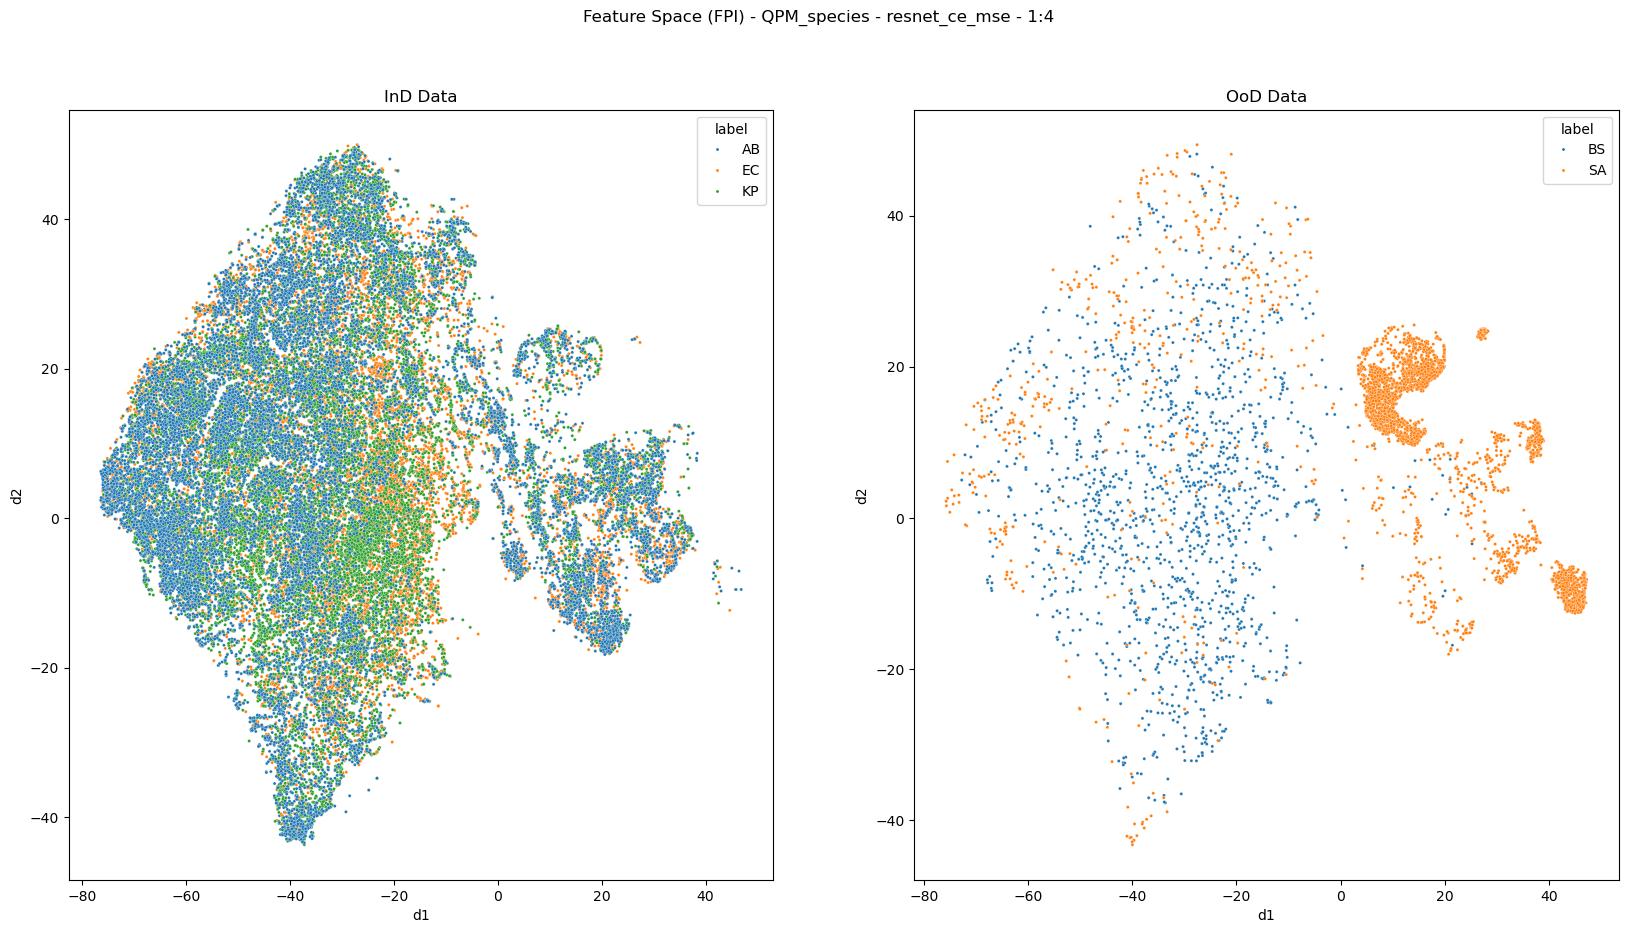

In [12]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

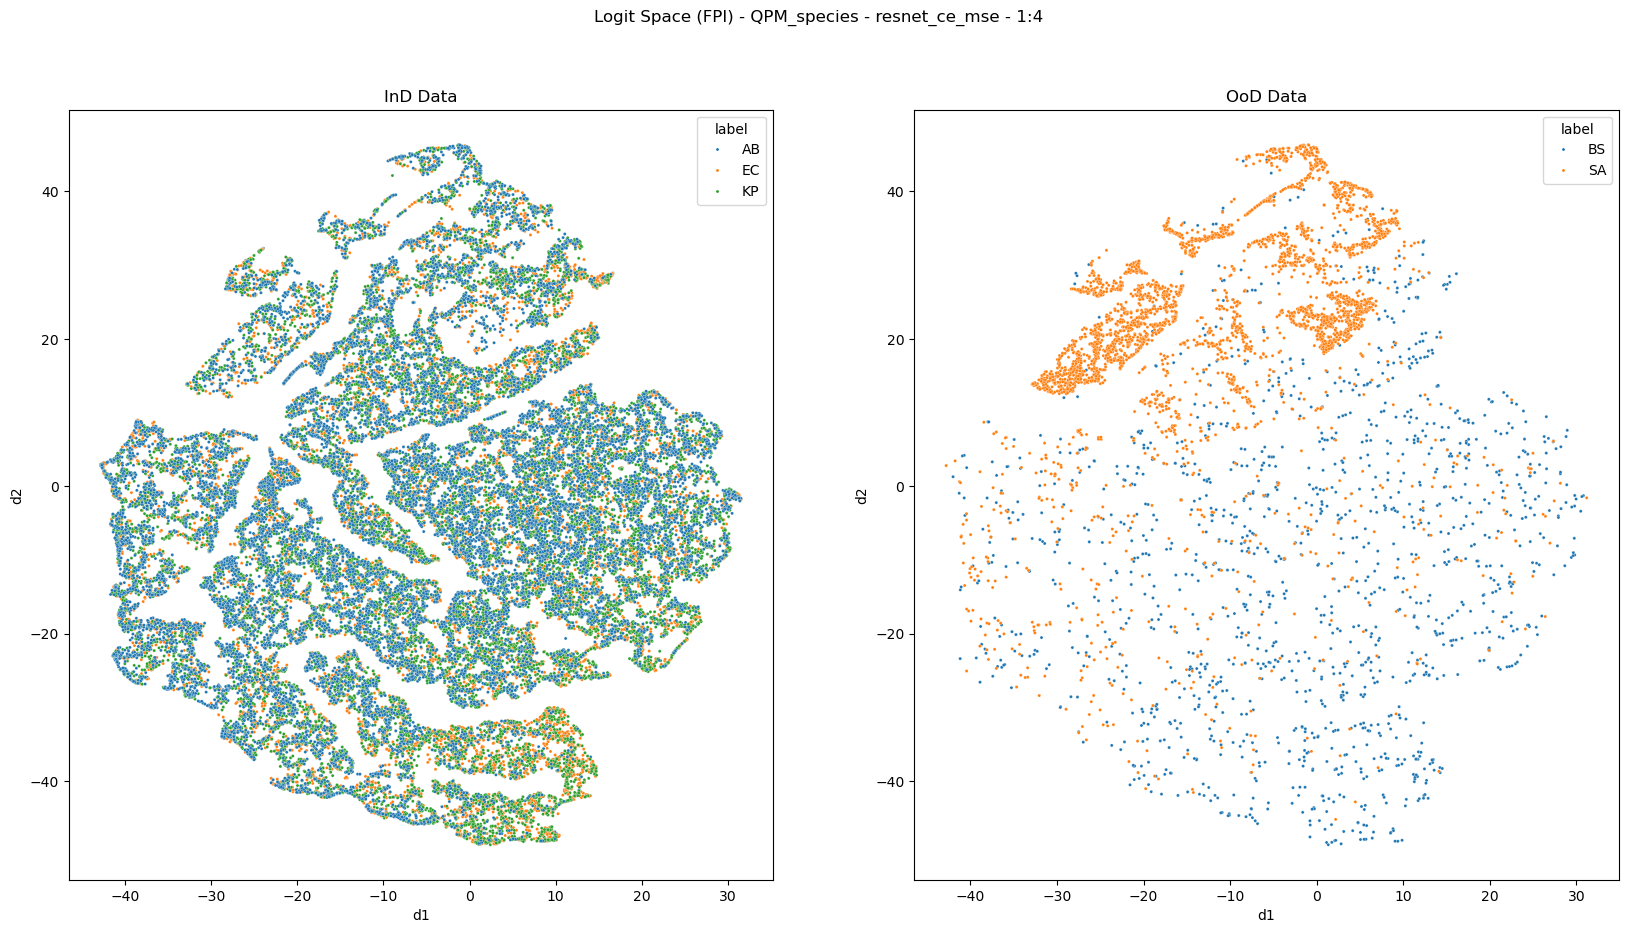

In [13]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:14<00:44, 14.97s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:29<00:29, 14.99s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:45<00:15, 15.06s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.24s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.16s/it]

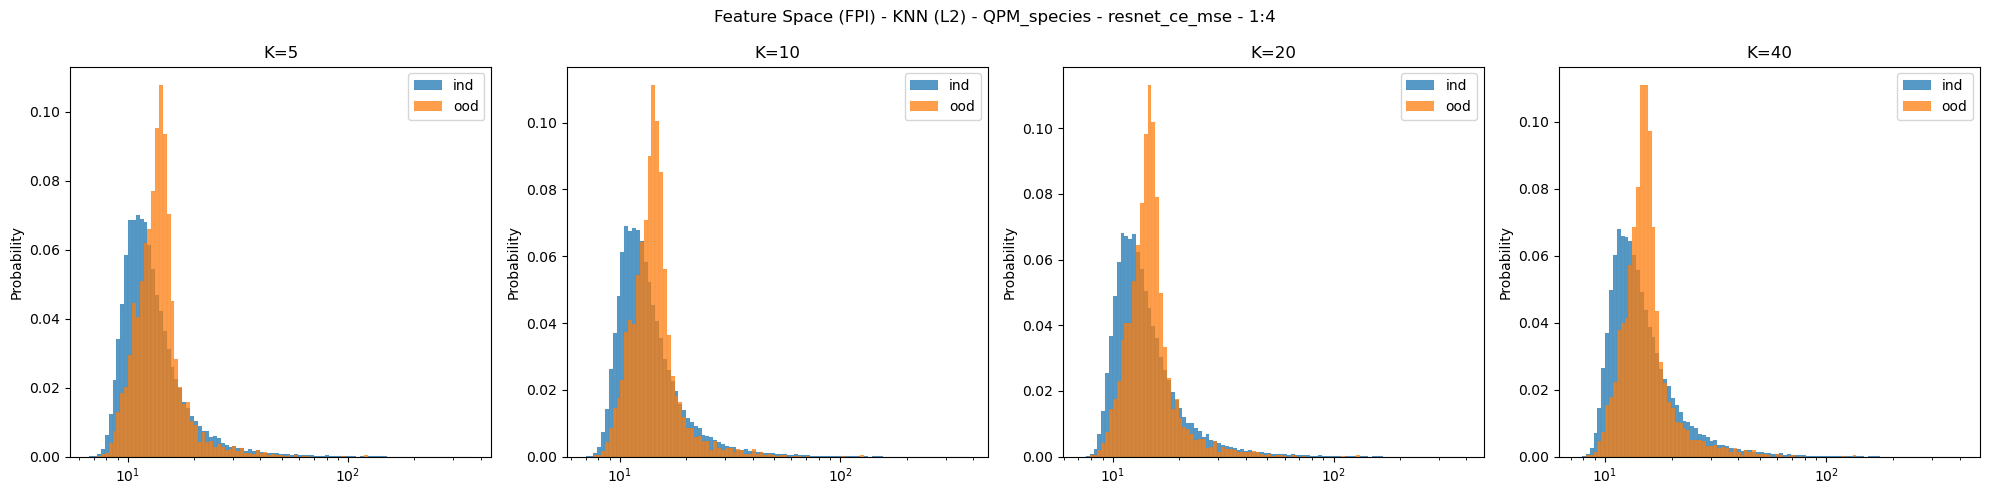

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:14<00:43, 14.53s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:29<00:29, 14.68s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:44<00:14, 14.72s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.88s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.80s/it]

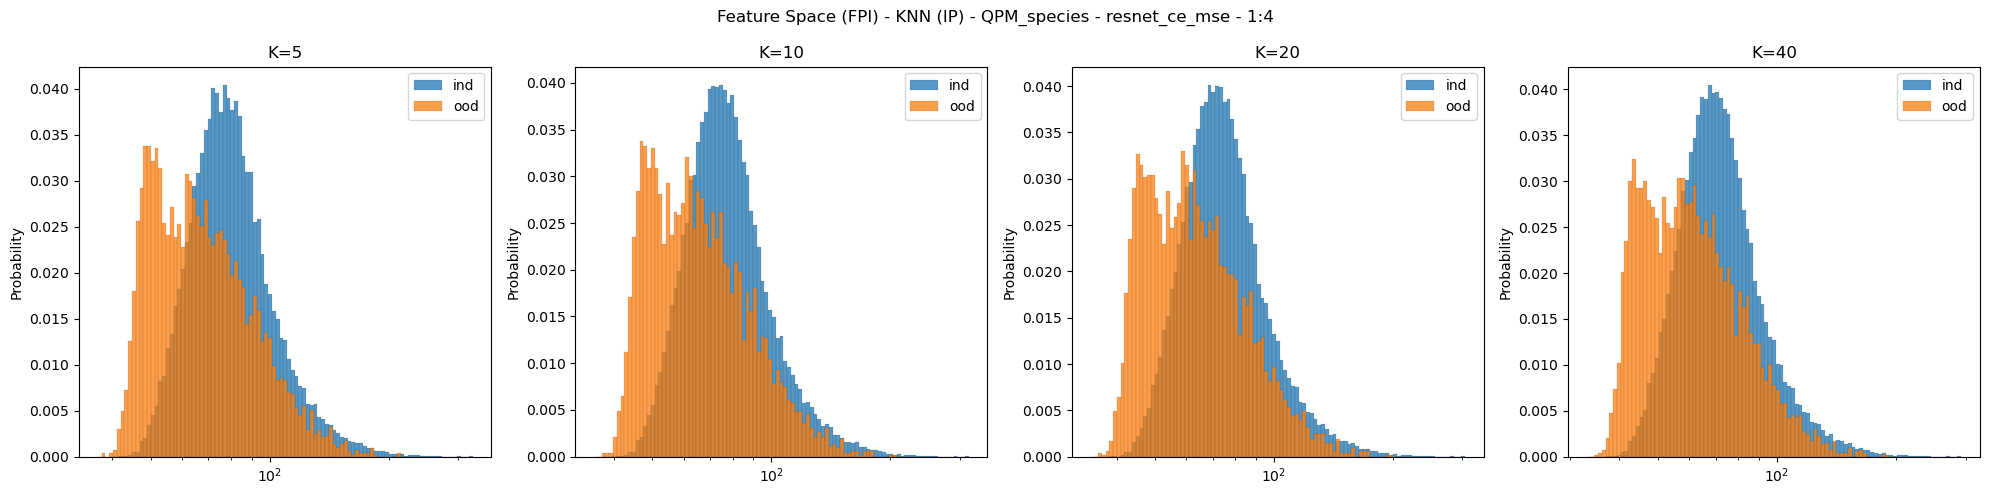

In [15]:
# check knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:14<00:44, 14.82s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:29<00:29, 14.88s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:44<00:14, 14.95s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.11s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.03s/it]

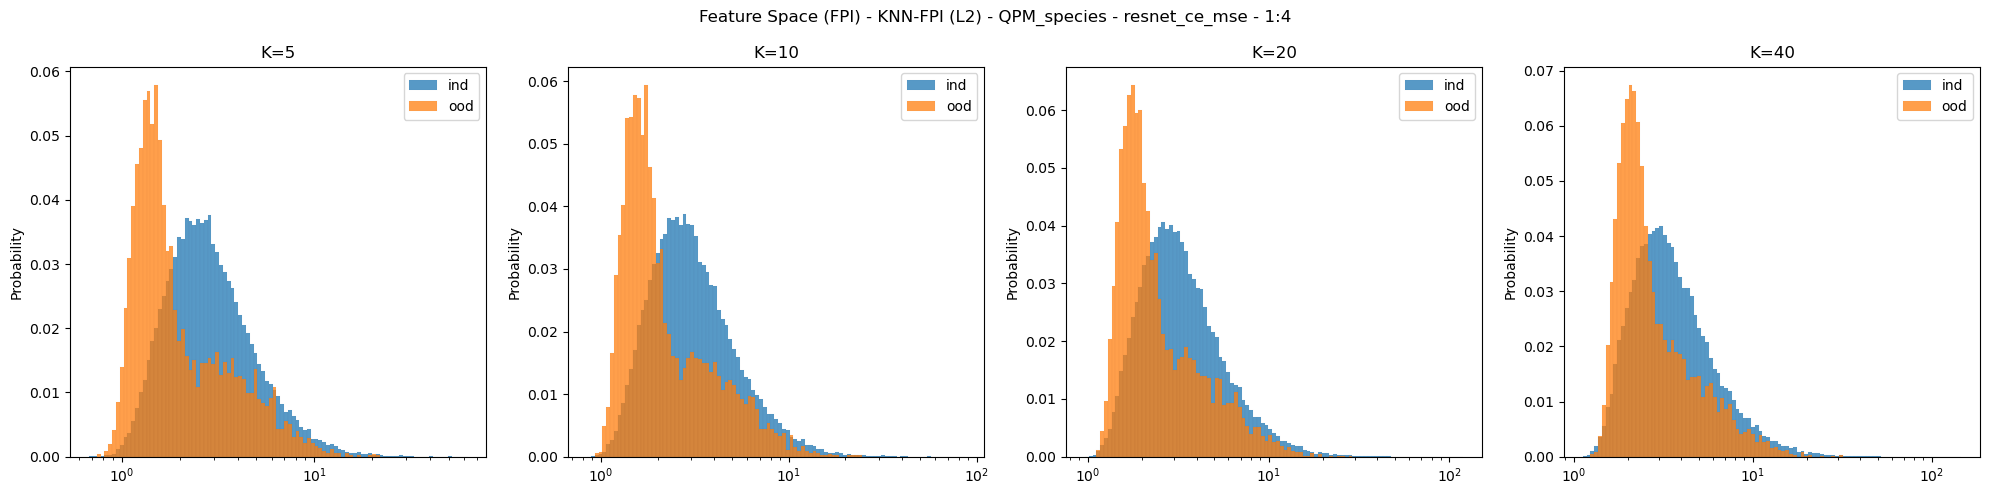

In [16]:
# check knn to val data FPI in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:14<00:43, 14.54s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:29<00:29, 14.57s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:43<00:14, 14.65s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.83s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.74s/it]

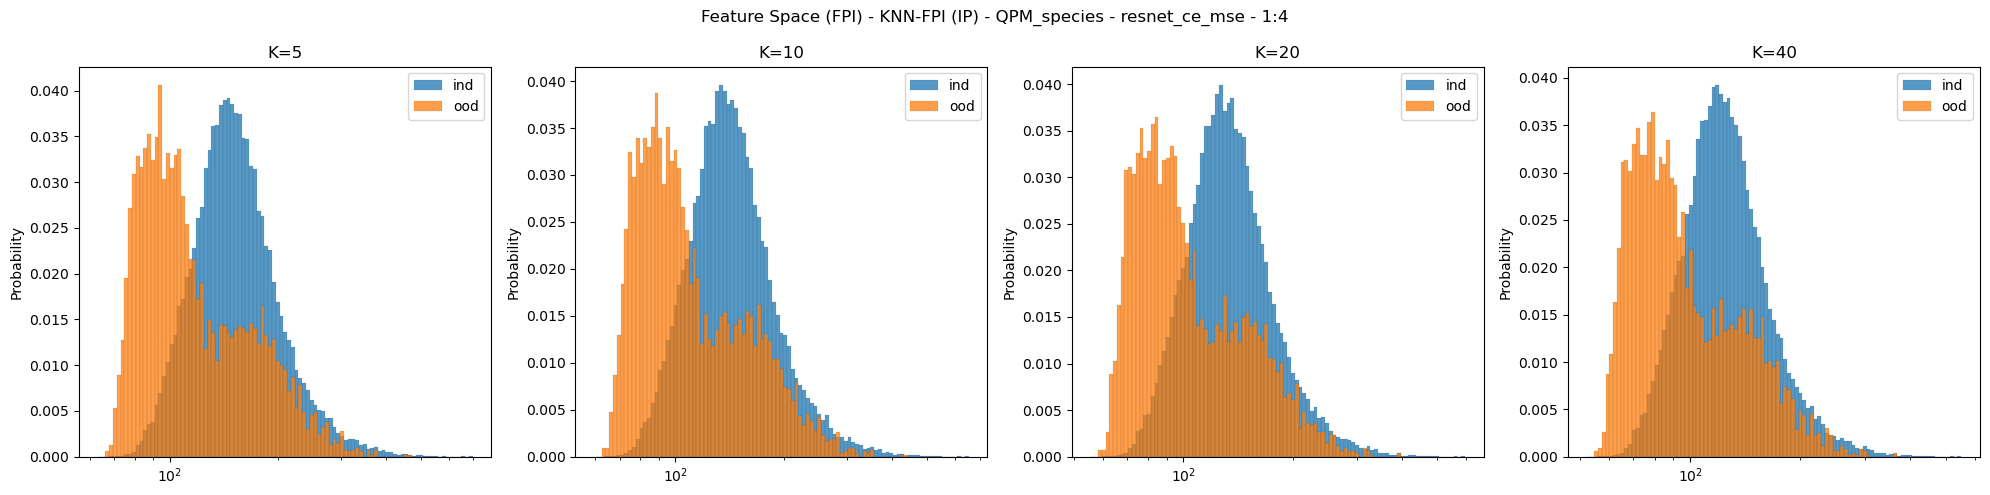

In [17]:
# check knn to val data FPI in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:02<00:06,  2.08s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:04<00:04,  2.12s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:06<00:02,  2.21s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.39s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.30s/it]

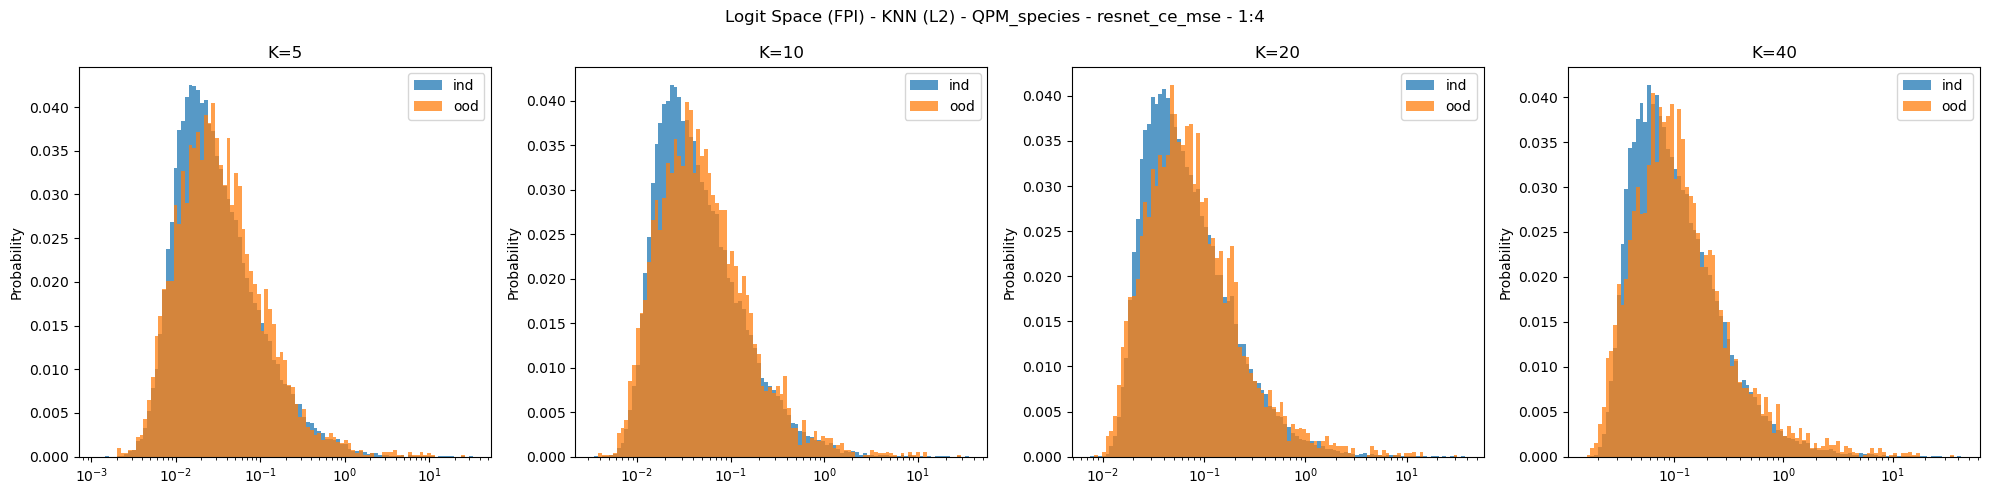

In [18]:
# check knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:05,  1.79s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:03<00:03,  1.85s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:05<00:01,  1.96s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.06s/it]

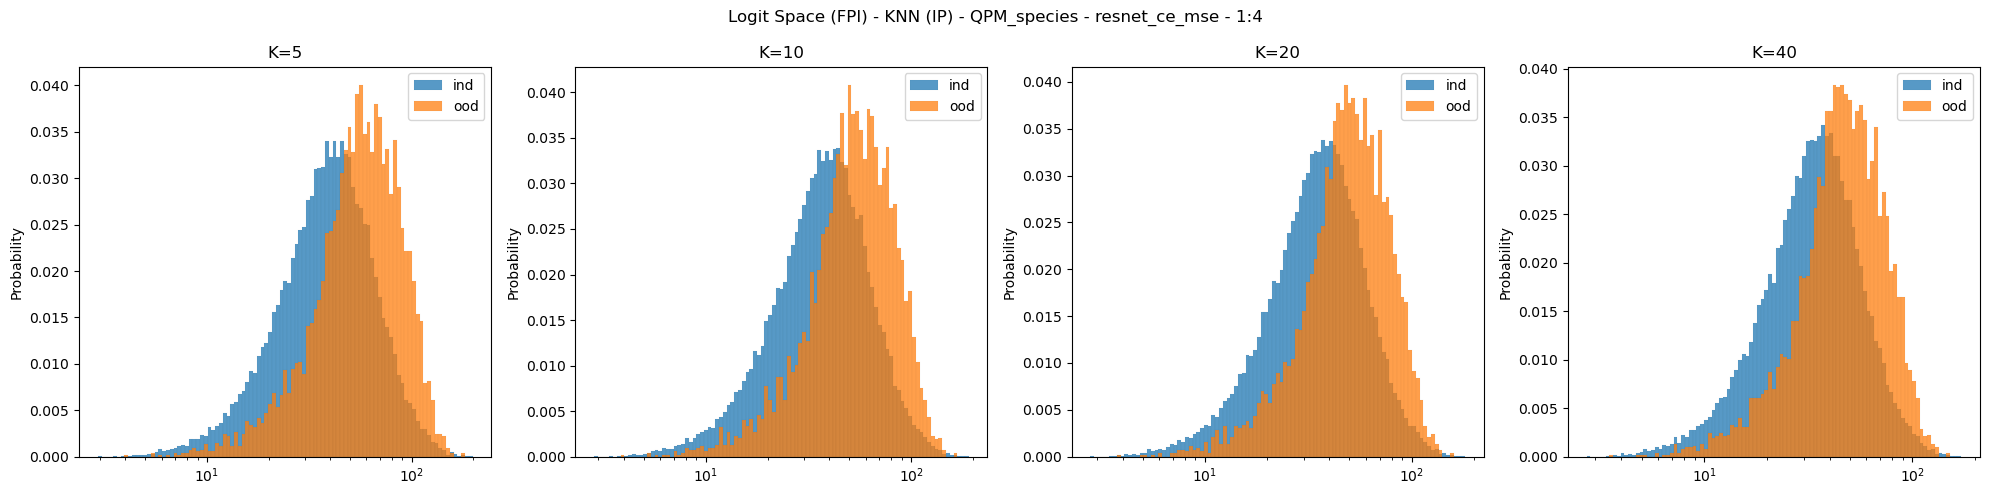

In [19]:
# check knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:02<00:06,  2.12s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:04<00:04,  2.16s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:06<00:02,  2.34s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.44s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.36s/it]

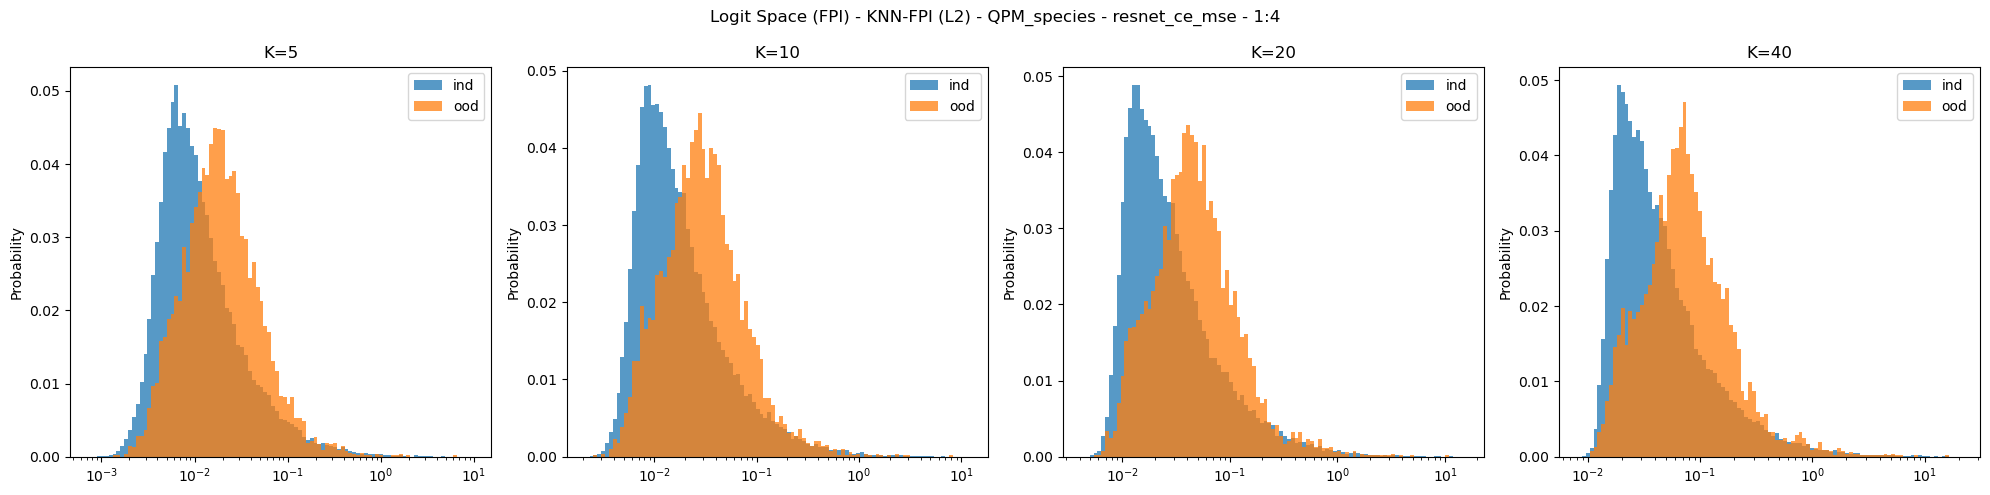

In [20]:
# check knn to val data FPI in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:05,  1.78s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:03<00:03,  1.82s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:05<00:01,  1.92s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.09s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.01s/it]

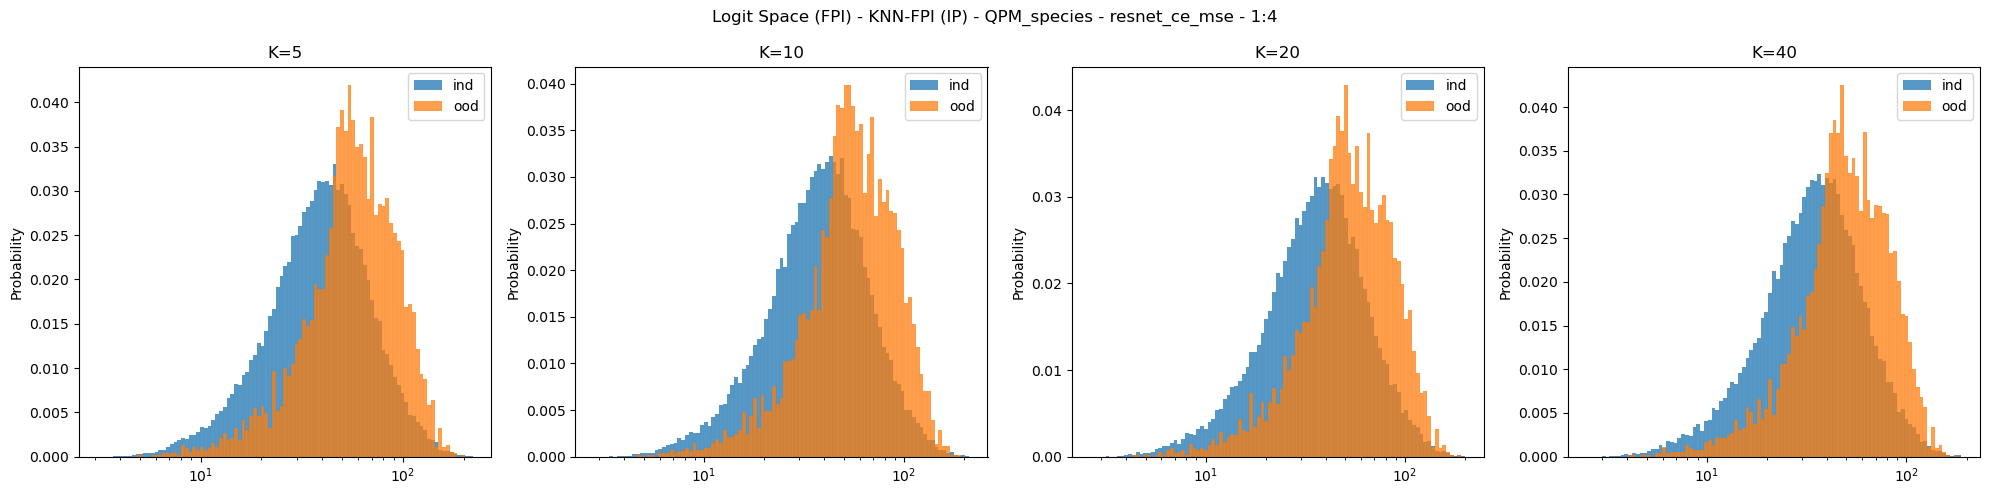

In [21]:
# check knn to val data FPI in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

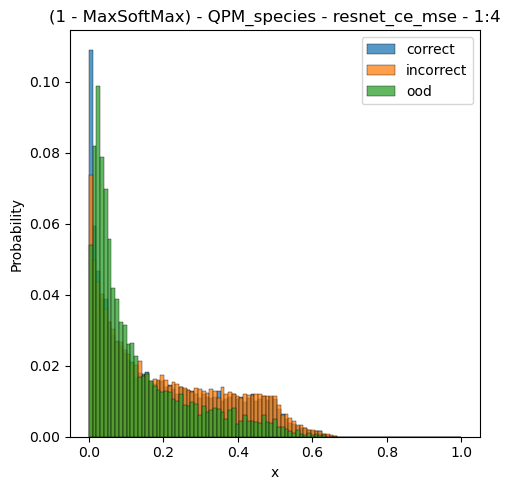

In [22]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

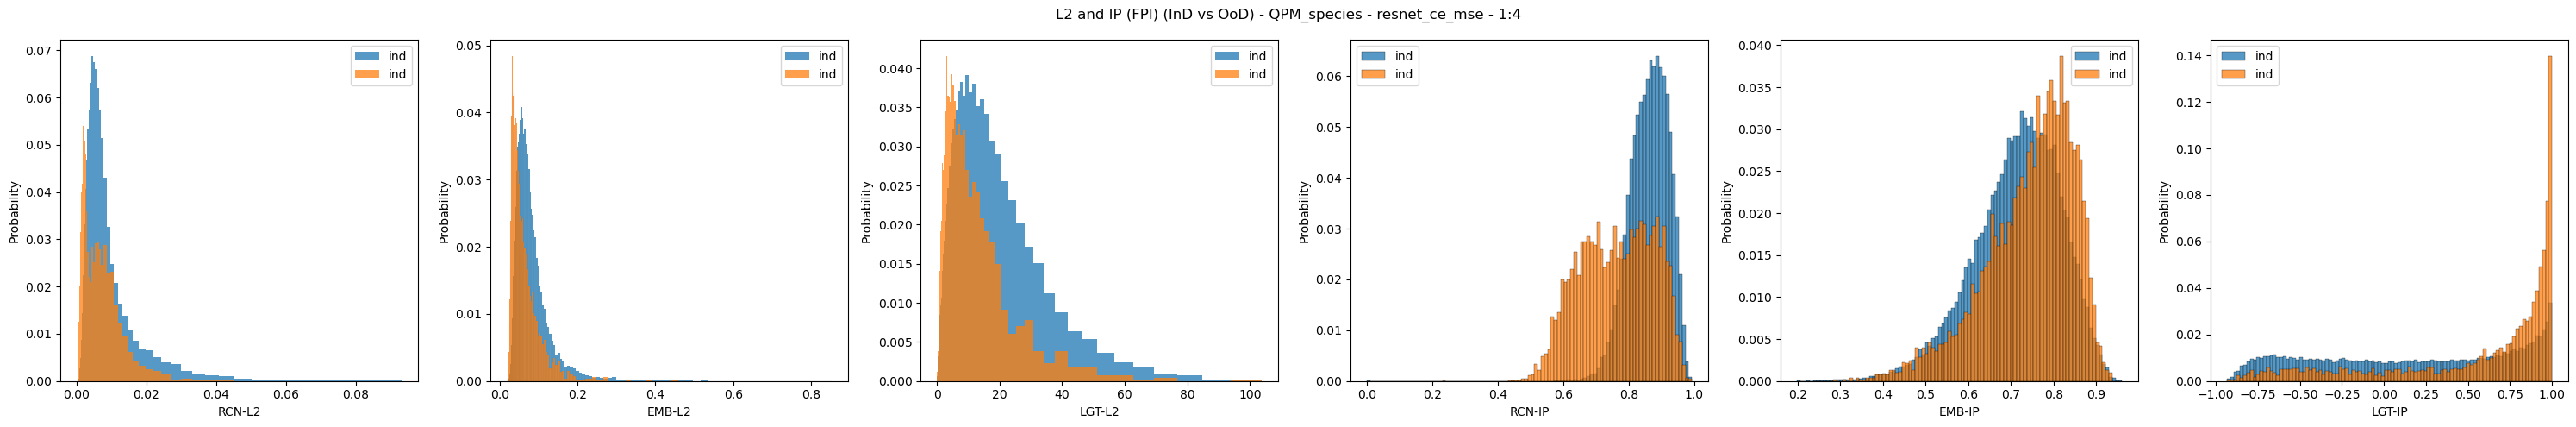

In [23]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_emb = ind_emb.reshape(si)
_ind_lgt = ind_lgt.reshape(si)
_ind_rcn_fpi = ind_rcn_fpi.reshape(si)
_ind_emb_fpi = ind_emb_fpi.reshape(si)
_ind_lgt_fpi = ind_lgt_fpi.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
_ind_emb_unit = _ind_emb / (np.linalg.norm(_ind_emb, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_unit = _ind_lgt / (np.linalg.norm(_ind_lgt, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_fpi_unit = _ind_rcn_fpi / (np.linalg.norm(_ind_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_emb_fpi_unit = _ind_emb_fpi / (np.linalg.norm(_ind_emb_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_fpi_unit = _ind_lgt_fpi / (np.linalg.norm(_ind_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)
# store
_df = pd.DataFrame(dict(
    target=ind_tgt,
    rcn_l2=ind_rcn_l2_fpi,
    emb_l2=ind_emb_l2_fpi,
    lgt_l2=ind_lgt_l2_fpi,
    rcn_ip=ind_rcn_ip_fpi,
    emb_ip=ind_emb_ip_fpi,
    lgt_ip=ind_lgt_ip_fpi,
    source="ind",
))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_emb = ood_emb.reshape(so)
    _ood_lgt = ood_lgt.reshape(so)
    _ood_rcn_fpi = ood_rcn_fpi.reshape(so)
    _ood_emb_fpi = ood_emb_fpi.reshape(so)
    _ood_lgt_fpi = ood_lgt_fpi.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_unit = _ood_emb / (np.linalg.norm(_ood_emb, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_unit = _ood_lgt / (np.linalg.norm(_ood_lgt, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_fpi_unit = _ood_rcn_fpi / (np.linalg.norm(_ood_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_fpi_unit = _ood_emb_fpi / (np.linalg.norm(_ood_emb_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_fpi_unit = _ood_lgt_fpi / (np.linalg.norm(_ood_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(
        target=ood_tgt,
        rcn_l2=ood_rcn_l2_fpi,
        emb_l2=ood_emb_l2_fpi,
        lgt_l2=ood_lgt_l2_fpi,
        rcn_ip=ood_rcn_ip_fpi,
        emb_ip=ood_emb_ip_fpi,
        lgt_ip=ood_lgt_ip_fpi,
        source="ood",
    ))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_emb_l2 = np.logspace(np.log10(df_rstat['emb_l2'].min() + 1e-7), np.log10(df_rstat['emb_l2'].max()), 100)
bins_lgt_l2 = np.logspace(np.log10(df_rstat['lgt_l2'].min() + 1e-7), np.log10(df_rstat['lgt_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
bins_emb_ip = np.linspace(df_rstat['emb_ip'].min(), df_rstat['emb_ip'].max(), 100)
bins_lgt_ip = np.linspace(df_rstat['lgt_ip'].min(), df_rstat['lgt_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax1.set_xlabel("RCN-L2")
ax2.set_xlabel("EMB-L2")
ax3.set_xlabel("LGT-L2")
ax4.set_xlabel("RCN-IP")
ax5.set_xlabel("EMB-IP")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()